**Table of Contents**

1. [Import Library](#Import-Library)
2. [Data Loading](#Data-Loading)
3. [Feature Engineering](#Feature-Engineering)
4. [Data Understanding](#Data-Understanding)
5. [Data Split](#Data-Split)
6. [Applying Base Model](#Applying-Base-Model)
7. [Evaluation](#Evaluation)
8. [Error Analysis](#Error-Analysis)
9. [[Comparison]](#[Comparison])
10. [[Insufficient for me]](#[Insufficient-for-me])

# Import Library
**1. Import Library**

In [1]:
!python -m pip install --user --upgrade pip
!pip install xgboost
!pip install lightgbm

Requirement already up-to-date: pip in c:\users\kk\appdata\roaming\python\python36\site-packages (19.0.3)


In [65]:
# Ignore the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# System related and data input controls
import os

# Data manipulation and visualization
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_rows = 50
pd.options.display.max_columns = 40
import numpy as np
from patsy import dmatrix
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling algorithms
# General
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

# Regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Classification
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Model selection
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# Evaluation metrics
# for regression
from sklearn.metrics import mean_squared_log_error, mean_squared_error,  r2_score, mean_absolute_error
# for classification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [3]:
### Feature engineering of default
def non_feature_engineering(raw):
    if 'datetime' in raw.columns:
        raw['datetime'] = pd.to_datetime(raw['datetime'])
        raw['DateTime'] = pd.to_datetime(raw['datetime'])
    if raw.index.dtype == 'int64':
        raw.set_index('DateTime', inplace=True)
    # bring back
    # if raw.index.dtype != 'int64':
    #     raw.reset_index(drop=False, inplace=True)
    raw = raw.asfreq('H', method='ffill')
    raw_nfe = raw.copy()
    return raw_nfe
# raw_all = non_feature_engineering(raw_all)


### Feature engineering of all
def feature_engineering(raw):
    if 'datetime' in raw.columns:
        raw['datetime'] = pd.to_datetime(raw['datetime'])
        raw['DateTime'] = pd.to_datetime(raw['datetime'])

    if raw.index.dtype == 'int64':
        raw.set_index('DateTime', inplace=True)

    raw = raw.asfreq('H', method='ffill')

    result = sm.tsa.seasonal_decompose(raw['count'], model='additive')
    Y_trend = pd.DataFrame(result.trend)
    Y_trend.fillna(method='ffill', inplace=True)
    Y_trend.fillna(method='bfill', inplace=True)
    Y_trend.columns = ['count_trend']
    Y_seasonal = pd.DataFrame(result.seasonal)
    Y_seasonal.fillna(method='ffill', inplace=True)
    Y_seasonal.fillna(method='bfill', inplace=True)
    Y_seasonal.columns = ['count_seasonal']
    pd.concat([raw, Y_trend, Y_seasonal], axis=1).isnull().sum()
    if 'count_trend' not in raw.columns:
        if 'count_seasonal' not in raw.columns:
            raw = pd.concat([raw, Y_trend, Y_seasonal], axis=1)

    Y_count_Day = raw[['count']].rolling(24).mean()
    Y_count_Day.fillna(method='ffill', inplace=True)
    Y_count_Day.fillna(method='bfill', inplace=True)
    Y_count_Day.columns = ['count_Day']
    Y_count_Week = raw[['count']].rolling(24*7).mean()
    Y_count_Week.fillna(method='ffill', inplace=True)
    Y_count_Week.fillna(method='bfill', inplace=True)
    Y_count_Week.columns = ['count_Week']
    if 'count_Day' not in raw.columns:
        raw = pd.concat([raw, Y_count_Day], axis=1)
    if 'count_Week' not in raw.columns:
        raw = pd.concat([raw, Y_count_Week], axis=1)

    Y_diff = raw[['count']].diff()
    Y_diff.fillna(method='ffill', inplace=True)
    Y_diff.fillna(method='bfill', inplace=True)
    Y_diff.columns = ['count_diff']
    if 'count_diff' not in raw.columns:
        raw = pd.concat([raw, Y_diff], axis=1)

    raw['temp_group'] = pd.cut(raw['temp'], 10)
    raw['Year'] = raw.datetime.dt.year
    raw['Quater'] = raw.datetime.dt.quarter
    raw['Quater_ver2'] = raw['Quater'] + (raw.Year - raw.Year.min()) * 4
    raw['Month'] = raw.datetime.dt.month
    raw['Day'] = raw.datetime.dt.day
    raw['Hour'] = raw.datetime.dt.hour
    raw['DayofWeek'] = raw.datetime.dt.dayofweek

    raw['count_lag1'] = raw['count'].shift(1)
    raw['count_lag2'] = raw['count'].shift(2)
    raw['count_lag1'].fillna(method='bfill', inplace=True)
    raw['count_lag2'].fillna(method='bfill', inplace=True)

    if 'Quater' in raw.columns:
        raw = pd.concat([raw, pd.get_dummies(raw['Quater'], prefix='Quater_Dummy', drop_first=True)
    ], axis=1)
        del raw['Quater']
    raw_fe = raw.copy()
    return raw_fe
# raw_all = feature_engineering(raw_all)


### Data split of cross sectional
def datasplit_cs(raw, Y_colname, X_colname, test_size, random_seed=123):
    X_train, X_test, Y_train, Y_test = train_test_split(raw[X_colname], raw[Y_colname], test_size=test_size, random_state=random_seed)
    print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
    print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)
    return X_train, X_test, Y_train, Y_test
# X_train, X_test, Y_train, Y_test = datasplit_cs(raw_all, Y_colname, X_colname, 0.2)


### Data split of time series
def datasplit_ts(raw, Y_colname, X_colname, criteria):
    raw_train = raw.loc[raw.index < criteria,:]
    raw_test = raw.loc[raw.index >= criteria,:]
    Y_train = raw_train[Y_colname]
    X_train = raw_train[X_colname]
    Y_test = raw_test[Y_colname]
    X_test = raw_test[X_colname]
    print('Train_size:', raw_train.shape, 'Test_size:', raw_test.shape)
    print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
    print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)
    return X_train, X_test, Y_train, Y_test
# X_train, X_test, Y_train, Y_test = datasplit_ts(raw_all, Y_colname, X_colname, '2012-07-01')


### Evaluation of 1 pair of set
def evaluation(Y_real, Y_pred, graph_on=False):
    loss_length = len(Y_real.values.flatten()) - len(Y_pred)
    if loss_length != 0:
        Y_real = Y_real[loss_length:]
    if graph_on == True:
        pd.concat([Y_real, pd.DataFrame(Y_pred, index=Y_real.index, columns=['prediction'])], axis=1).plot(kind='line', figsize=(20,6),
                                                                                                           xlim=(Y_real.index.min(),Y_real.index.max()),
                                                                                                           linewidth=3, fontsize=20)
        plt.title('Time Series of Target', fontsize=20)
        plt.xlabel('Index', fontsize=15)
        plt.ylabel('Target Value', fontsize=15)
    MAD = abs(Y_real.values.flatten() - Y_pred).mean()
    MSE = ((Y_real.values.flatten() - Y_pred)**2).mean()
    MAPE = (abs(Y_real.values.flatten() - Y_pred)/Y_real.values.flatten()*100).mean()
    Score = pd.DataFrame([MAD, MSE, MAPE], index=['MAD', 'MSE', 'MAPE'], columns=['Score']).T
    Residual = pd.DataFrame(Y_real.values.flatten() - Y_pred, index=Y_real.index, columns=['Error'])
    return Score, Residual
# Score_tr, Residual_tr = evaluation(Y_train, model_pred_tr_reg1, graph_on=True)


### Evaluation of train/test pairs
def evaluation_trte(Y_real_tr, Y_pred_tr, Y_real_te, Y_pred_te, graph_on=False):
    Score_tr, Residual_tr = evaluation(Y_real_tr, Y_pred_tr, graph_on=graph_on)
    Score_te, Residual_te = evaluation(Y_real_te, Y_pred_te, graph_on=graph_on)
    Score_trte = pd.concat([Score_tr, Score_te], axis=0)
    Score_trte.index = ['Train', 'Test']
    return Score_trte, Residual_tr, Residual_te
# Score1, Resid_tr_reg1, Resid_te_reg1 = evaluation_trte(Y_train, model_pred_tr_reg1, Y_test, model_pred_te_reg1, graph_on=True)


### Error analysis
def error_analysis(Y_Data, Target_name, X_Data, graph_on=False):
    for x in Target_name:
        Target_name = x
    X_Data = X_Data.loc[Y_Data.index]

    if graph_on == True:
        ##### Error Analysis(Plot)
        Y_Data['RowNum'] = Y_Data.reset_index().index

        # Stationarity(Trend) Analysis
        sns.set(palette="muted", color_codes=True, font_scale=2)
        sns.lmplot(x='RowNum', y=Target_name, data=Y_Data, fit_reg='True', size=7, aspect=2, ci=99, sharey=True)
        del Y_Data['RowNum']

        # Normal Distribution Analysis
        figure, axes = plt.subplots(figsize=(16,8))
        sns.distplot(Y_Data[Target_name], norm_hist='True', fit=stats.norm)

        # Lag Analysis
        length = int(len(Y_Data[Target_name])/10)
        figure, axes = plt.subplots(3, 2, figsize=(16,16))
        pd.plotting.lag_plot(Y_Data[Target_name], lag=1, ax=axes[0,0])
        pd.plotting.lag_plot(Y_Data[Target_name], lag=2, ax=axes[0,1])
        pd.plotting.lag_plot(Y_Data[Target_name], lag=3, ax=axes[1,0])
        pd.plotting.lag_plot(Y_Data[Target_name], lag=4, ax=axes[1,1])
        pd.plotting.lag_plot(Y_Data[Target_name], lag=10, ax=axes[2,0])
        pd.plotting.lag_plot(Y_Data[Target_name], lag=20, ax=axes[2,1])

        # Autocorrelation Analysis
        figure, axes = plt.subplots(2,1,figsize=(16,10))
        sm.graphics.tsa.plot_acf(Y_Data[Target_name], lags=100, use_vlines=True, ax=axes[0])
        sm.graphics.tsa.plot_pacf(Y_Data[Target_name], lags=100, use_vlines=True, ax=axes[1])      

    ##### Error Analysis(Statistics)
    # Checking Stationarity
    # Null Hypothesis: The Time-series is non-stationalry
    Stationarity = pd.Series(sm.tsa.stattools.adfuller(Y_Data[Target_name])[0:4],
                             index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
    for key, value in sm.tsa.stattools.adfuller(Y_Data[Target_name])[4].items():
        Stationarity['Critical Value(%s)'%key] = value
        Stationarity['Maximum Information Criteria'] = sm.tsa.stattools.adfuller(Y_Data[Target_name])[5]
        Stationarity = pd.DataFrame(Stationarity, columns=['Stationarity'])

    # Checking of Normality
    # Null Hypothesis: The residuals are normally distributed
    Normality = pd.DataFrame([stats.shapiro(Y_Data[Target_name])],
                             index=['Normality'], columns=['Test Statistics', 'p-value']).T

    # Checking for Autocorrelation
    # Null Hypothesis: Autocorrelation is absent
    Autocorrelation = pd.concat([pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Y_Data[Target_name], lags=[1,5,10,50])[0], columns=['Test Statistics']),
                                 pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Y_Data[Target_name], lags=[1,5,10,50])[1], columns=['p-value'])], axis=1).T
    Autocorrelation.columns = ['Autocorr(lag1)', 'Autocorr(lag5)', 'Autocorr(lag10)', 'Autocorr(lag50)']

    # Checking Heteroscedasticity
    # Null Hypothesis: Error terms are homoscedastic
    Heteroscedasticity = pd.DataFrame([sm.stats.diagnostic.het_goldfeldquandt(Y_Data[Target_name], X_Data.values, alternative='two-sided')],
                                      index=['Heteroscedasticity'], columns=['Test Statistics', 'p-value', 'Alternative']).T
    Score = pd.concat([Stationarity, Normality, Autocorrelation, Heteroscedasticity], join='outer', axis=1)
    Score = Score.loc[['Test Statistics', 'p-value', 'Alternative', 'Used Lag', 'Used Observations',
                       'Critical Value(1%)', 'Critical Value(5%)', 'Critical Value(10%)', 'Maximum Information Criteria'],:]
    return Score
# error_analysis(Resid_tr_reg1[1:], ['Error'], X_train, graph_on=True)

# Summary of Comparison

## Result of Raw Data

Train_size: (13128, 12) Test_size: (4416, 12)
X_train: (13128, 8) Y_train: (13128, 1)
X_test: (4416, 8) Y_test: (4416, 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.638
Model:                            OLS   Adj. R-squared:                  0.638
Method:                 Least Squares   F-statistic:                     2889.
Date:                Sun, 03 Mar 2019   Prob (F-statistic):               0.00
Time:                        22:50:38   Log-Likelihood:                -83421.
No. Observations:               13128   AIC:                         1.669e+05
Df Residuals:                   13120   BIC:                         1.669e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
season         3.3659      1.286      2.618      0.009       0.846       5.886
holiday       -6.2896      7.466     -0.842      0.400     -20.924       8.345
workingday    10.3553      2.641      3.921      0.000       5.178      15.533
weather        7.1906      2.093      3.436      0.001       3.089      11.292
temp          -7.8544      1.222     -6.429      0.000     -10.249      -5.460
atemp         16.0695      1.095     14.676      0.000      13.923      18.216
humidity      -1.7353      0.063    -27.356      0.000      -1.860      -1.611
windspeed      2.2749      0.136     16.745      0.000       2.009       2.541
==============================================================================
Omnibus:                     2168.771   Durbin-Watson:                   0.419
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3942.747
Skew:                           1.050   Prob(JB):                         0.00
Kurtosis:                       4.672   Cond. No.                         450.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

MAD       MSE   MAPE
Train 103.09 19,360.42 458.48
Test  150.03 43,410.27 316.61

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Stationarity  Normality  Autocorr(lag1)  \
Test Statistics                      -9.25       0.94        8,204.84   
p-value                               0.00       0.00            0.00   
Alternative                            nan        nan             nan   
Used Lag                             40.00        nan             nan   
Used Observations                13,087.00        nan             nan   
Critical Value(1%)                   -3.43        nan             nan   
Critical Value(5%)                     nan        nan             nan   
Critical Value(10%)                    nan        nan             nan   
Maximum Information Criteria    143,252.82        nan             nan   

                              Autocorr(lag5)  Autocorr(lag10)  \
Test Statistics                    12,494.43        13,138.03   
p-value                                 0.00             0.00   
Alternative                              nan              nan   
Used Lag                                 nan              nan   
Used Observations                        nan              nan   
Critical Value(1%)                       nan              nan   
Critical Value(5%)                       nan              nan   
Critical Value(10%)                      nan              nan   
Maximum Information Criteria             nan              nan   

                              Autocorr(lag50) Heteroscedasticity  
Test Statistics                     48,485.56               1.76  
p-value                                  0.00               0.00  
Alternative                               nan          two-sided  
Used Lag                                  nan                NaN  
Used Observations                         nan                NaN  
Critical Value(1%)                        nan                NaN  
Critical Value(5%)                        nan                NaN  
Critical Value(10%)                       nan                NaN  
Maximum Information Criteria              nan                NaN

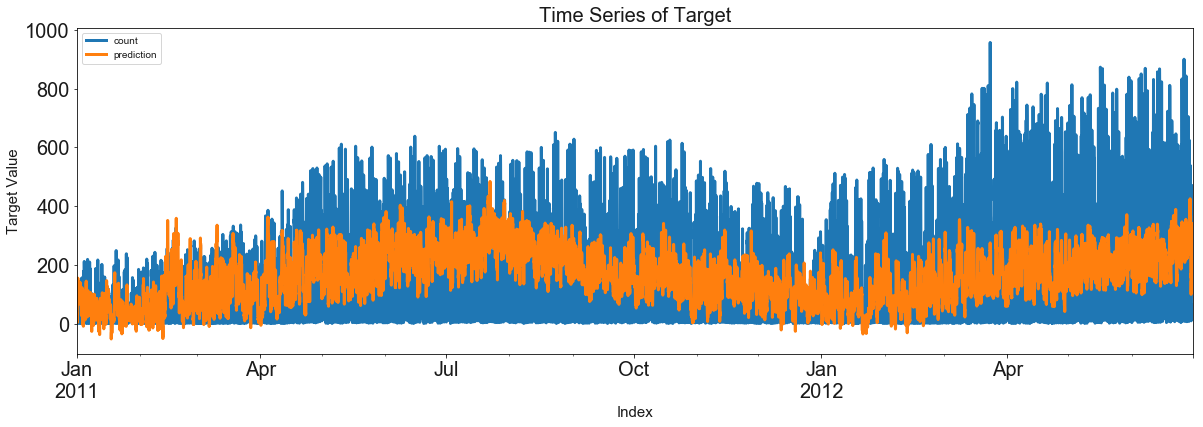

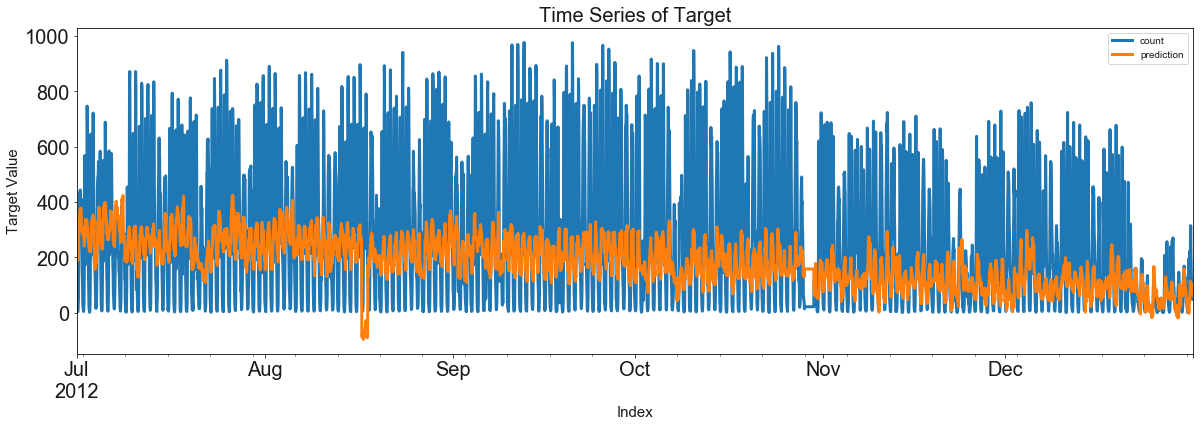

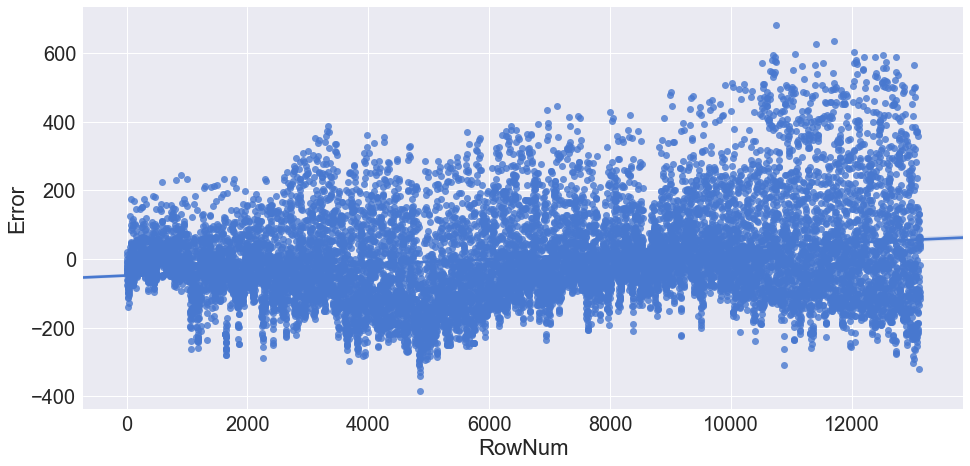

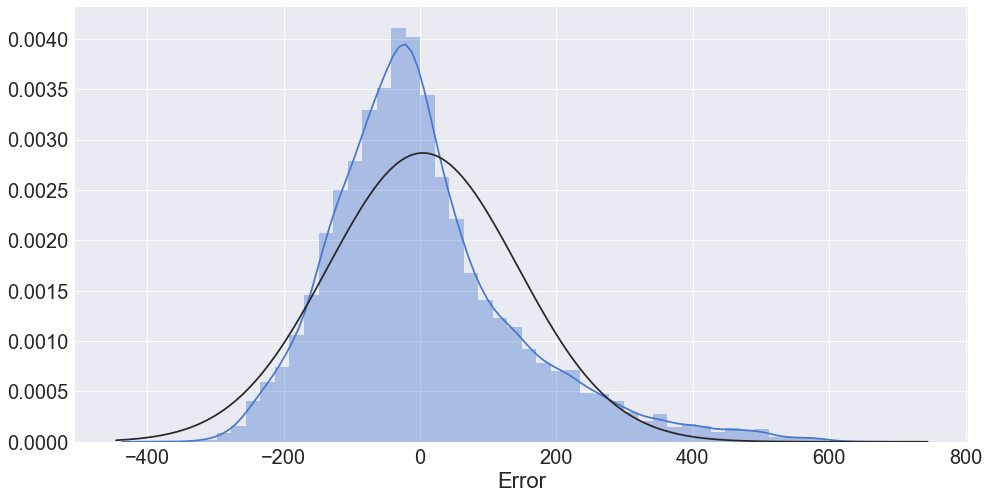

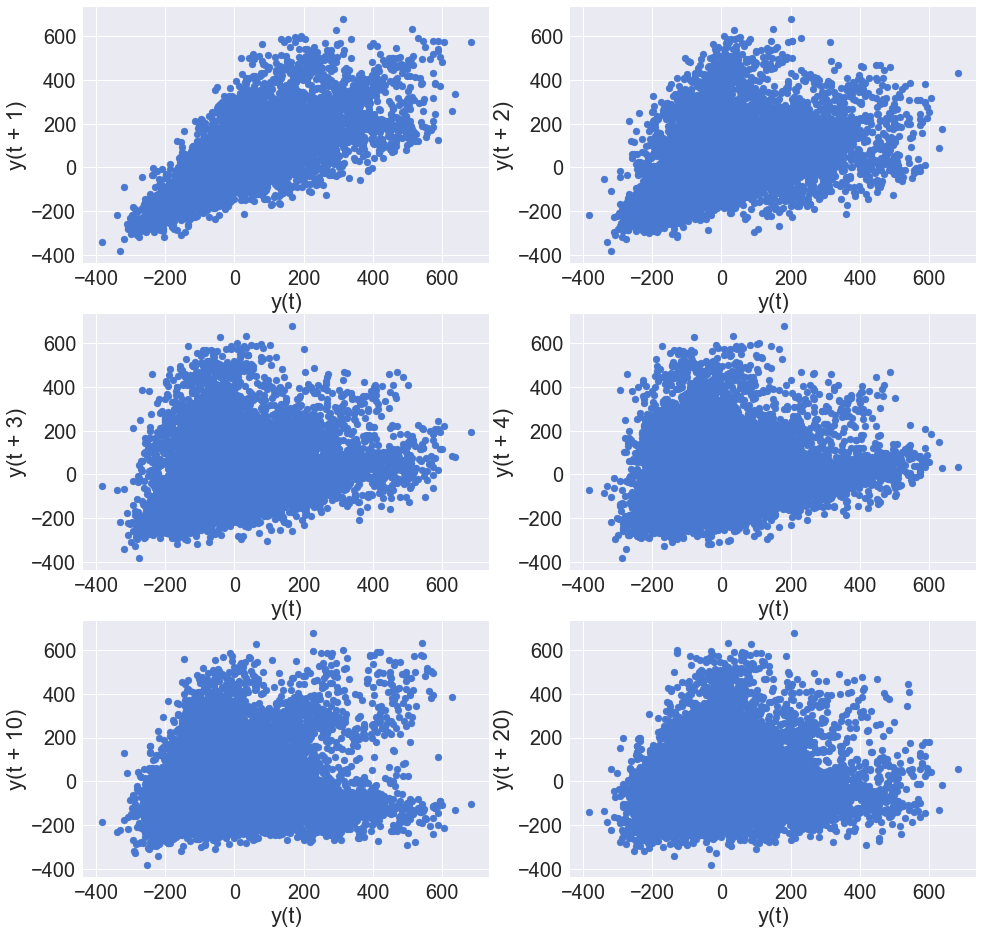

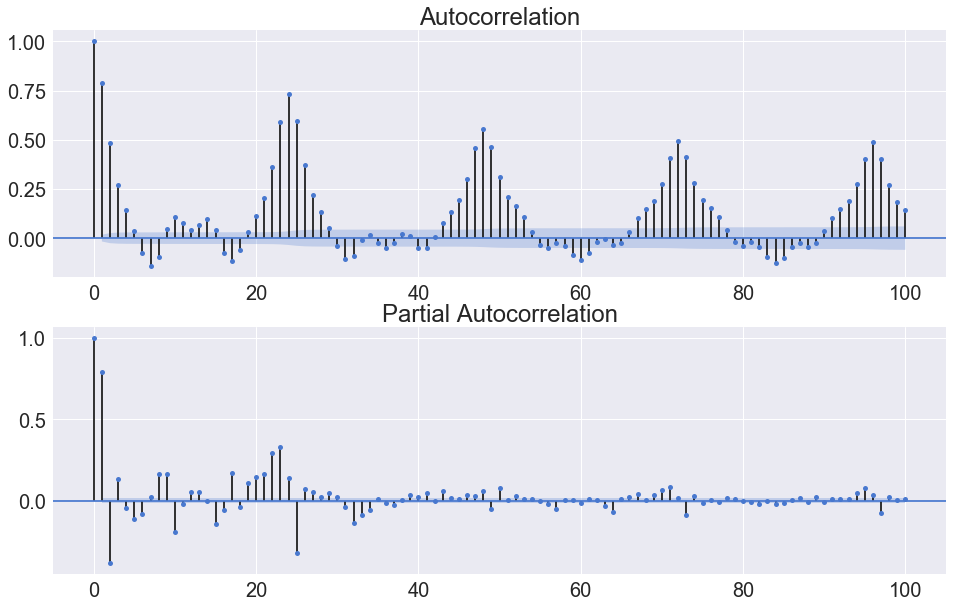

In [4]:
# Data Loading
# location = 'https://raw.githubusercontent.com/cheonbi/DataScience/master/Data/Bike_Sharing_Demand_Full.csv'
location = '../Data/Bike_Sharing_Demand_Full.csv'
raw_all = pd.read_csv(location)

# Feature Engineering
raw_rd = non_feature_engineering(raw_all)

# Data Split
# Confirm of input and output
Y_colname = ['count']
X_remove = ['datetime', 'DateTime', 'temp_group', 'casual', 'registered']
X_colname = [x for x in raw_rd.columns if x not in Y_colname+X_remove]
X_train_rd, X_test_rd, Y_train_rd, Y_test_rd = datasplit_ts(raw_rd, Y_colname, X_colname, '2012-07-01')

# Applying Base Model
model_fit_reg1_rd = sm.OLS(Y_train_rd, X_train_rd).fit()
display(model_fit_reg1_rd.summary())
model_pred_tr_reg1_rd = model_fit_reg1_rd.predict(X_train_rd).values
model_pred_te_reg1_rd = model_fit_reg1_rd.predict(X_test_rd).values

# Evaluation
Score1_rd, Resid_tr_reg1_rd, Resid_te_reg1_rd = evaluation_trte(Y_train_rd, model_pred_tr_reg1_rd, 
                                                                Y_test_rd, model_pred_te_reg1_rd, graph_on=True)
display(Score1_rd)

# Error Analysis
error_analysis(Resid_tr_reg1_rd, ['Error'], X_train_rd, graph_on=True)

## Result of FE Data

Train_size: (13128, 29) Test_size: (4416, 29)
X_train: (13128, 24) Y_train: (13128, 1)
X_test: (4416, 24) Y_test: (4416, 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.362e+08
Date:                Sun, 03 Mar 2019   Prob (F-statistic):               0.00
Time:                        22:51:01   Log-Likelihood:                 1906.2
No. Observations:               13128   AIC:                            -3764.
Df Residuals:                   13104   BIC:                            -3585.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
season            -0.0005      0.004     -0.129      0.897      -0.009       0.008
holiday            0.0083      0.014      0.612      0.540      -0.018       0.035
workingday         0.0079      0.007      1.184      0.236      -0.005       0.021
weather            0.0042      0.003      1.232      0.218      -0.003       0.011
temp               0.0022      0.002      1.075      0.282      -0.002       0.006
atemp             -0.0025      0.002     -1.347      0.178      -0.006       0.001
humidity          -0.0001      0.000     -0.845      0.398      -0.000       0.000
windspeed          0.0003      0.000      1.062      0.288      -0.000       0.001
count_trend     9.161e-05   8.57e-05      1.069      0.285   -7.64e-05       0.000
count_seasonal  1.984e-05   2.56e-05      0.775      0.438   -3.03e-05       7e-05
count_Day       4.177e-05   8.36e-05      0.500      0.617      -0.000       0.000
count_Week     -4.345e-05   9.61e-05     -0.452      0.651      -0.000       0.000
count_diff         1.0000    2.9e-05   3.45e+04      0.000       1.000       1.000
Year           -1.547e-05   7.97e-06     -1.939      0.052   -3.11e-05    1.66e-07
Quater_ver2        0.0004      0.002      0.180      0.857      -0.004       0.005
Month              0.0026      0.002      1.051      0.293      -0.002       0.007
Day                0.0004      0.000      1.728      0.084   -4.91e-05       0.001
Hour               0.0006      0.000      1.538      0.124      -0.000       0.001
DayofWeek          0.0003      0.002      0.224      0.823      -0.003       0.003
count_lag1         1.0000    2.7e-05    3.7e+04      0.000       1.000       1.000
count_lag2     -1.926e-05   2.59e-05     -0.744      0.457      -7e-05    3.15e-05
Quater_Dummy_2    -0.0010      0.009     -0.115      0.909      -0.019       0.017
Quater_Dummy_3    -0.0037      0.017     -0.220      0.826      -0.037       0.030
Quater_Dummy_4    -0.0132      0.026     -0.512      0.609      -0.064       0.037
==============================================================================
Omnibus:                    54426.083   Durbin-Watson:                   1.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      93552024983.782
Skew:                        -114.255   Prob(JB):                         0.00
Kurtosis:                   13078.751   Cond. No.                     3.49e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.49e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

MAD  MSE  MAPE
Train 0.01 0.04  0.06
Test  0.01 0.00  0.03

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Stationarity  Normality  Autocorr(lag1)  \
Test Statistics                      -9.98       0.01            0.00   
p-value                               0.00       0.00            0.98   
Alternative                            nan        nan             nan   
Used Lag                             41.00        nan             nan   
Used Observations                13,086.00        nan             nan   
Critical Value(1%)                   -3.43        nan             nan   
Critical Value(5%)                     nan        nan             nan   
Critical Value(10%)                    nan        nan             nan   
Maximum Information Criteria   -106,845.57        nan             nan   

                              Autocorr(lag5)  Autocorr(lag10)  \
Test Statistics                         0.01             0.03   
p-value                                 1.00             1.00   
Alternative                              nan              nan   
Used Lag                                 nan              nan   
Used Observations                        nan              nan   
Critical Value(1%)                       nan              nan   
Critical Value(5%)                       nan              nan   
Critical Value(10%)                      nan              nan   
Maximum Information Criteria             nan              nan   

                              Autocorr(lag50) Heteroscedasticity  
Test Statistics                          0.10               0.00  
p-value                                  1.00               0.00  
Alternative                               nan          two-sided  
Used Lag                                  nan                NaN  
Used Observations                         nan                NaN  
Critical Value(1%)                        nan                NaN  
Critical Value(5%)                        nan                NaN  
Critical Value(10%)                       nan                NaN  
Maximum Information Criteria              nan                NaN

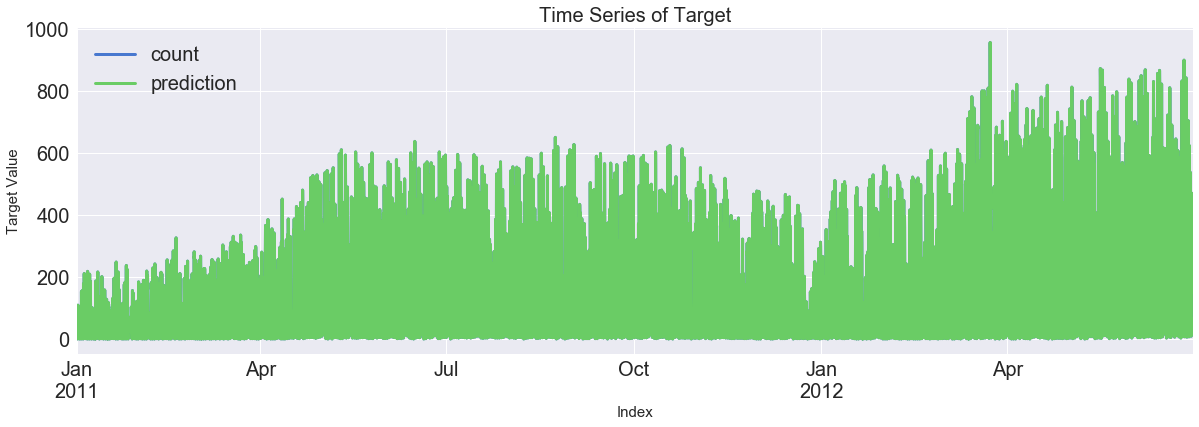

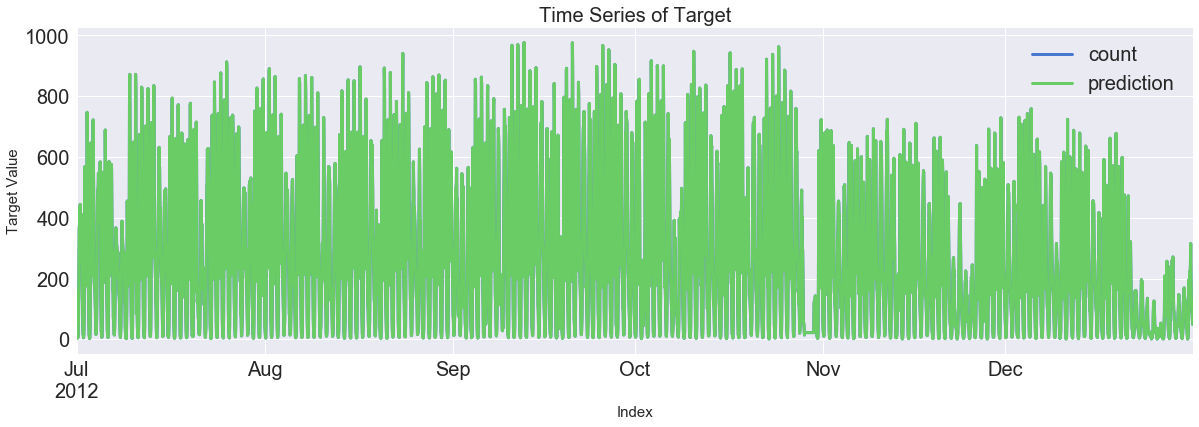

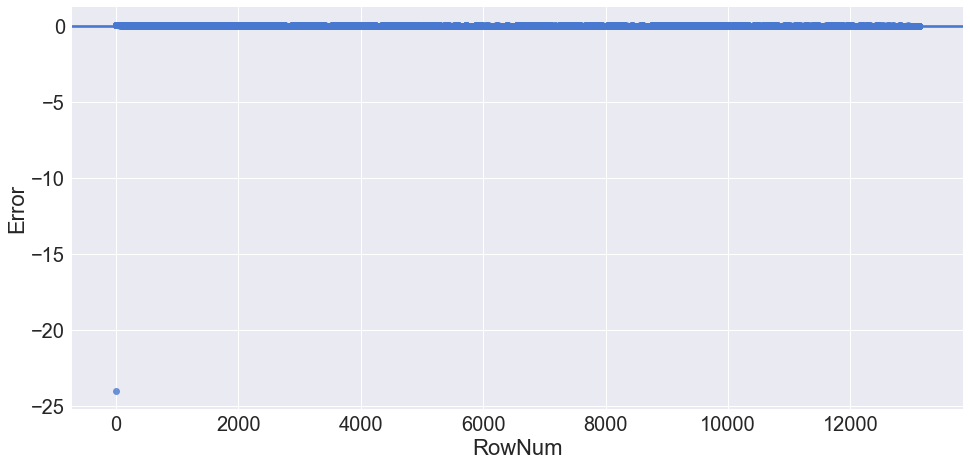

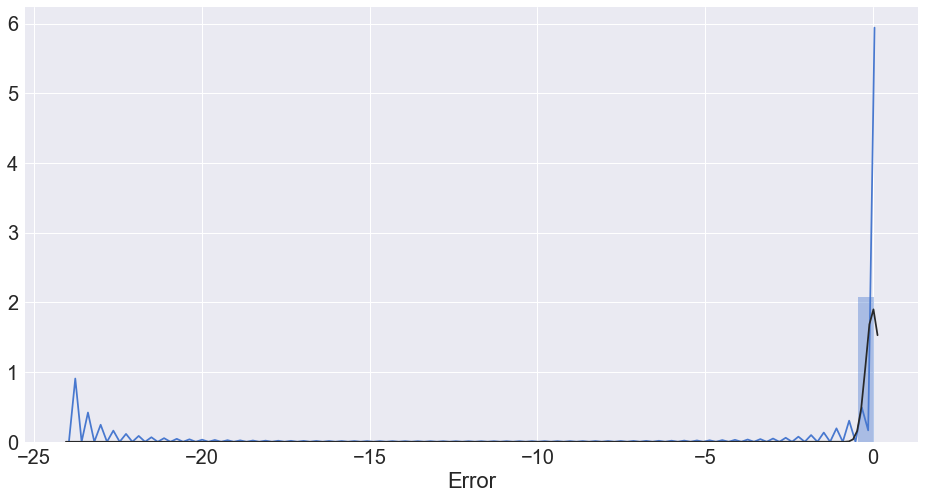

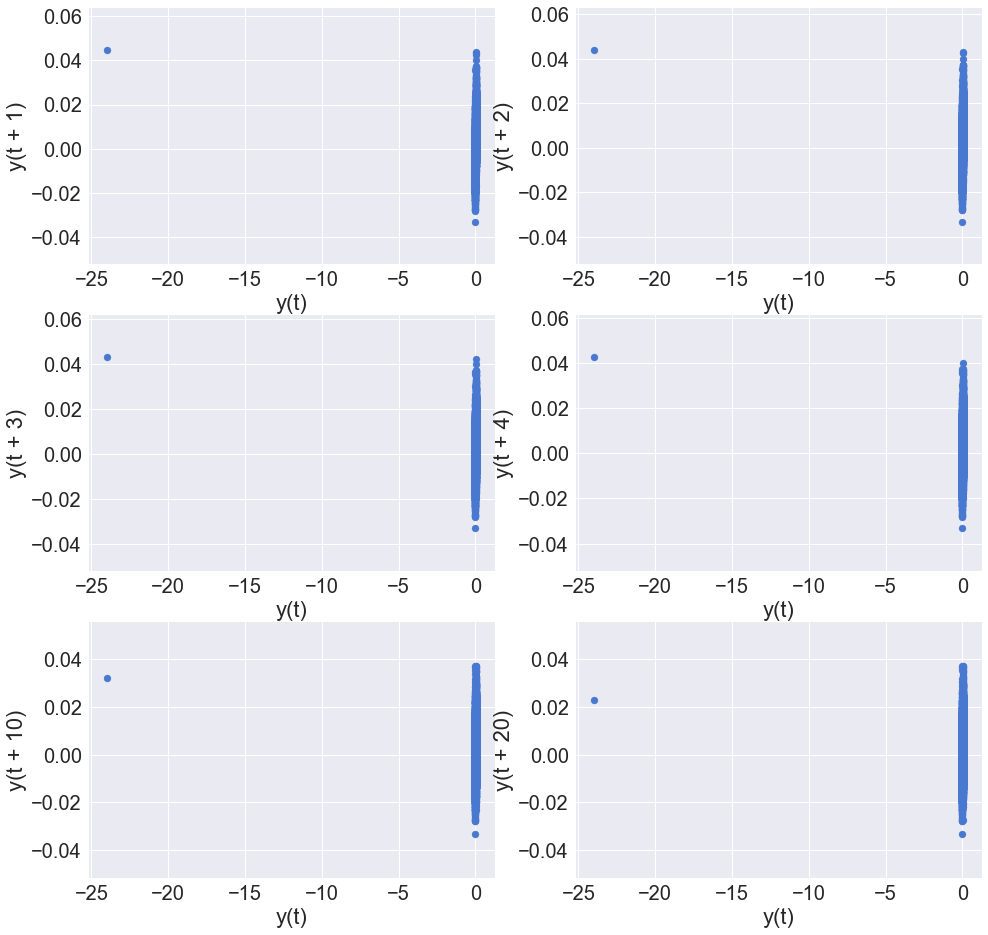

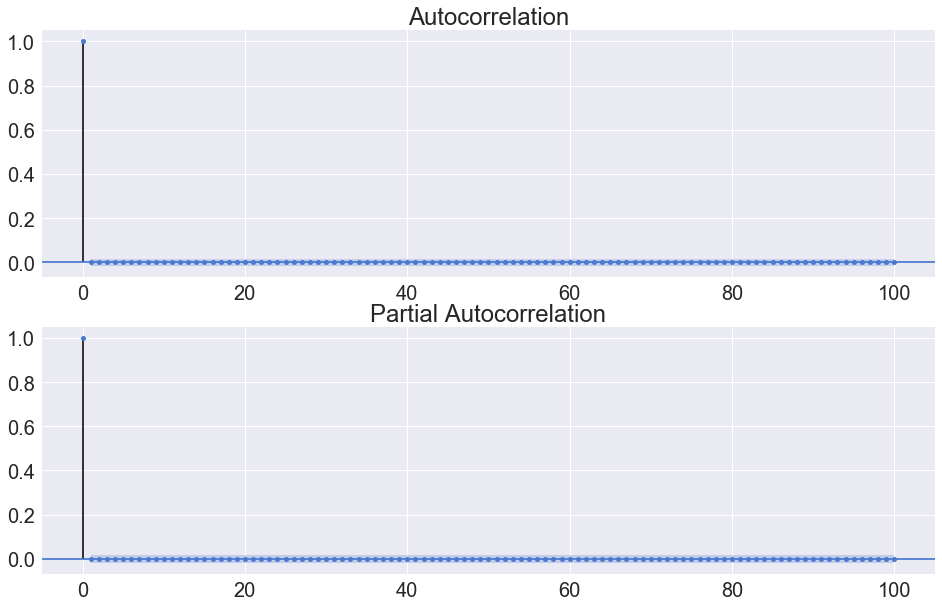

In [5]:
# Data Loading
# location = 'https://raw.githubusercontent.com/cheonbi/DataScience/master/Data/Bike_Sharing_Demand_Full.csv'
location = '../Data/Bike_Sharing_Demand_Full.csv'
raw_all = pd.read_csv(location)

# Feature Engineering
raw_fe = feature_engineering(raw_all)

# Data Split
# Confirm of input and output
Y_colname = ['count']
X_remove = ['datetime', 'DateTime', 'temp_group', 'casual', 'registered']
X_colname = [x for x in raw_fe.columns if x not in Y_colname+X_remove]
X_train_fe, X_test_fe, Y_train_fe, Y_test_fe = datasplit_ts(raw_fe, Y_colname, X_colname, '2012-07-01')

# Applying Base Model
model_fit_reg1_fe = sm.OLS(Y_train_fe, X_train_fe).fit()
display(model_fit_reg1_fe.summary())
model_pred_tr_reg1_fe = model_fit_reg1_fe.predict(X_train_fe).values
model_pred_te_reg1_fe = model_fit_reg1_fe.predict(X_test_fe).values

# Evaluation
Score1_fe, Resid_tr_reg1_fe, Resid_te_reg1_fe = evaluation_trte(Y_train_fe, model_pred_tr_reg1_fe,
                                                                Y_test_fe, model_pred_te_reg1_fe, graph_on=True)
display(Score1_fe)

# Error Analysis
error_analysis(Resid_tr_reg1_fe, ['Error'], X_train_fe, graph_on=True)

In [60]:
display(Score1_rd)
display(Score1_fe)

MAD       MSE   MAPE
Train 103.09 19,360.42 458.48
Test  150.03 43,410.27 316.61

MAD  MSE  MAPE
Train 0.01 0.04  0.06
Test  0.01 0.00  0.03

# Feature Engineering Modified (Applying Reality)

In [6]:
raw_fe.head()

datetime  season  holiday  workingday  weather  \
DateTime                                                                        
2011-01-01 00:00:00 2011-01-01 00:00:00       1        0           0        1   
2011-01-01 01:00:00 2011-01-01 01:00:00       1        0           0        1   
2011-01-01 02:00:00 2011-01-01 02:00:00       1        0           0        1   
2011-01-01 03:00:00 2011-01-01 03:00:00       1        0           0        1   
2011-01-01 04:00:00 2011-01-01 04:00:00       1        0           0        1   

                     temp  atemp  humidity  windspeed  casual  registered  \
DateTime                                                                    
2011-01-01 00:00:00  9.84  14.39        81       0.00       3          13   
2011-01-01 01:00:00  9.02  13.63        80       0.00       8          32   
2011-01-01 02:00:00  9.02  13.63        80       0.00       5          27   
2011-01-01 03:00:00  9.84  14.39        75       0.00       3          10   
2011-01-01 04:00:00  9.84  14.39        75       0.00       0           1   

                     count  count_trend  count_seasonal  count_Day  \
DateTime                                                             
2011-01-01 00:00:00     16        41.06         -134.25      41.04   
2011-01-01 01:00:00     40        41.06         -154.75      41.04   
2011-01-01 02:00:00     32        41.06         -165.27      41.04   
2011-01-01 03:00:00     13        41.06         -176.48      41.04   
2011-01-01 04:00:00      1        41.06         -181.67      41.04   

                     count_Week  count_diff       temp_group  Year  \
DateTime                                                             
2011-01-01 00:00:00       56.11       24.00  (8.856, 12.874]  2011   
2011-01-01 01:00:00       56.11       24.00  (8.856, 12.874]  2011   
2011-01-01 02:00:00       56.11       -8.00  (8.856, 12.874]  2011   
2011-01-01 03:00:00       56.11      -19.00  (8.856, 12.874]  2011   
2011-01-01 04:00:00       56.11      -12.00  (8.856, 12.874]  2011   

                     Quater_ver2  Month  Day  Hour  DayofWeek  count_lag1  \
DateTime                                                                    
2011-01-01 00:00:00            1      1    1     0          5       16.00   
2011-01-01 01:00:00            1      1    1     1          5       16.00   
2011-01-01 02:00:00            1      1    1     2          5       40.00   
2011-01-01 03:00:00            1      1    1     3          5       32.00   
2011-01-01 04:00:00            1      1    1     4          5       13.00   

                     count_lag2  Quater_Dummy_2  Quater_Dummy_3  \
DateTime                                                          
2011-01-01 00:00:00       16.00               0               0   
2011-01-01 01:00:00       16.00               0               0   
2011-01-01 02:00:00       16.00               0               0   
2011-01-01 03:00:00       40.00               0               0   
2011-01-01 04:00:00       32.00               0               0   

                     Quater_Dummy_4  
DateTime                             
2011-01-01 00:00:00               0  
2011-01-01 01:00:00               0  
2011-01-01 02:00:00               0  
2011-01-01 03:00:00               0  
2011-01-01 04:00:00               0

In [7]:
# Test 기간의 FE데이터를 알 수 있을까?
# 1) 과거 패턴이 반복될 것이다
# 2) 하나씩 예측하며 업데이트

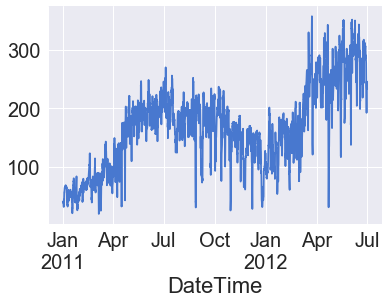

In [10]:
# count_trend
raw_fe.loc[X_train_fe.index, 'count_trend'].plot()
plt.show()

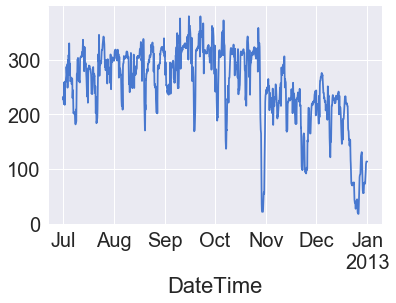

In [11]:
raw_fe.loc[X_test_fe.index, 'count_trend'].plot()
plt.show()

In [12]:
# raw_fe.loc['2012-01-01':'2012-12-31', 'count_trend'] = raw_fe.loc['2011-01-01':'2011-12-31', 'count_trend'].values
# raw_fe.loc['2012-01-01', 'count_trend']

In [13]:
# raw_fe.loc['2012-01-01':'2012-12-31', 'count_trend'].shape, raw_fe.loc['2011-01-01':'2011-12-31', 'count_trend'].shape

In [14]:
# raw_fe.loc['2012-02-29', 'count_trend']
# raw_fe.loc['2011-02-29', 'count_trend']

In [15]:
raw_fe.loc['2012-01-01':'2012-02-28', 'count_trend'] = raw_fe.loc['2011-01-01':'2011-02-28', 'count_trend'].values
raw_fe.loc['2012-03-01':'2012-12-31', 'count_trend'] = raw_fe.loc['2011-03-01':'2011-12-31', 'count_trend'].values
# 2012-02-29??
# raw_fe.loc['2012-02-27':'2012-03-03', 'count_trend']
# raw_fe.loc['2012-02-28':'2012-03-01', 'count_trend']
# raw_fe.loc['2012-02-28 23:00:00', 'count_trend']
# raw_fe.loc['2012-03-01 00:00:00', 'count_trend']
step = (raw_fe.loc['2011-03-01 00:00:00', 'count_trend'] - raw_fe.loc['2011-02-28 23:00:00', 'count_trend'])/25
step_value = np.arange(raw_fe.loc['2011-02-28 23:00:00', 'count_trend']+step, 
                       raw_fe.loc['2011-03-01 00:00:00', 'count_trend'], step)
step_value = step_value[:24]
raw_fe.loc['2012-02-29', 'count_trend'] = step_value

In [16]:
# raw_fe.loc['2012-02-28 22:00:00':'2012-03-01 02:00:00', 'count_trend']

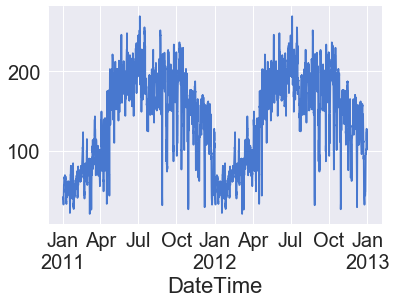

In [17]:
raw_fe['count_trend'].plot()

In [18]:
# count_trend, count_seasonal, count_Day, count_Week, count_diff
### Functionalize
### duplicate previous year values to next one
def feature_engineering_year_duplicated(raw, target):
    raw_fe = raw.copy()
    for col in target:
        raw_fe.loc['2012-01-01':'2012-02-28', col] = raw.loc['2011-01-01':'2011-02-28', col].values
        raw_fe.loc['2012-03-01':'2012-12-31', col] = raw.loc['2011-03-01':'2011-12-31', col].values
        step = (raw.loc['2011-03-01 00:00:00', col] - raw.loc['2011-02-28 23:00:00', col])/25
        step_value = np.arange(raw.loc['2011-02-28 23:00:00', col]+step, raw.loc['2011-03-01 00:00:00', col], step)
        step_value = step_value[:24]
        raw_fe.loc['2012-02-29', col] = step_value
    return raw_fe
target = ['count_trend', 'count_seasonal', 'count_Day', 'count_Week', 'count_diff']
raw_fe = feature_engineering_year_duplicated(raw_fe, target)

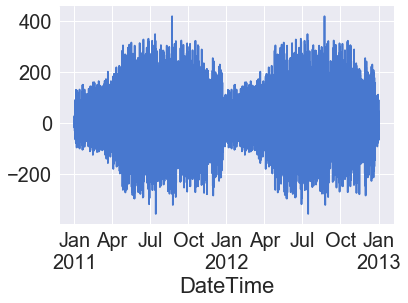

In [19]:
raw_fe['count_diff'].plot()

In [20]:
# count_lag1, count_lag2
raw_fe.head()

datetime  season  holiday  workingday  weather  \
DateTime                                                                        
2011-01-01 00:00:00 2011-01-01 00:00:00       1        0           0        1   
2011-01-01 01:00:00 2011-01-01 01:00:00       1        0           0        1   
2011-01-01 02:00:00 2011-01-01 02:00:00       1        0           0        1   
2011-01-01 03:00:00 2011-01-01 03:00:00       1        0           0        1   
2011-01-01 04:00:00 2011-01-01 04:00:00       1        0           0        1   

                     temp  atemp  humidity  windspeed  casual  registered  \
DateTime                                                                    
2011-01-01 00:00:00  9.84  14.39        81       0.00       3          13   
2011-01-01 01:00:00  9.02  13.63        80       0.00       8          32   
2011-01-01 02:00:00  9.02  13.63        80       0.00       5          27   
2011-01-01 03:00:00  9.84  14.39        75       0.00       3          10   
2011-01-01 04:00:00  9.84  14.39        75       0.00       0           1   

                     count  count_trend  count_seasonal  count_Day  \
DateTime                                                             
2011-01-01 00:00:00     16        41.06         -134.25      41.04   
2011-01-01 01:00:00     40        41.06         -154.75      41.04   
2011-01-01 02:00:00     32        41.06         -165.27      41.04   
2011-01-01 03:00:00     13        41.06         -176.48      41.04   
2011-01-01 04:00:00      1        41.06         -181.67      41.04   

                     count_Week  count_diff       temp_group  Year  \
DateTime                                                             
2011-01-01 00:00:00       56.11       24.00  (8.856, 12.874]  2011   
2011-01-01 01:00:00       56.11       24.00  (8.856, 12.874]  2011   
2011-01-01 02:00:00       56.11       -8.00  (8.856, 12.874]  2011   
2011-01-01 03:00:00       56.11      -19.00  (8.856, 12.874]  2011   
2011-01-01 04:00:00       56.11      -12.00  (8.856, 12.874]  2011   

                     Quater_ver2  Month  Day  Hour  DayofWeek  count_lag1  \
DateTime                                                                    
2011-01-01 00:00:00            1      1    1     0          5       16.00   
2011-01-01 01:00:00            1      1    1     1          5       16.00   
2011-01-01 02:00:00            1      1    1     2          5       40.00   
2011-01-01 03:00:00            1      1    1     3          5       32.00   
2011-01-01 04:00:00            1      1    1     4          5       13.00   

                     count_lag2  Quater_Dummy_2  Quater_Dummy_3  \
DateTime                                                          
2011-01-01 00:00:00       16.00               0               0   
2011-01-01 01:00:00       16.00               0               0   
2011-01-01 02:00:00       16.00               0               0   
2011-01-01 03:00:00       40.00               0               0   
2011-01-01 04:00:00       32.00               0               0   

                     Quater_Dummy_4  
DateTime                             
2011-01-01 00:00:00               0  
2011-01-01 01:00:00               0  
2011-01-01 02:00:00               0  
2011-01-01 03:00:00               0  
2011-01-01 04:00:00               0

In [23]:
X_test_fe['count_lag1'] = Y_test_fe.shift(1).values
X_test_fe['count_lag1'].fillna(method='bfill', inplace=True)
X_test_fe['count_lag2'] = Y_test_fe.shift(2).values
X_test_fe['count_lag2'].fillna(method='bfill', inplace=True)
X_test_fe['count_lag2']

DateTime
2012-07-01 00:00:00   149.00
2012-07-01 01:00:00   149.00
2012-07-01 02:00:00   149.00
2012-07-01 03:00:00    93.00
2012-07-01 04:00:00    90.00
2012-07-01 05:00:00    33.00
2012-07-01 06:00:00     4.00
2012-07-01 07:00:00    10.00
2012-07-01 08:00:00    27.00
2012-07-01 09:00:00    50.00
2012-07-01 10:00:00   142.00
2012-07-01 11:00:00   219.00
2012-07-01 12:00:00   366.00
2012-07-01 13:00:00   377.00
2012-07-01 14:00:00   433.00
2012-07-01 15:00:00   420.00
2012-07-01 16:00:00   444.00
2012-07-01 17:00:00   345.00
2012-07-01 18:00:00   313.00
2012-07-01 19:00:00   413.00
2012-07-01 20:00:00   370.00
2012-07-01 21:00:00   382.00
2012-07-01 22:00:00   332.00
2012-07-01 23:00:00   258.00
2012-07-02 00:00:00   151.00
                       ...  
2012-12-30 23:00:00    47.00
2012-12-31 00:00:00    36.00
2012-12-31 01:00:00    49.00
2012-12-31 02:00:00    34.00
2012-12-31 03:00:00    19.00
2012-12-31 04:00:00    11.00
2012-12-31 05:00:00     1.00
2012-12-31 06:00:00     3.00
2012-

In [24]:
### Functionalize
### modify lagged values of X_test
def feature_engineering_lag_modified(Y_test, X_test, target):
    X_test_lm = X_test.copy()
    for col in target:
        X_test_lm[col] = Y_test.shift(1).values
        X_test_lm[col].fillna(method='bfill', inplace=True)
        X_test_lm[col] = Y_test.shift(2).values
        X_test_lm[col].fillna(method='bfill', inplace=True)
    return X_test_lm
target = ['count_lag1', 'count_lag2']
X_test_fe = feature_engineering_lag_modified(Y_test_fe, X_test_fe, target)

In [26]:
# X_test_fe['count_lag2']

## Result of FEM Data

In [27]:
### Functionalize
### duplicate previous year values to next one
def feature_engineering_year_duplicated(raw, target):
    raw_fe = raw.copy()
    for col in target:
        raw_fe.loc['2012-01-01':'2012-02-28', col] = raw.loc['2011-01-01':'2011-02-28', col].values
        raw_fe.loc['2012-03-01':'2012-12-31', col] = raw.loc['2011-03-01':'2011-12-31', col].values
        step = (raw.loc['2011-03-01 00:00:00', col] - raw.loc['2011-02-28 23:00:00', col])/25
        step_value = np.arange(raw.loc['2011-02-28 23:00:00', col]+step, raw.loc['2011-03-01 00:00:00', col], step)
        step_value = step_value[:24]
        raw_fe.loc['2012-02-29', col] = step_value
    return raw_fe
# target = ['count_trend', 'count_seasonal', 'count_Day', 'count_Week', 'count_diff']
# raw_fe = feature_engineering_year_duplicated(raw_fe, target)

### modify lagged values of X_test
def feature_engineering_lag_modified(Y_test, X_test, target):
    X_test_lm = X_test.copy()
    for col in target:
        X_test_lm[col] = Y_test.shift(1).values
        X_test_lm[col].fillna(method='bfill', inplace=True)
        X_test_lm[col] = Y_test.shift(2).values
        X_test_lm[col].fillna(method='bfill', inplace=True)
    return X_test_lm
# target = ['count_lag1', 'count_lag2']
# X_test_fe = feature_engineering_lag_modified(Y_test_fe, X_test_fe, target)

Train_size: (13128, 29) Test_size: (4416, 29)
X_train: (13128, 24) Y_train: (13128, 1)
X_test: (4416, 24) Y_test: (4416, 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     5658.
Date:                Sun, 03 Mar 2019   Prob (F-statistic):               0.00
Time:                        22:56:07   Log-Likelihood:                -69618.
No. Observations:               13128   AIC:                         1.393e+05
Df Residuals:                   13104   BIC:                         1.395e+05
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
season             2.7535      0.952      2.893      0.004       0.888       4.619
holiday            0.6180      3.170      0.195      0.845      -5.595       6.831
workingday         2.1960      1.544      1.423      0.155      -0.830       5.222
weather           -5.8817      0.780     -7.544      0.000      -7.410      -4.353
temp               0.5622      0.490      1.146      0.252      -0.399       1.523
atemp              0.4042      0.427      0.946      0.344      -0.433       1.242
humidity          -0.0706      0.028     -2.501      0.012      -0.126      -0.015
windspeed         -0.1216      0.057     -2.117      0.034      -0.234      -0.009
count_trend        0.0718      0.024      3.007      0.003       0.025       0.119
count_seasonal     0.1948      0.006     34.600      0.000       0.184       0.206
count_Day          0.1011      0.024      4.190      0.000       0.054       0.148
count_Week        -0.0801      0.026     -3.078      0.002      -0.131      -0.029
count_diff         0.7146      0.007     97.737      0.000       0.700       0.729
Year               0.0004      0.002      0.188      0.851      -0.003       0.004
Quater_ver2        5.6849      0.284     19.988      0.000       5.127       6.242
Month              1.1013      0.566      1.945      0.052      -0.009       2.211
Day               -0.0335      0.049     -0.681      0.496      -0.130       0.063
Hour               0.1185      0.083      1.420      0.156      -0.045       0.282
DayofWeek          0.3611      0.354      1.021      0.307      -0.332       1.055
count_lag1         0.9285      0.006    149.851      0.000       0.916       0.941
count_lag2        -0.1938      0.006    -33.734      0.000      -0.205      -0.183
Quater_Dummy_2    -7.2671      2.213     -3.284      0.001     -11.605      -2.929
Quater_Dummy_3   -21.5188      3.728     -5.773      0.000     -28.825     -14.212
Quater_Dummy_4   -26.7509      5.511     -4.854      0.000     -37.554     -15.948
==============================================================================
Omnibus:                     3715.248   Durbin-Watson:                   1.582
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           115549.958
Skew:                           0.728   Prob(JB):                         0.00
Kurtosis:                      17.461   Cond. No.                     3.22e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.22e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

MAD       MSE   MAPE
Train  27.79  2,364.05  82.11
Test  113.99 26,316.17 133.61

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Stationarity  Normality  Autocorr(lag1)  \
Test Statistics                     -13.45       0.78          572.93   
p-value                               0.00       0.00            0.00   
Alternative                            nan        nan             nan   
Used Lag                             41.00        nan             nan   
Used Observations                13,086.00        nan             nan   
Critical Value(1%)                   -3.43        nan             nan   
Critical Value(5%)                     nan        nan             nan   
Critical Value(10%)                    nan        nan             nan   
Maximum Information Criteria    133,771.72        nan             nan   

                              Autocorr(lag5)  Autocorr(lag10)  \
Test Statistics                       744.23         2,927.28   
p-value                                 0.00             0.00   
Alternative                              nan              nan   
Used Lag                                 nan              nan   
Used Observations                        nan              nan   
Critical Value(1%)                       nan              nan   
Critical Value(5%)                       nan              nan   
Critical Value(10%)                      nan              nan   
Maximum Information Criteria             nan              nan   

                              Autocorr(lag50) Heteroscedasticity  
Test Statistics                      7,390.92          46,108.47  
p-value                                  0.00               0.00  
Alternative                               nan          two-sided  
Used Lag                                  nan                NaN  
Used Observations                         nan                NaN  
Critical Value(1%)                        nan                NaN  
Critical Value(5%)                        nan                NaN  
Critical Value(10%)                       nan                NaN  
Maximum Information Criteria              nan                NaN

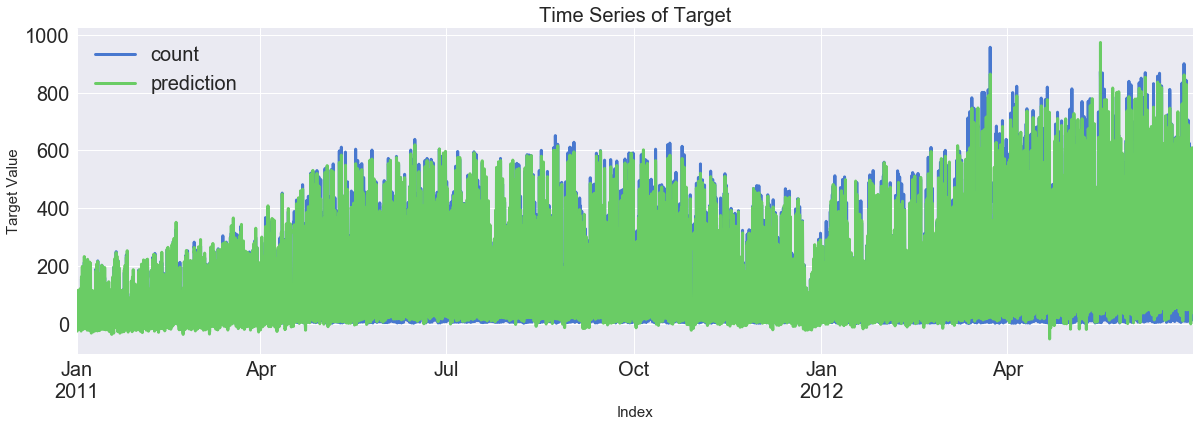

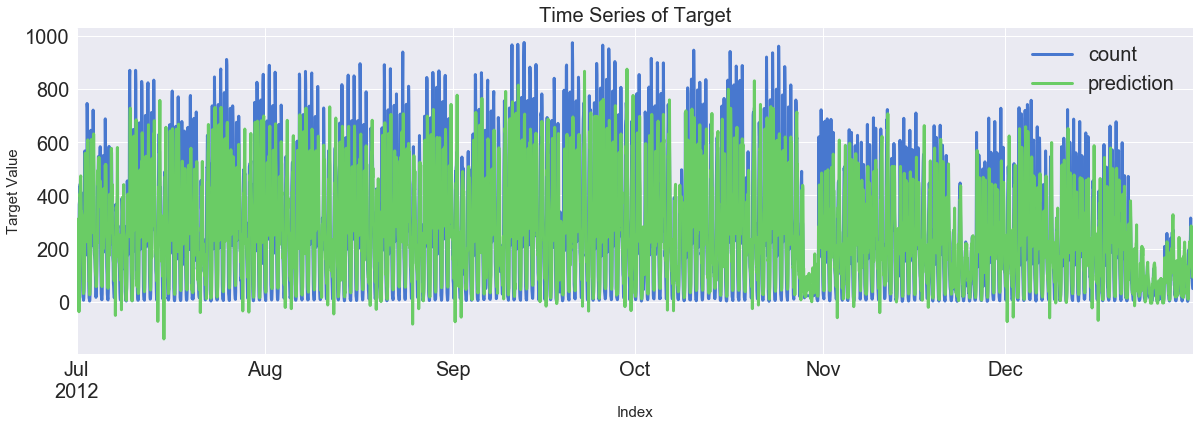

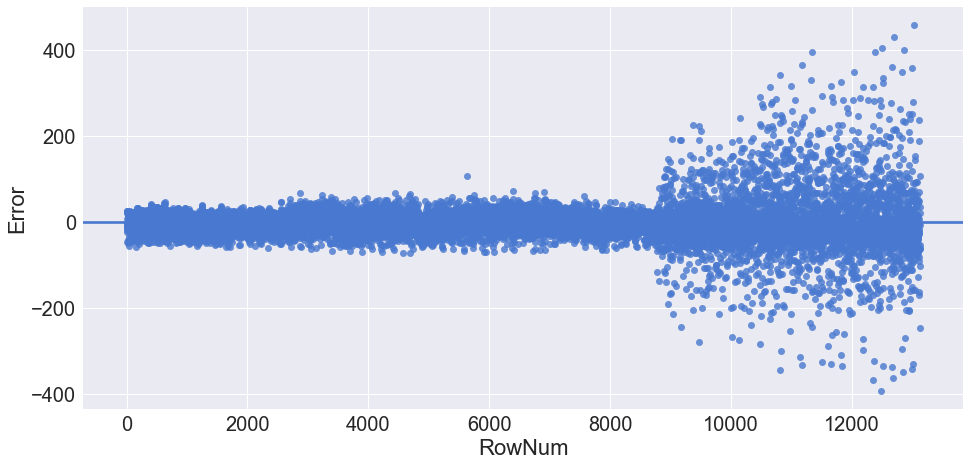

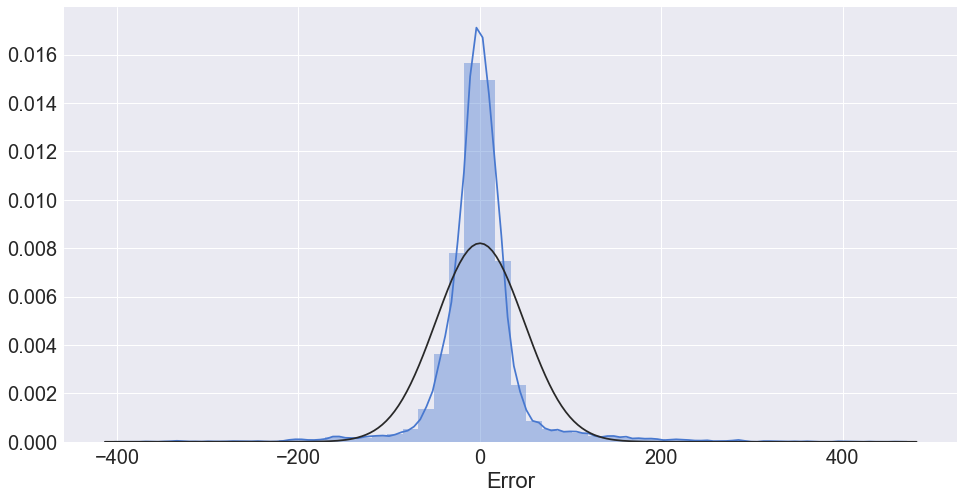

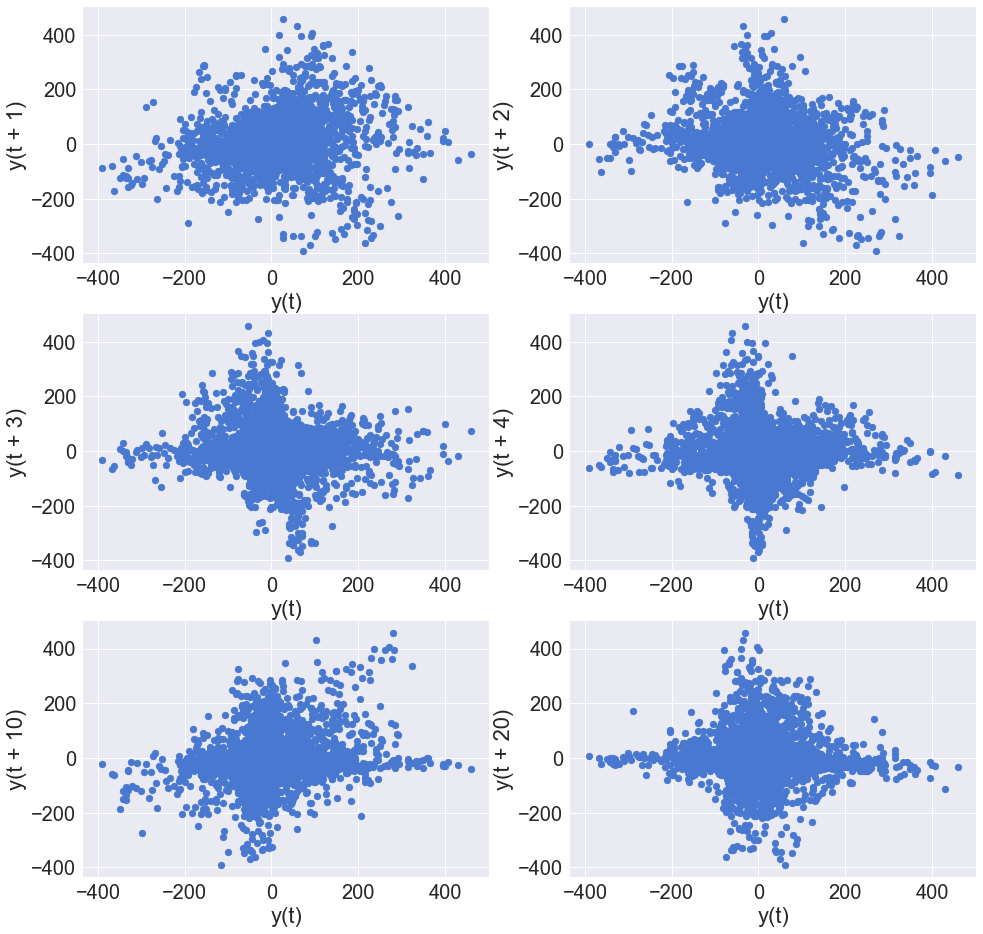

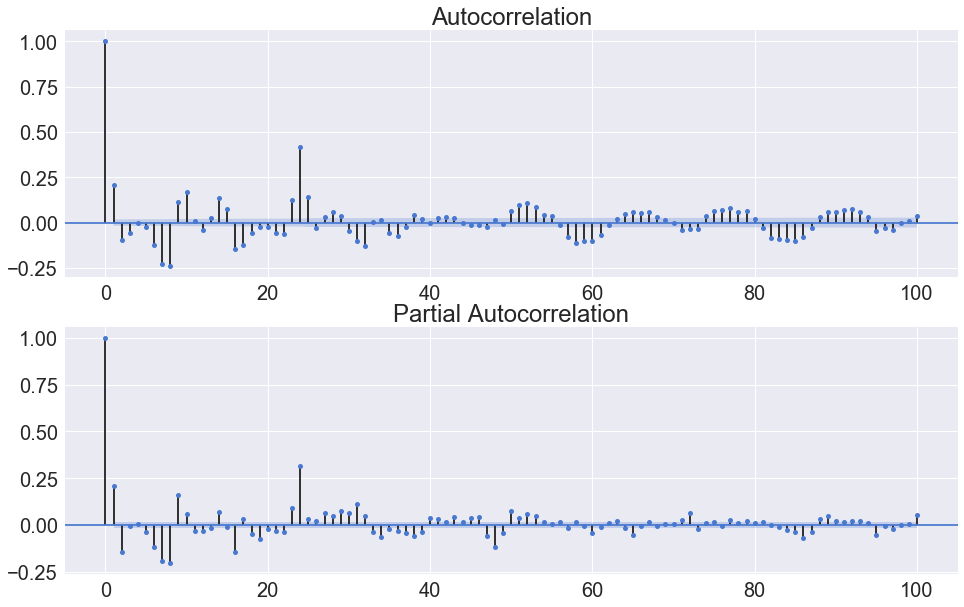

In [28]:
# Data Loading
# location = 'https://raw.githubusercontent.com/cheonbi/DataScience/master/Data/Bike_Sharing_Demand_Full.csv'
location = '../Data/Bike_Sharing_Demand_Full.csv'
raw_all = pd.read_csv(location)

# Feature Engineering
raw_fe = feature_engineering(raw_all)
#####
target = ['count_trend', 'count_seasonal', 'count_Day', 'count_Week', 'count_diff']
raw_fem = feature_engineering_year_duplicated(raw_fe, target)
#####

# Data Split
# Confirm of input and output
Y_colname = ['count']
X_remove = ['datetime', 'DateTime', 'temp_group', 'casual', 'registered']
X_colname = [x for x in raw_fe.columns if x not in Y_colname+X_remove]
X_train_fem, X_test_fem, Y_train_fem, Y_test_fem = datasplit_ts(raw_fem, Y_colname, X_colname, '2012-07-01')
#####
target = ['count_lag1', 'count_lag2']
X_test_fem = feature_engineering_lag_modified(Y_test_fem, X_test_fem, target)
#####

# Applying Base Model
model_fit_reg1_fem = sm.OLS(Y_train_fem, X_train_fem).fit()
display(model_fit_reg1_fem.summary())
model_pred_tr_reg1_fem = model_fit_reg1_fem.predict(X_train_fem).values
model_pred_te_reg1_fem = model_fit_reg1_fem.predict(X_test_fem).values

# Evaluation
Score1_fem, Resid_tr_reg1_fem, Resid_te_reg1_fem = evaluation_trte(Y_train_fem, model_pred_tr_reg1_fem,
                                                                   Y_test_fem, model_pred_te_reg1_fem, graph_on=True)
display(Score1_fem)

# Error Analysis
error_analysis(Resid_tr_reg1_fem, ['Error'], X_train_fem, graph_on=True)

In [29]:
display(Score1_rd)
display(Score1_fe)
display(Score1_fem)

MAD       MSE   MAPE
Train 103.09 19,360.42 458.48
Test  150.03 43,410.27 316.61

MAD  MSE  MAPE
Train 0.01 0.04  0.06
Test  0.01 0.00  0.03

MAD       MSE   MAPE
Train  27.79  2,364.05  82.11
Test  113.99 26,316.17 133.61

# Feature Engineering Modified (Multicolinearity Problem)
- Scaling
- Removing Dependent Variables by Variance Inflation Factor(VIF)
- Removing Dependent Variables by PCA(Principal Component Analysis)

In [30]:
raw_fem.corr().loc[:, ['casual', 'registered', 'count']].style.background_gradient().set_precision(2).set_properties(**{'font-size': '11pt'})
# count_trend, count_seasonal, count_Day, count_Week, count_diff, Hour, count_lag1, count_lag2

In [31]:
# for col in raw_fem.describe().columns:
#     target = raw_fem[col]
# #     figure, axes = plt.subplots(2,1,figsize=(16,10))
# #     sm.graphics.tsa.plot_acf(target, lags=100, use_vlines=True, ax=axes[0], title=col)
# #     sm.graphics.tsa.plot_pacf(target, lags=100, use_vlines=True, ax=axes[1], title=col)  
#     figure, axes = plt.subplots(1,1,figsize=(16,5))
# #     sm.graphics.tsa.plot_acf(target, lags=100, use_vlines=True, ax=axes, title=col)
#     sm.graphics.tsa.plot_pacf(target, lags=100, use_vlines=True, ax=axes, title=col)
# # count_trend, count_seasonal, count_Day, count_Week, count_diff, Hour, DayofWeek, count_lag1, count_lag2

In [32]:
raw_fem.corr().loc[X_colname, X_colname].style.background_gradient().set_precision(2).set_properties(**{'font-size': '11pt'})

In [33]:
X_formula = 'scale(season)+scale(holiday)+scale(workingday)+scale(weather)+scale(temp)+scale(atemp)+scale(humidity)+scale(windspeed)+scale(count_trend)+scale(count_seasonal)+scale(count_Day)+scale(count_Week)+scale(count_diff)+scale(Year)+scale(Quater_ver2)+scale(Month)+scale(Day)+scale(Hour)+scale(DayofWeek)+scale(count_lag1)+scale(count_lag2)+scale(Quater_Dummy_2)+scale(Quater_Dummy_3)+scale(Quater_Dummy_4)'
# dmatrix(X_formula, X_train_fem, return_type='dataframe').describe().T
X_temp = dmatrix(X_formula, pd.concat([X_train_fem, X_test_fem], axis=0), return_type='dataframe') 
X_train_femm = X_temp[X_temp.index < '2012-07-01']
X_test_femm = X_temp[X_temp.index >= '2012-07-01']

## Result of FEMM Data

In [50]:
# dmatrix(X_formula, X_test_fem, return_type='dataframe')

Train_size: (13128, 29) Test_size: (4416, 29)
X_train: (13128, 24) Y_train: (13128, 1)
X_test: (4416, 24) Y_test: (4416, 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     5658.
Date:                Sun, 03 Mar 2019   Prob (F-statistic):               0.00
Time:                        23:12:06   Log-Likelihood:                -69618.
No. Observations:               13128   AIC:                         1.393e+05
Df Residuals:                   13104   BIC:                         1.395e+05
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               187.5346      0.525    357.319      0.000     186.506     188.563
scale(season)             3.0566      1.057      2.893      0.004       0.986       5.127
scale(holiday)            0.1050      0.539      0.195      0.845      -0.951       1.161
scale(workingday)         1.0218      0.718      1.423      0.155      -0.386       2.430
scale(weather)           -3.8132      0.505     -7.544      0.000      -4.804      -2.822
scale(temp)               4.4510      3.882      1.146      0.252      -3.159      12.061
scale(atemp)              3.4855      3.685      0.946      0.344      -3.737      10.708
scale(humidity)          -1.3643      0.545     -2.501      0.012      -2.433      -0.295
scale(windspeed)         -1.0088      0.476     -2.117      0.034      -1.943      -0.075
scale(count_trend)        4.0826      1.358      3.007      0.003       1.421       6.744
scale(count_seasonal)    25.0341      0.724     34.600      0.000      23.616      26.452
scale(count_Day)          5.7628      1.375      4.190      0.000       3.067       8.459
scale(count_Week)        -4.0969      1.331     -3.078      0.002      -6.706      -1.488
scale(count_diff)        53.7018      0.549     97.737      0.000      52.625      54.779
scale(Year)               9.1567      0.849     10.782      0.000       7.492      10.821
scale(Quater_ver2)        2.5332      0.950      2.667      0.008       0.671       4.395
scale(Month)              3.7991      1.954      1.945      0.052      -0.030       7.628
scale(Day)               -0.2944      0.432     -0.681      0.496      -1.141       0.552
scale(Hour)               0.8228      0.580      1.420      0.156      -0.313       1.959
scale(DayofWeek)          0.7242      0.710      1.021      0.307      -0.667       2.115
scale(count_lag1)       168.3768      1.124    149.851      0.000     166.174     170.579
scale(count_lag2)       -35.1501      1.042    -33.734      0.000     -37.193     -33.108
scale(Quater_Dummy_2)    -1.1627      0.824     -1.411      0.158      -2.778       0.452
scale(Quater_Dummy_3)    -5.3652      1.302     -4.121      0.000      -7.917      -2.813
scale(Quater_Dummy_4)    -5.6489      1.881     -3.004      0.003      -9.335      -1.962
==============================================================================
Omnibus:                     3715.248   Durbin-Watson:                   1.582
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           115549.958
Skew:                           0.728   Prob(JB):                         0.00
Kurtosis:                      17.461   Cond. No.                     1.93e+15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correct

MAD       MSE   MAPE
Train  27.79  2,364.05  82.11
Test  113.99 26,316.17 133.61

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Stationarity  Normality  Autocorr(lag1)  \
Test Statistics                     -13.45       0.78          572.93   
p-value                               0.00       0.00            0.00   
Alternative                            nan        nan             nan   
Used Lag                             41.00        nan             nan   
Used Observations                13,086.00        nan             nan   
Critical Value(1%)                   -3.43        nan             nan   
Critical Value(5%)                     nan        nan             nan   
Critical Value(10%)                    nan        nan             nan   
Maximum Information Criteria    133,771.72        nan             nan   

                              Autocorr(lag5)  Autocorr(lag10)  \
Test Statistics                       744.23         2,927.28   
p-value                                 0.00             0.00   
Alternative                              nan              nan   
Used Lag                                 nan              nan   
Used Observations                        nan              nan   
Critical Value(1%)                       nan              nan   
Critical Value(5%)                       nan              nan   
Critical Value(10%)                      nan              nan   
Maximum Information Criteria             nan              nan   

                              Autocorr(lag50) Heteroscedasticity  
Test Statistics                      7,390.92          46,116.66  
p-value                                  0.00               0.00  
Alternative                               nan          two-sided  
Used Lag                                  nan                NaN  
Used Observations                         nan                NaN  
Critical Value(1%)                        nan                NaN  
Critical Value(5%)                        nan                NaN  
Critical Value(10%)                       nan                NaN  
Maximum Information Criteria              nan                NaN

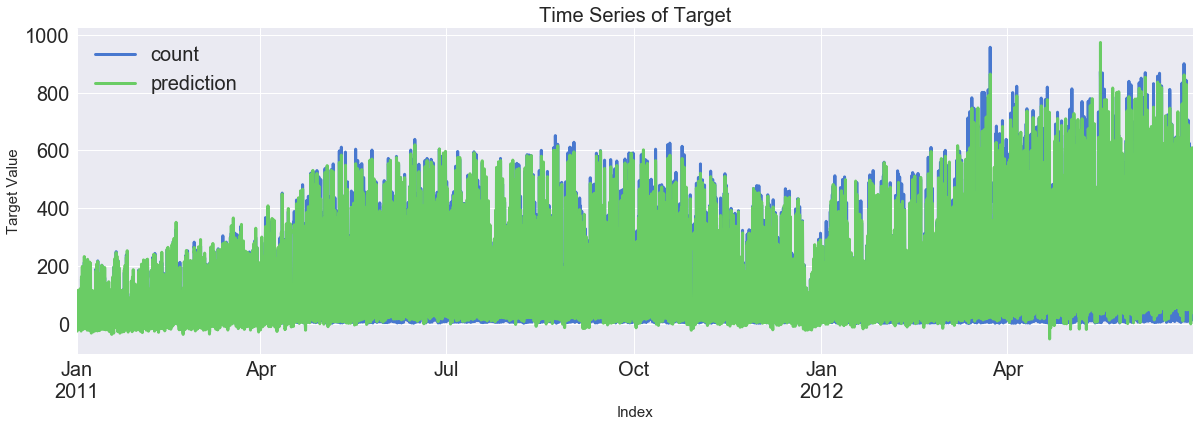

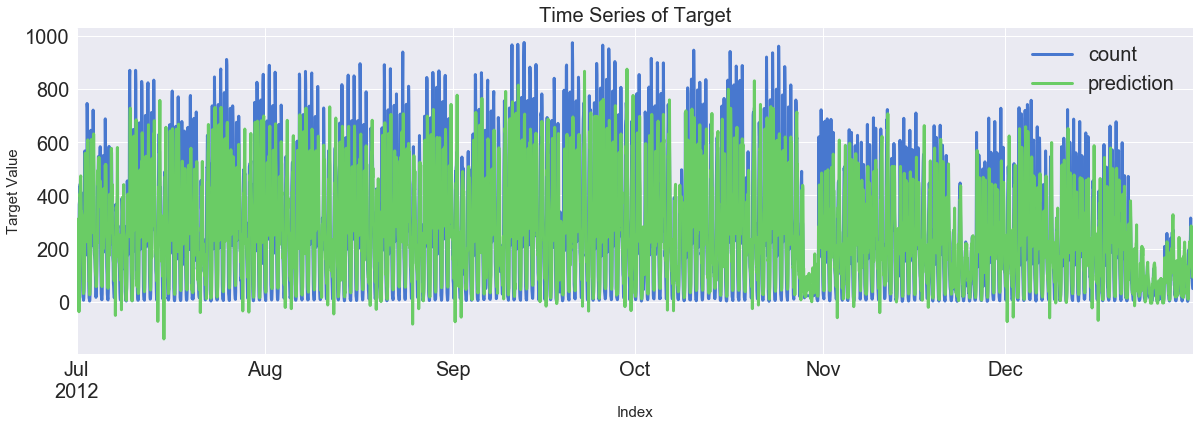

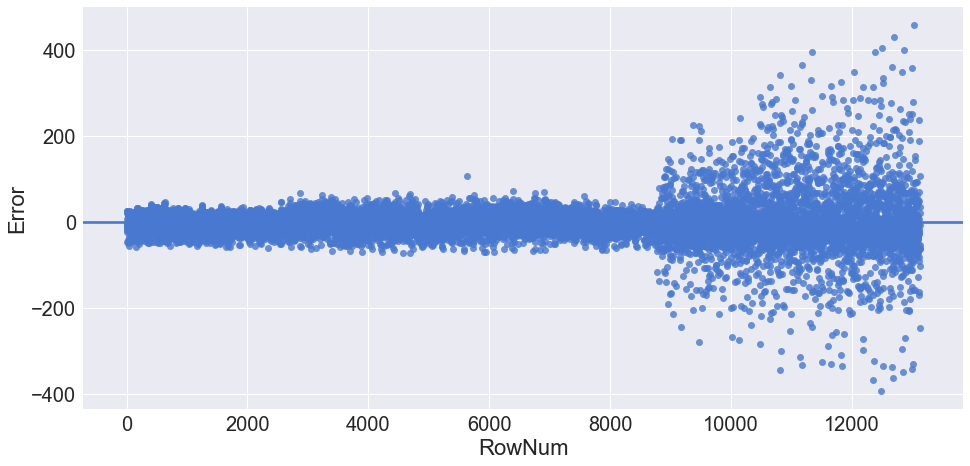

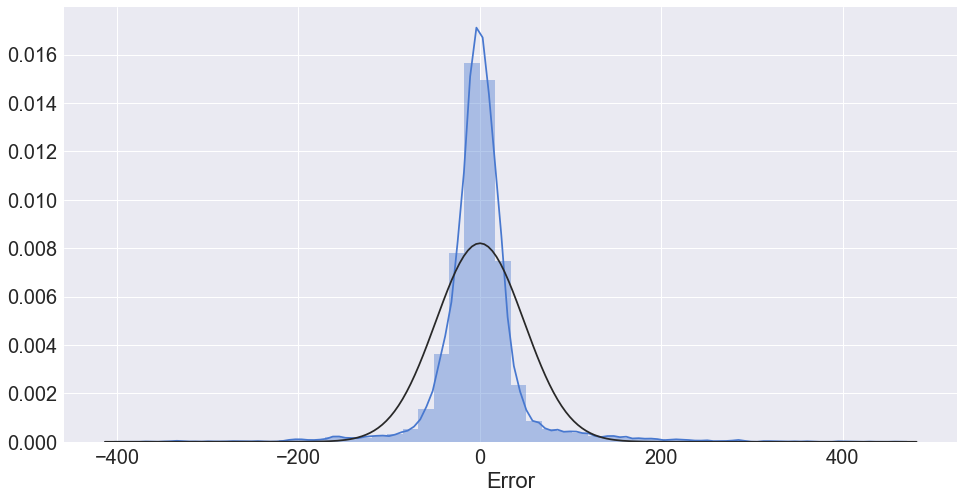

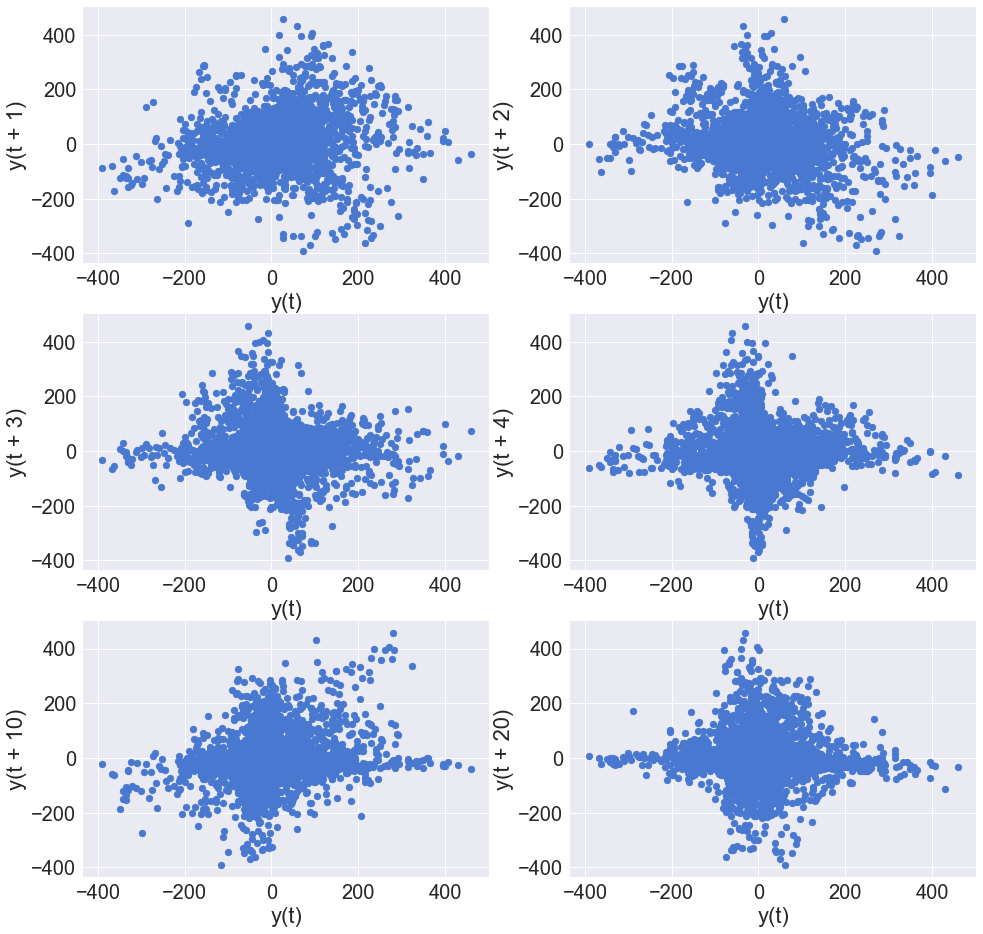

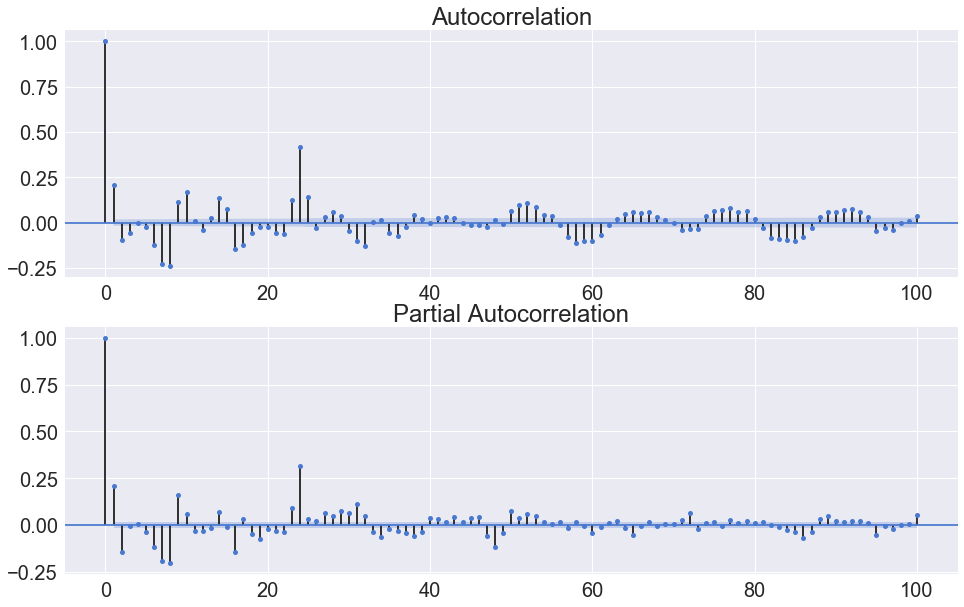

In [53]:
# Data Loading
# location = 'https://raw.githubusercontent.com/cheonbi/DataScience/master/Data/Bike_Sharing_Demand_Full.csv'
location = '../Data/Bike_Sharing_Demand_Full.csv'
raw_all = pd.read_csv(location)

# Feature Engineering
raw_fe = feature_engineering(raw_all)
#####
target = ['count_trend', 'count_seasonal', 'count_Day', 'count_Week', 'count_diff']
raw_fem = feature_engineering_year_duplicated(raw_fe, target)
#####

# Data Split
# Confirm of input and output
Y_colname = ['count']
X_remove = ['datetime', 'DateTime', 'temp_group', 'casual', 'registered']
X_colname = [x for x in raw_fe.columns if x not in Y_colname+X_remove]
X_train_fem, X_test_fem, Y_train_fem, Y_test_fem = datasplit_ts(raw_fem, Y_colname, X_colname, '2012-07-01')
#####
target = ['count_lag1', 'count_lag2']
X_test_fem = feature_engineering_lag_modified(Y_test_fem, X_test_fem, target)
#####
X_formula = 'scale(season)+scale(holiday)+scale(workingday)+scale(weather)+scale(temp)+scale(atemp)+scale(humidity)+scale(windspeed)+scale(count_trend)+scale(count_seasonal)+scale(count_Day)+scale(count_Week)+scale(count_diff)+scale(Year)+scale(Quater_ver2)+scale(Month)+scale(Day)+scale(Hour)+scale(DayofWeek)+scale(count_lag1)+scale(count_lag2)+scale(Quater_Dummy_2)+scale(Quater_Dummy_3)+scale(Quater_Dummy_4)'
X_temp = dmatrix(X_formula, pd.concat([X_train_fem, X_test_fem], axis=0), return_type='dataframe') 
X_train_femm = X_temp[X_temp.index < '2012-07-01']
X_test_femm = X_temp[X_temp.index >= '2012-07-01']
Y_train_femm = Y_train_fem.copy()
Y_test_femm = Y_test_fem.copy()
#####

# Applying Base Model
model_fit_reg1_femm = sm.OLS(Y_train_femm, X_train_femm).fit()
display(model_fit_reg1_femm.summary())
model_pred_tr_reg1_femm = model_fit_reg1_femm.predict(X_train_femm).values
model_pred_te_reg1_femm = model_fit_reg1_femm.predict(X_test_femm).values

# Evaluation
Score1_femm, Resid_tr_reg1_femm, Resid_te_reg1_femm = evaluation_trte(Y_train_femm, model_pred_tr_reg1_femm,
                                                                   Y_test_femm, model_pred_te_reg1_femm, graph_on=True)
display(Score1_femm)

# Error Analysis
error_analysis(Resid_tr_reg1_femm, ['Error'], X_train_femm, graph_on=True)

In [54]:
display(Score1_rd)
display(Score1_fe)
display(Score1_fem)
display(Score1_femm)

MAD       MSE   MAPE
Train 103.09 19,360.42 458.48
Test  150.03 43,410.27 316.61

MAD  MSE  MAPE
Train 0.01 0.04  0.06
Test  0.01 0.00  0.03

MAD       MSE   MAPE
Train  27.79  2,364.05  82.11
Test  113.99 26,316.17 133.61

MAD       MSE   MAPE
Train  27.79  2,364.05  82.11
Test  113.99 26,316.17 133.61

In [83]:
raw_fe[vif.sort_values(by='VIF_Factor', ascending=True)['Feature'][:13].values].head()

Day  windspeed  weather  holiday  humidity  Hour  \
DateTime                                                                
2011-01-01 00:00:00    1       0.00        1        0        81     0   
2011-01-01 01:00:00    1       0.00        1        0        80     1   
2011-01-01 02:00:00    1       0.00        1        0        80     2   
2011-01-01 03:00:00    1       0.00        1        0        75     3   
2011-01-01 04:00:00    1       0.00        1        0        75     4   

                     count_diff  DayofWeek  workingday  count_seasonal  \
DateTime                                                                 
2011-01-01 00:00:00       24.00          5           0         -134.25   
2011-01-01 01:00:00       24.00          5           0         -154.75   
2011-01-01 02:00:00       -8.00          5           0         -165.27   
2011-01-01 03:00:00      -19.00          5           0         -176.48   
2011-01-01 04:00:00      -12.00          5           0         -181.67   

                     count_lag2  count_lag1  season  
DateTime                                             
2011-01-01 00:00:00       16.00       16.00       1  
2011-01-01 01:00:00       16.00       16.00       1  
2011-01-01 02:00:00       16.00       40.00       1  
2011-01-01 03:00:00       40.00       32.00       1  
2011-01-01 04:00:00       32.00       13.00       1

In [84]:
vif = pd.DataFrame()
vif['VIF_Factor'] = [variance_inflation_factor(X_train_femm.values, i) 
                     for i in range(X_train_femm.shape[1])]
vif['Feature'] = X_train_femm.columns
vif.sort_values(by='VIF_Factor', ascending=True)

VIF_Factor                Feature
17          1.03             scale(Day)
8           1.30       scale(windspeed)
4           1.45         scale(weather)
2           1.56         scale(holiday)
13          1.56      scale(count_diff)
7           1.77        scale(humidity)
18          1.86            scale(Hour)
19          2.78       scale(DayofWeek)
3           2.85      scale(workingday)
10          2.90  scale(count_seasonal)
21          4.73      scale(count_lag2)
20          5.50      scale(count_lag1)
1           5.57          scale(season)
12         10.97      scale(count_Week)
9          10.97     scale(count_trend)
11         11.24       scale(count_Day)
16         19.44           scale(Month)
6          74.94           scale(atemp)
5          82.62            scale(temp)
0  67,306,993.73              Intercept
14           inf            scale(Year)
23           inf  scale(Quater_Dummy_3)
22           inf  scale(Quater_Dummy_2)
15           inf     scale(Quater_ver2)
24           inf  scale(Quater_Dummy_4)

In [107]:
### Functionalize
def X_colname_byVIF(X_train, num_variables):
    vif = pd.DataFrame()
    vif['VIF_Factor'] = [variance_inflation_factor(X_train.values, i) 
                         for i in range(X_train.shape[1])]
    vif['Feature'] = X_train.columns
    X_colname_vif = vif.sort_values(by='VIF_Factor', ascending=True)['Feature'][:num_variables].values
    return X_colname_vif
X_colname_vif = X_colname_byVIF(X_train_femm, 30)
X_colname_vif

array(['scale(Day)', 'scale(windspeed)', 'scale(weather)',
       'scale(count_diff)', 'scale(holiday)', 'scale(humidity)',
       'scale(Hour)', 'scale(season)', 'scale(count_seasonal)',
       'scale(DayofWeek)', 'scale(workingday)', 'scale(count_lag2)',
       'scale(count_lag1)', 'scale(count_trend)', 'scale(count_Week)'],
      dtype=object)

Train_size: (13128, 29) Test_size: (4416, 29)
X_train: (13128, 24) Y_train: (13128, 1)
X_test: (4416, 24) Y_test: (4416, 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     5658.
Date:                Mon, 04 Mar 2019   Prob (F-statistic):               0.00
Time:                        00:23:52   Log-Likelihood:                -69618.
No. Observations:               13128   AIC:                         1.393e+05
Df Residuals:                   13104   BIC:                         1.395e+05
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               187.5346      0.525    357.319      0.000     186.506     188.563
scale(season)             3.0566      1.057      2.893      0.004       0.986       5.127
scale(holiday)            0.1050      0.539      0.195      0.845      -0.951       1.161
scale(workingday)         1.0218      0.718      1.423      0.155      -0.386       2.430
scale(weather)           -3.8132      0.505     -7.544      0.000      -4.804      -2.822
scale(temp)               4.4510      3.882      1.146      0.252      -3.159      12.061
scale(atemp)              3.4855      3.685      0.946      0.344      -3.737      10.708
scale(humidity)          -1.3643      0.545     -2.501      0.012      -2.433      -0.295
scale(windspeed)         -1.0088      0.476     -2.117      0.034      -1.943      -0.075
scale(count_trend)        4.0826      1.358      3.007      0.003       1.421       6.744
scale(count_seasonal)    25.0341      0.724     34.600      0.000      23.616      26.452
scale(count_Day)          5.7628      1.375      4.190      0.000       3.067       8.459
scale(count_Week)        -4.0969      1.331     -3.078      0.002      -6.706      -1.488
scale(count_diff)        53.7018      0.549     97.737      0.000      52.625      54.779
scale(Year)               9.1567      0.849     10.782      0.000       7.492      10.821
scale(Quater_ver2)        2.5332      0.950      2.667      0.008       0.671       4.395
scale(Month)              3.7991      1.954      1.945      0.052      -0.030       7.628
scale(Day)               -0.2944      0.432     -0.681      0.496      -1.141       0.552
scale(Hour)               0.8228      0.580      1.420      0.156      -0.313       1.959
scale(DayofWeek)          0.7242      0.710      1.021      0.307      -0.667       2.115
scale(count_lag1)       168.3768      1.124    149.851      0.000     166.174     170.579
scale(count_lag2)       -35.1501      1.042    -33.734      0.000     -37.193     -33.108
scale(Quater_Dummy_2)    -1.1627      0.824     -1.411      0.158      -2.778       0.452
scale(Quater_Dummy_3)    -5.3652      1.302     -4.121      0.000      -7.917      -2.813
scale(Quater_Dummy_4)    -5.6489      1.881     -3.004      0.003      -9.335      -1.962
==============================================================================
Omnibus:                     3715.248   Durbin-Watson:                   1.582
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           115549.958
Skew:                           0.728   Prob(JB):                         0.00
Kurtosis:                      17.461   Cond. No.                     1.93e+15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correct

MAD       MSE   MAPE
Train  27.79  2,364.05  82.11
Test  113.99 26,316.17 133.61

Stationarity  Normality  Autocorr(lag1)  \
Test Statistics                     -13.45       0.78          572.93   
p-value                               0.00       0.00            0.00   
Alternative                            nan        nan             nan   
Used Lag                             41.00        nan             nan   
Used Observations                13,086.00        nan             nan   
Critical Value(1%)                   -3.43        nan             nan   
Critical Value(5%)                     nan        nan             nan   
Critical Value(10%)                    nan        nan             nan   
Maximum Information Criteria    133,771.72        nan             nan   

                              Autocorr(lag5)  Autocorr(lag10)  \
Test Statistics                       744.23         2,927.28   
p-value                                 0.00             0.00   
Alternative                              nan              nan   
Used Lag                                 nan              nan   
Used Observations                        nan              nan   
Critical Value(1%)                       nan              nan   
Critical Value(5%)                       nan              nan   
Critical Value(10%)                      nan              nan   
Maximum Information Criteria             nan              nan   

                              Autocorr(lag50) Heteroscedasticity  
Test Statistics                      7,390.92          46,116.66  
p-value                                  0.00               0.00  
Alternative                               nan          two-sided  
Used Lag                                  nan                NaN  
Used Observations                         nan                NaN  
Critical Value(1%)                        nan                NaN  
Critical Value(5%)                        nan                NaN  
Critical Value(10%)                       nan                NaN  
Maximum Information Criteria              nan                NaN

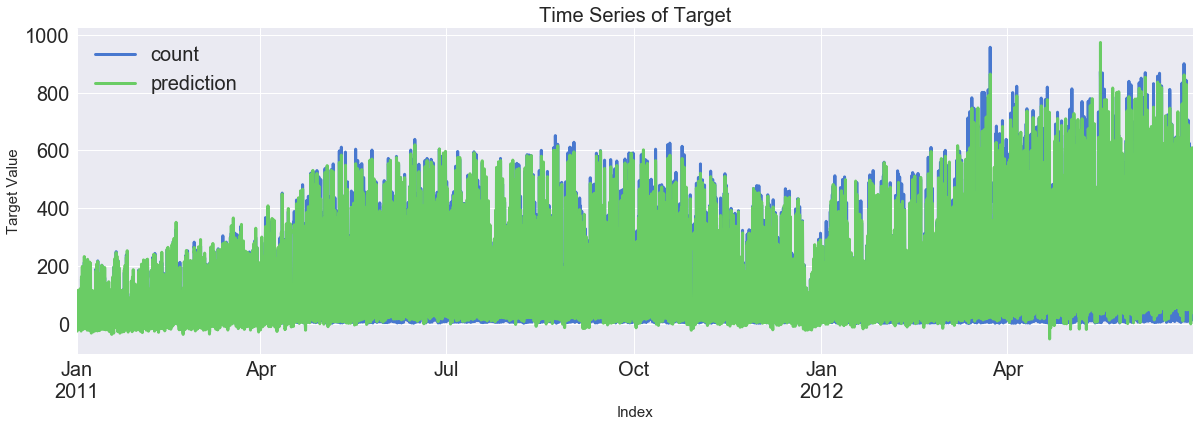

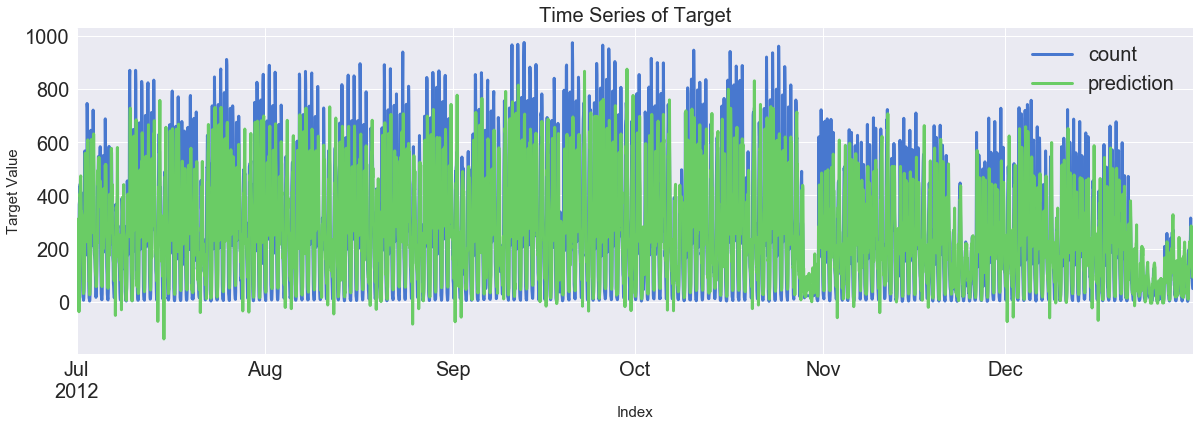

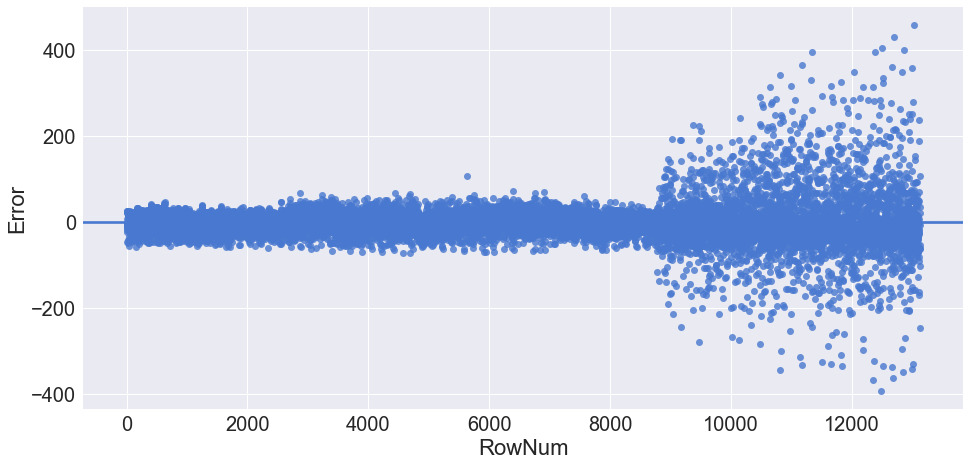

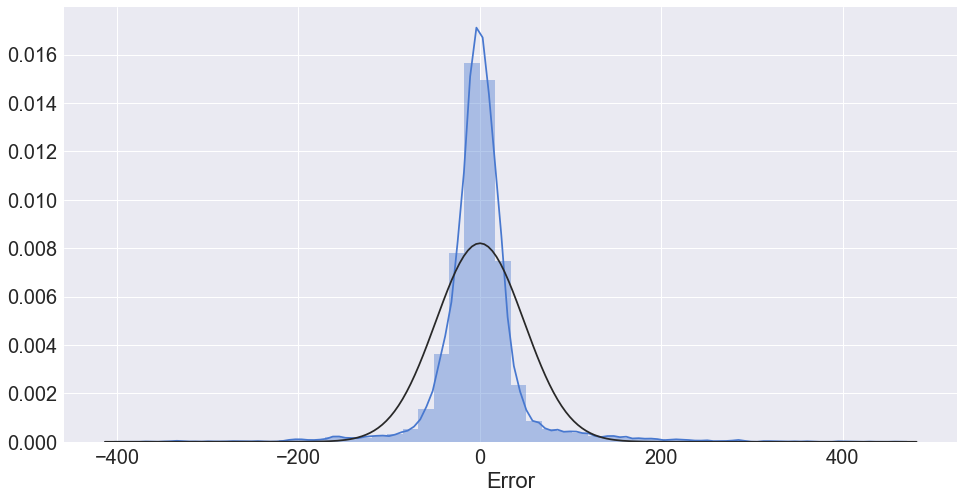

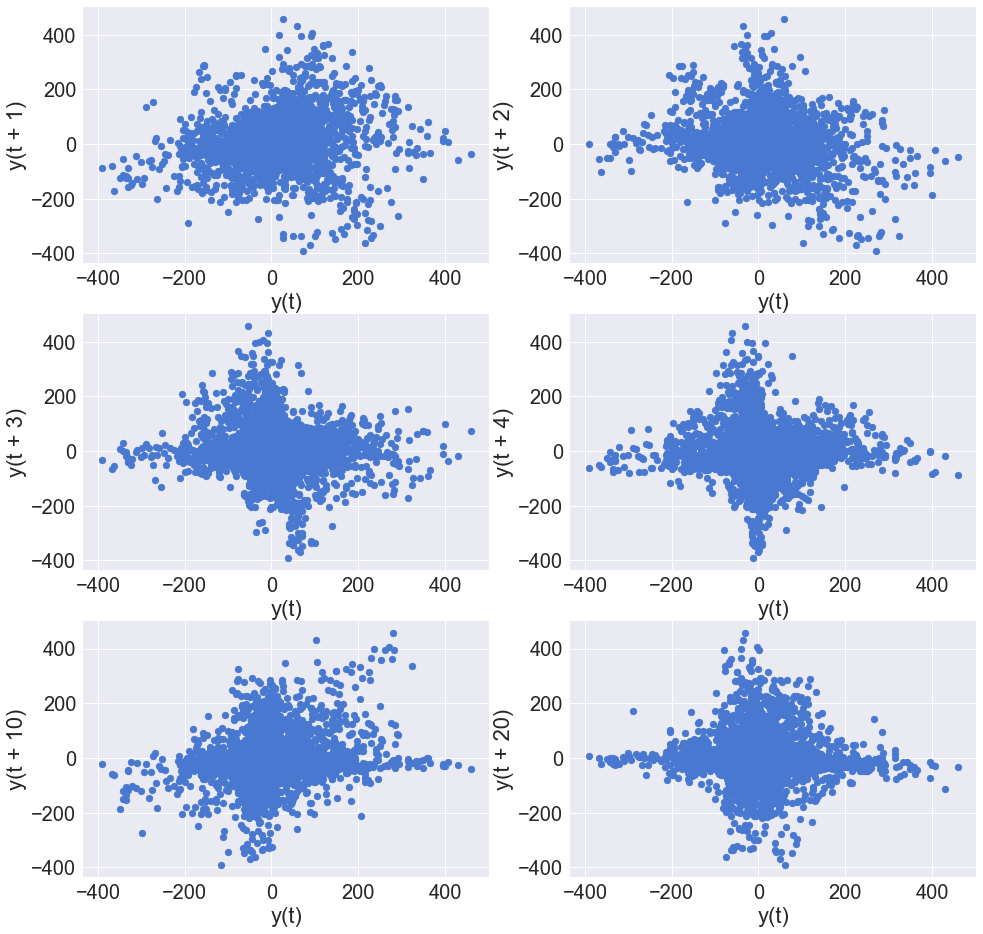

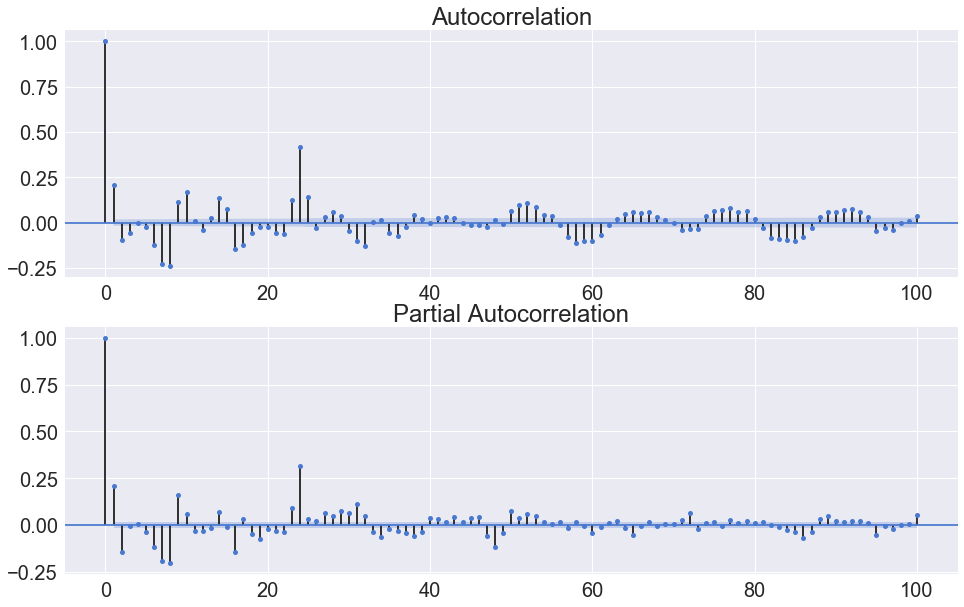

In [109]:
# Data Loading
# location = 'https://raw.githubusercontent.com/cheonbi/DataScience/master/Data/Bike_Sharing_Demand_Full.csv'
location = '../Data/Bike_Sharing_Demand_Full.csv'
raw_all = pd.read_csv(location)

# Feature Engineering
raw_fe = feature_engineering(raw_all)
#####
target = ['count_trend', 'count_seasonal', 'count_Day', 'count_Week', 'count_diff']
raw_fem = feature_engineering_year_duplicated(raw_fe, target)
#####

# Data Split
# Confirm of input and output
Y_colname = ['count']
X_remove = ['datetime', 'DateTime', 'temp_group', 'casual', 'registered']
X_colname = [x for x in raw_fe.columns if x not in Y_colname+X_remove]
X_train_fem, X_test_fem, Y_train_fem, Y_test_fem = datasplit_ts(raw_fem, Y_colname, X_colname, '2012-07-01')
#####
target = ['count_lag1', 'count_lag2']
X_test_fem = feature_engineering_lag_modified(Y_test_fem, X_test_fem, target)
#####
X_formula = 'scale(season)+scale(holiday)+scale(workingday)+scale(weather)+scale(temp)+scale(atemp)+scale(humidity)+scale(windspeed)+scale(count_trend)+scale(count_seasonal)+scale(count_Day)+scale(count_Week)+scale(count_diff)+scale(Year)+scale(Quater_ver2)+scale(Month)+scale(Day)+scale(Hour)+scale(DayofWeek)+scale(count_lag1)+scale(count_lag2)+scale(Quater_Dummy_2)+scale(Quater_Dummy_3)+scale(Quater_Dummy_4)'
X_temp = dmatrix(X_formula, pd.concat([X_train_fem, X_test_fem], axis=0), return_type='dataframe') 
# X_train_femm = X_temp.loc[X_temp.index < '2012-07-01', X_colname_vif]
# X_test_femm = X_temp.loc[X_temp.index >= '2012-07-01', X_colname_vif]
X_train_femm = X_temp[X_temp.index < '2012-07-01']
X_test_femm = X_temp[X_temp.index >= '2012-07-01']
Y_train_femm = Y_train_fem.copy()
Y_test_femm = Y_test_fem.copy()
#####

# Applying Base Model
model_fit_reg1_femm = sm.OLS(Y_train_femm, X_train_femm).fit()
display(model_fit_reg1_femm.summary())
model_pred_tr_reg1_femm = model_fit_reg1_femm.predict(X_train_femm).values
model_pred_te_reg1_femm = model_fit_reg1_femm.predict(X_test_femm).values

# Evaluation
Score1_femm, Resid_tr_reg1_femm, Resid_te_reg1_femm = evaluation_trte(Y_train_femm, model_pred_tr_reg1_femm,
                                                                   Y_test_femm, model_pred_te_reg1_femm, graph_on=True)
display(Score1_femm)

# Error Analysis
error_analysis(Resid_tr_reg1_femm, ['Error'], X_train_femm, graph_on=True)

In [126]:
from sklearn.datasets import load_boston
boston = load_boston()

dfX0 = pd.DataFrame(boston.data, columns=boston.feature_names)

from patsy import dmatrix

formula = "scale(CRIM) + scale(I(CRIM ** 2)) + " + \
    "scale(ZN) + scale(I(ZN ** 2)) + scale(INDUS) + " + \
    "scale(NOX) + scale(RM) + scale(AGE) + " + \
    "scale(np.log(DIS)) + scale(RAD) + scale(TAX) + " + \
    "scale(np.log(PTRATIO)) + scale(B) + scale(np.log(LSTAT)) + CHAS"
dfX = dmatrix(formula, dfX0, return_type="dataframe")
dfy = pd.DataFrame(boston.target, columns=["MEDV"])

In [130]:
dfX0
https://datascienceschool.net/view-notebook/36176e580d124612a376cf29872cd2f0/

CRIM    ZN  INDUS  CHAS  NOX   RM    AGE  DIS   RAD    TAX  PTRATIO  \
0    0.01 18.00   2.31  0.00 0.54 6.58  65.20 4.09  1.00 296.00    15.30   
1    0.03  0.00   7.07  0.00 0.47 6.42  78.90 4.97  2.00 242.00    17.80   
2    0.03  0.00   7.07  0.00 0.47 7.18  61.10 4.97  2.00 242.00    17.80   
3    0.03  0.00   2.18  0.00 0.46 7.00  45.80 6.06  3.00 222.00    18.70   
4    0.07  0.00   2.18  0.00 0.46 7.15  54.20 6.06  3.00 222.00    18.70   
5    0.03  0.00   2.18  0.00 0.46 6.43  58.70 6.06  3.00 222.00    18.70   
6    0.09 12.50   7.87  0.00 0.52 6.01  66.60 5.56  5.00 311.00    15.20   
7    0.14 12.50   7.87  0.00 0.52 6.17  96.10 5.95  5.00 311.00    15.20   
8    0.21 12.50   7.87  0.00 0.52 5.63 100.00 6.08  5.00 311.00    15.20   
9    0.17 12.50   7.87  0.00 0.52 6.00  85.90 6.59  5.00 311.00    15.20   
10   0.22 12.50   7.87  0.00 0.52 6.38  94.30 6.35  5.00 311.00    15.20   
11   0.12 12.50   7.87  0.00 0.52 6.01  82.90 6.23  5.00 311.00    15.20   
12   0.09 12.50   7.87  0.00 0.52 5.89  39.00 5.45  5.00 311.00    15.20   
13   0.63  0.00   8.14  0.00 0.54 5.95  61.80 4.71  4.00 307.00    21.00   
14   0.64  0.00   8.14  0.00 0.54 6.10  84.50 4.46  4.00 307.00    21.00   
15   0.63  0.00   8.14  0.00 0.54 5.83  56.50 4.50  4.00 307.00    21.00   
16   1.05  0.00   8.14  0.00 0.54 5.93  29.30 4.50  4.00 307.00    21.00   
17   0.78  0.00   8.14  0.00 0.54 5.99  81.70 4.26  4.00 307.00    21.00   
18   0.80  0.00   8.14  0.00 0.54 5.46  36.60 3.80  4.00 307.00    21.00   
19   0.73  0.00   8.14  0.00 0.54 5.73  69.50 3.80  4.00 307.00    21.00   
20   1.25  0.00   8.14  0.00 0.54 5.57  98.10 3.80  4.00 307.00    21.00   
21   0.85  0.00   8.14  0.00 0.54 5.96  89.20 4.01  4.00 307.00    21.00   
22   1.23  0.00   8.14  0.00 0.54 6.14  91.70 3.98  4.00 307.00    21.00   
23   0.99  0.00   8.14  0.00 0.54 5.81 100.00 4.10  4.00 307.00    21.00   
24   0.75  0.00   8.14  0.00 0.54 5.92  94.10 4.40  4.00 307.00    21.00   
..    ...   ...    ...   ...  ...  ...    ...  ...   ...    ...      ...   
481  5.71  0.00  18.10  0.00 0.53 6.75  74.90 3.33 24.00 666.00    20.20   
482  5.73  0.00  18.10  0.00 0.53 7.06  77.00 3.41 24.00 666.00    20.20   
483  2.82  0.00  18.10  0.00 0.53 5.76  40.30 4.10 24.00 666.00    20.20   
484  2.38  0.00  18.10  0.00 0.58 5.87  41.90 3.72 24.00 666.00    20.20   
485  3.67  0.00  18.10  0.00 0.58 6.31  51.90 3.99 24.00 666.00    20.20   
486  5.69  0.00  18.10  0.00 0.58 6.11  79.80 3.55 24.00 666.00    20.20   
487  4.84  0.00  18.10  0.00 0.58 5.91  53.20 3.15 24.00 666.00    20.20   
488  0.15  0.00  27.74  0.00 0.61 5.45  92.70 1.82  4.00 711.00    20.10   
489  0.18  0.00  27.74  0.00 0.61 5.41  98.30 1.76  4.00 711.00    20.10   
490  0.21  0.00  27.74  0.00 0.61 5.09  98.00 1.82  4.00 711.00    20.10   
491  0.11  0.00  27.74  0.00 0.61 5.98  98.80 1.87  4.00 711.00    20.10   
492  0.11  0.00  27.74  0.00 0.61 5.98  83.50 2.11  4.00 711.00    20.10   
493  0.17  0.00   9.69  0.00 0.58 5.71  54.00 2.38  6.00 391.00    19.20   
494  0.28  0.00   9.69  0.00 0.58 5.93  42.60 2.38  6.00 391.00    19.20   
495  0.18  0.00   9.69  0.00 0.58 5.67  28.80 2.80  6.00 391.00    19.20   
496  0.29  0.00   9.69  0.00 0.58 5.39  72.90 2.80  6.00 391.00    19.20   
497  0.27  0.00   9.69  0.00 0.58 5.79  70.60 2.89  6.00 391.00    19.20   
498  0.24  0.00   9.69  0.00 0.58 6.02  65.30 2.41  6.00 391.00    19.20   
499  0.18  0.00   9.69  0.00 0.58 5.57  73.50 2.40  6.00 391.00    19.20   
500  0.22  0.00   9.69  0.00 0.58 6.03  79.70 2.50  6.00 391.00    19.20   
501  0.06  0.00  11.93  0.00 0.57 6.59  69.10 2.48  1.00 273.00    21.00   
502  0.05  0.00  11.93  0.00 0.57 6.12  76.70 2.29  1.00 273.00    21.00   
503  0.06  0.00  11.93  0.00 0.57 6.98  91.00 2.17  1.00 273.00    21.00   
504  0.11  0.00  11.93  0.00 0.57 6.79  89.30 2.39  1.00 273.00    21.00   
505  0.05  0.00  11.93  0.00 0.57 6.03  80.80 2.50  1.00 273.00    21.00   

         B  LSTAT  
0   396.90   4.98  
1   396.90  

# Data Loading
**1. Import Library**  
**2. Data Loading**  [(Data Source and Description)](https://www.kaggle.com/c/bike-sharing-demand/data)

In [11]:
location_url = 'https://raw.githubusercontent.com/cheonbi/DataScience/master/Data/Bike_Sharing_Demand_Full.csv'
raw_all = pd.read_csv(location_url)
raw_all

datetime  season  holiday  workingday  weather  temp  atemp  \
0       2011-01-01 0:00       1        0           0        1  9.84  14.39   
1       2011-01-01 1:00       1        0           0        1  9.02  13.63   
2       2011-01-01 2:00       1        0           0        1  9.02  13.63   
3       2011-01-01 3:00       1        0           0        1  9.84  14.39   
4       2011-01-01 4:00       1        0           0        1  9.84  14.39   
...                 ...     ...      ...         ...      ...   ...    ...   
17374  2012-12-31 19:00       1        0           1        2 10.66  12.88   
17375  2012-12-31 20:00       1        0           1        2 10.66  12.88   
17376  2012-12-31 21:00       1        0           1        1 10.66  12.88   
17377  2012-12-31 22:00       1        0           1        1 10.66  13.63   
17378  2012-12-31 23:00       1        0           1        1 10.66  13.63   

       humidity  windspeed  casual  registered  count  
0            81       0.00       3          13     16  
1            80       0.00       8          32     40  
2            80       0.00       5          27     32  
3            75       0.00       3          10     13  
4            75       0.00       0           1      1  
...         ...        ...     ...         ...    ...  
17374        60      11.00      11         108    119  
17375        60      11.00       8          81     89  
17376        60      11.00       7          83     90  
17377        56       9.00      13          48     61  
17378        65       9.00      12          37     49  

[17379 rows x 12 columns]

# Feature Engineering
**1. Import Library**  
**2. Data Loading**  [(Data Source and Description)](https://www.kaggle.com/c/bike-sharing-demand/data)  
**3. Feature Engineering(Rearrange of Data)**  

In [168]:
# raw_all.shape
# raw_all.ndim
# raw_all.head()
# raw_all.tail()
# raw_all.describe(include='all').T
# raw_all.info()

In [169]:
# 'datetime' in raw_all.columns

In [170]:
if 'datetime' in raw_all.columns:
    raw_all['datetime'] = pd.to_datetime(raw_all['datetime'])
    raw_all['DateTime'] = pd.to_datetime(raw_all['datetime'])
raw_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 13 columns):
datetime      17379 non-null datetime64[ns]
season        17379 non-null int64
holiday       17379 non-null int64
workingday    17379 non-null int64
weather       17379 non-null int64
temp          17379 non-null float64
atemp         17379 non-null float64
humidity      17379 non-null int64
windspeed     17379 non-null float64
casual        17379 non-null int64
registered    17379 non-null int64
count         17379 non-null int64
DateTime      17379 non-null datetime64[ns]
dtypes: datetime64[ns](2), float64(3), int64(8)
memory usage: 1.7 MB


In [171]:
# raw_all.index.dtype

In [172]:
if raw_all.index.dtype == 'int64':
    raw_all.set_index('DateTime', inplace=True)
raw_all
# bring back
# if raw_all.index.dtype != 'int64':
#     raw_all.reset_index(drop=False, inplace=True)
# raw_all

datetime  season  holiday  workingday  weather  \
DateTime                                                                        
2011-01-01 00:00:00 2011-01-01 00:00:00       1        0           0        1   
2011-01-01 01:00:00 2011-01-01 01:00:00       1        0           0        1   
2011-01-01 02:00:00 2011-01-01 02:00:00       1        0           0        1   
2011-01-01 03:00:00 2011-01-01 03:00:00       1        0           0        1   
2011-01-01 04:00:00 2011-01-01 04:00:00       1        0           0        1   
...                                 ...     ...      ...         ...      ...   
2012-12-31 19:00:00 2012-12-31 19:00:00       1        0           1        2   
2012-12-31 20:00:00 2012-12-31 20:00:00       1        0           1        2   
2012-12-31 21:00:00 2012-12-31 21:00:00       1        0           1        1   
2012-12-31 22:00:00 2012-12-31 22:00:00       1        0           1        1   
2012-12-31 23:00:00 2012-12-31 23:00:00       1        0           1        1   

                     temp  atemp  humidity  windspeed  casual  registered  \
DateTime                                                                    
2011-01-01 00:00:00  9.84  14.39        81       0.00       3          13   
2011-01-01 01:00:00  9.02  13.63        80       0.00       8          32   
2011-01-01 02:00:00  9.02  13.63        80       0.00       5          27   
2011-01-01 03:00:00  9.84  14.39        75       0.00       3          10   
2011-01-01 04:00:00  9.84  14.39        75       0.00       0           1   
...                   ...    ...       ...        ...     ...         ...   
2012-12-31 19:00:00 10.66  12.88        60      11.00      11         108   
2012-12-31 20:00:00 10.66  12.88        60      11.00       8          81   
2012-12-31 21:00:00 10.66  12.88        60      11.00       7          83   
2012-12-31 22:00:00 10.66  13.63        56       9.00      13          48   
2012-12-31 23:00:00 10.66  13.63        65       9.00      12          37   

                     count  
DateTime                    
2011-01-01 00:00:00     16  
2011-01-01 01:00:00     40  
2011-01-01 02:00:00     32  
2011-01-01 03:00:00     13  
2011-01-01 04:00:00      1  
...                    ...  
2012-12-31 19:00:00    119  
2012-12-31 20:00:00     89  
2012-12-31 21:00:00     90  
2012-12-31 22:00:00     61  
2012-12-31 23:00:00     49  

[17379 rows x 12 columns]

In [173]:
# raw_all.describe(include='all').T
# raw_all.isnull()
# raw_all.isnull().sum()

In [174]:
# raw_all.index
# raw_all.asfreq('D')
# raw_all.asfreq('W')
# raw_all.asfreq('H')
# raw_all.asfreq('H').isnull().sum()

In [175]:
raw_all = raw_all.asfreq('H', method='ffill')
raw_all.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
             ..
humidity      0
windspeed     0
casual        0
registered    0
count         0
Length: 12, dtype: int64

In [176]:
# raw_all[['count','registered','casual']].plot(kind='line', figsize=(20,6), linewidth=3, fontsize=20,
#                                               xlim=('2012-01-01', '2012-06-01'), ylim=(0,1000))
# plt.title('Time Series of Target', fontsize=20)
# plt.xlabel('Index', fontsize=15)
# plt.ylabel('Demand', fontsize=15)
# plt.show()

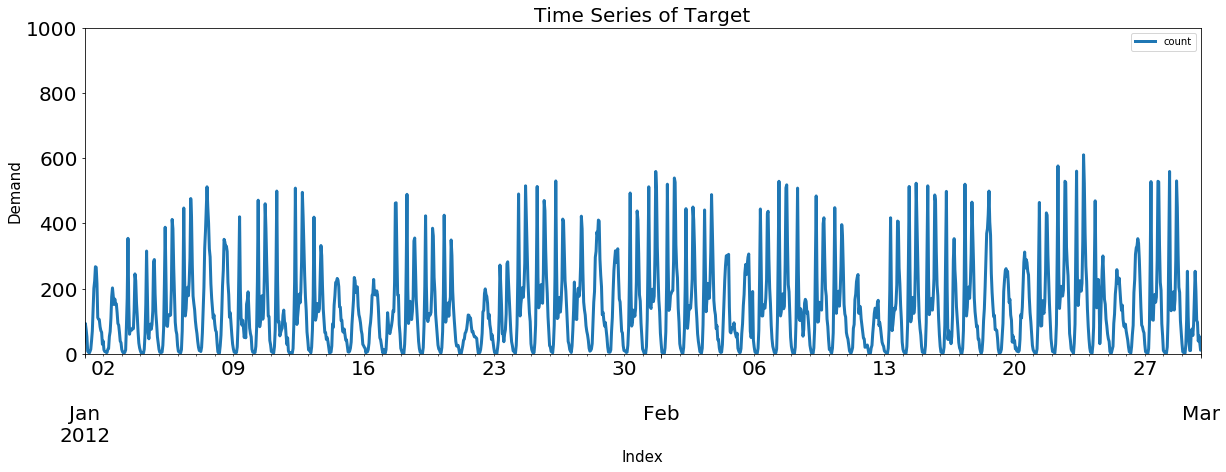

In [177]:
raw_all[['count']].plot(kind='line', figsize=(20,6), linewidth=3, fontsize=20,
                                              xlim=('2012-01-01', '2012-03-01'), ylim=(0,1000))
plt.title('Time Series of Target', fontsize=20)
plt.xlabel('Index', fontsize=15)
plt.ylabel('Demand', fontsize=15)
plt.show()

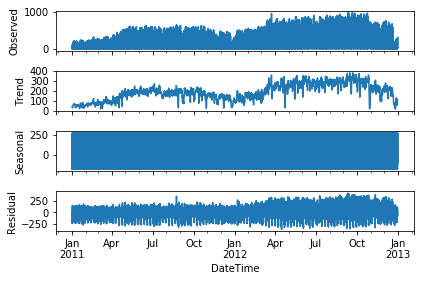

In [178]:
sm.tsa.seasonal_decompose(raw_all['count'], model='additive').plot()
plt.show()

In [179]:
# result = sm.tsa.seasonal_decompose(raw_all['count'], model='additive')
# pd.DataFrame(result.observed - result.trend - result.seasonal).describe()

In [180]:
# sm.tsa.seasonal_decompose(raw_all['count'], model='multiplicative').plot()
# plt.show()

In [181]:
result = sm.tsa.seasonal_decompose(raw_all['count'], model='additive')
Y_trend = pd.DataFrame(result.trend)
Y_trend.fillna(method='ffill', inplace=True)
Y_trend.fillna(method='bfill', inplace=True)
Y_trend.columns = ['count_trend']
Y_seasonal = pd.DataFrame(result.seasonal)
Y_seasonal.fillna(method='ffill', inplace=True)
Y_seasonal.fillna(method='bfill', inplace=True)
Y_seasonal.columns = ['count_seasonal']
pd.concat([raw_all, Y_trend, Y_seasonal], axis=1).isnull().sum()
# pd.concat([raw_all, Y_seasonal], axis=1).isnull().sum()
if 'count_trend' not in raw_all.columns:
    if 'count_seasonal' not in raw_all.columns:
        raw_all = pd.concat([raw_all, Y_trend, Y_seasonal], axis=1)
raw_all

datetime  season  holiday  workingday  weather  \
DateTime                                                                        
2011-01-01 00:00:00 2011-01-01 00:00:00       1        0           0        1   
2011-01-01 01:00:00 2011-01-01 01:00:00       1        0           0        1   
2011-01-01 02:00:00 2011-01-01 02:00:00       1        0           0        1   
2011-01-01 03:00:00 2011-01-01 03:00:00       1        0           0        1   
2011-01-01 04:00:00 2011-01-01 04:00:00       1        0           0        1   
...                                 ...     ...      ...         ...      ...   
2012-12-31 19:00:00 2012-12-31 19:00:00       1        0           1        2   
2012-12-31 20:00:00 2012-12-31 20:00:00       1        0           1        2   
2012-12-31 21:00:00 2012-12-31 21:00:00       1        0           1        1   
2012-12-31 22:00:00 2012-12-31 22:00:00       1        0           1        1   
2012-12-31 23:00:00 2012-12-31 23:00:00       1        0           1        1   

                     temp  atemp  humidity  windspeed  casual  registered  \
DateTime                                                                    
2011-01-01 00:00:00  9.84  14.39        81       0.00       3          13   
2011-01-01 01:00:00  9.02  13.63        80       0.00       8          32   
2011-01-01 02:00:00  9.02  13.63        80       0.00       5          27   
2011-01-01 03:00:00  9.84  14.39        75       0.00       3          10   
2011-01-01 04:00:00  9.84  14.39        75       0.00       0           1   
...                   ...    ...       ...        ...     ...         ...   
2012-12-31 19:00:00 10.66  12.88        60      11.00      11         108   
2012-12-31 20:00:00 10.66  12.88        60      11.00       8          81   
2012-12-31 21:00:00 10.66  12.88        60      11.00       7          83   
2012-12-31 22:00:00 10.66  13.63        56       9.00      13          48   
2012-12-31 23:00:00 10.66  13.63        65       9.00      12          37   

                     count  count_trend  count_seasonal  
DateTime                                                 
2011-01-01 00:00:00     16        41.06         -134.25  
2011-01-01 01:00:00     40        41.06         -154.75  
2011-01-01 02:00:00     32        41.06         -165.27  
2011-01-01 03:00:00     13        41.06         -176.48  
2011-01-01 04:00:00      1        41.06         -181.67  
...                    ...          ...             ...  
2012-12-31 19:00:00    119       113.71          122.70  
2012-12-31 20:00:00     89       113.71           37.48  
2012-12-31 21:00:00     90       113.71          -16.10  
2012-12-31 22:00:00     61       113.71          -56.94  
2012-12-31 23:00:00     49       113.71         -100.31  

[17544 rows x 14 columns]

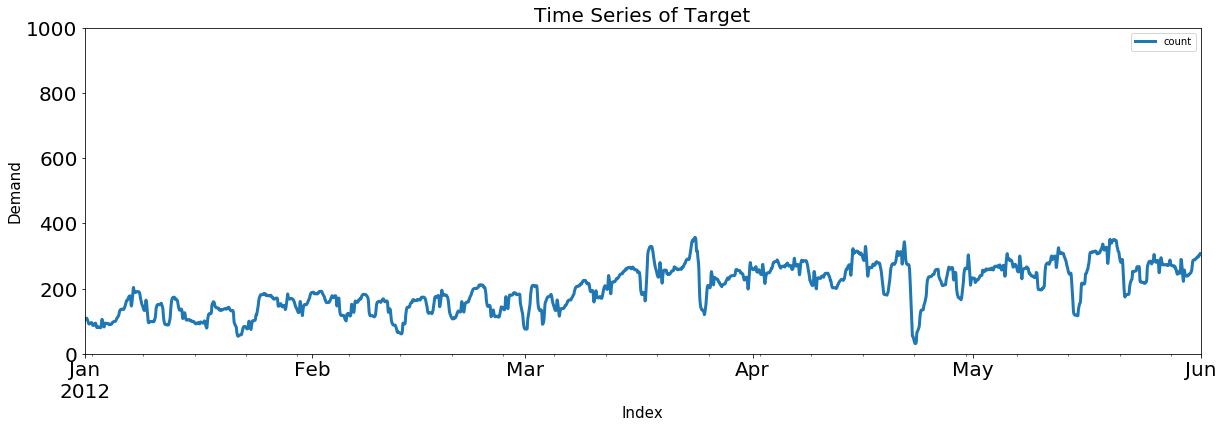

In [182]:
raw_all[['count']].rolling(24).mean().plot(kind='line', figsize=(20,6), linewidth=3, fontsize=20,
                                             xlim=('2012-01-01', '2012-06-01'), ylim=(0,1000))
plt.title('Time Series of Target', fontsize=20)
plt.xlabel('Index', fontsize=15)
plt.ylabel('Demand', fontsize=15)
plt.show()

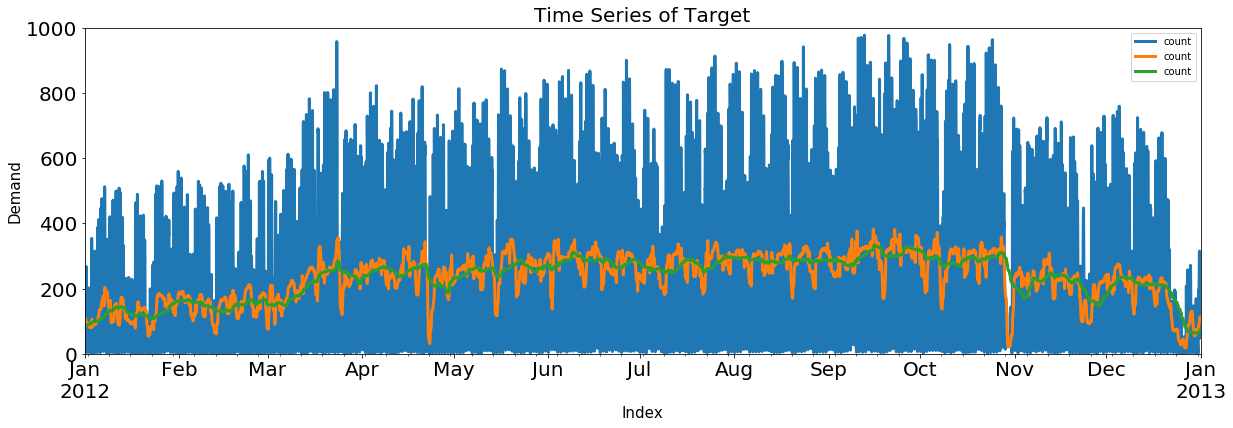

In [183]:
pd.concat([raw_all[['count']],
           raw_all[['count']].rolling(24).mean(),
           raw_all[['count']].rolling(24*7).mean()], axis=1).plot(kind='line', figsize=(20,6), linewidth=3, fontsize=20,
                                                                  xlim=('2012-01-01', '2013-01-01'), ylim=(0,1000))
plt.title('Time Series of Target', fontsize=20)
plt.xlabel('Index', fontsize=15)
plt.ylabel('Demand', fontsize=15)
plt.show()


In [184]:
Y_count_Day = raw_all[['count']].rolling(24).mean()
Y_count_Day.columns = ['count_Day']
# raw_all[['count']].rolling(24).mean()

In [185]:
Y_count_Day = raw_all[['count']].rolling(24).mean()
Y_count_Day.fillna(method='ffill', inplace=True)
Y_count_Day.fillna(method='bfill', inplace=True)
Y_count_Day.columns = ['count_Day']
Y_count_Week = raw_all[['count']].rolling(24*7).mean()
Y_count_Week.fillna(method='ffill', inplace=True)
Y_count_Week.fillna(method='bfill', inplace=True)
Y_count_Week.columns = ['count_Week']
if 'count_Day' not in raw_all.columns:
    raw_all = pd.concat([raw_all, Y_count_Day], axis=1)
if 'count_Week' not in raw_all.columns:
    raw_all = pd.concat([raw_all, Y_count_Week], axis=1)
raw_all

datetime  season  holiday  workingday  weather  \
DateTime                                                                        
2011-01-01 00:00:00 2011-01-01 00:00:00       1        0           0        1   
2011-01-01 01:00:00 2011-01-01 01:00:00       1        0           0        1   
2011-01-01 02:00:00 2011-01-01 02:00:00       1        0           0        1   
2011-01-01 03:00:00 2011-01-01 03:00:00       1        0           0        1   
2011-01-01 04:00:00 2011-01-01 04:00:00       1        0           0        1   
...                                 ...     ...      ...         ...      ...   
2012-12-31 19:00:00 2012-12-31 19:00:00       1        0           1        2   
2012-12-31 20:00:00 2012-12-31 20:00:00       1        0           1        2   
2012-12-31 21:00:00 2012-12-31 21:00:00       1        0           1        1   
2012-12-31 22:00:00 2012-12-31 22:00:00       1        0           1        1   
2012-12-31 23:00:00 2012-12-31 23:00:00       1        0           1        1   

                     temp  atemp  humidity  windspeed  casual  registered  \
DateTime                                                                    
2011-01-01 00:00:00  9.84  14.39        81       0.00       3          13   
2011-01-01 01:00:00  9.02  13.63        80       0.00       8          32   
2011-01-01 02:00:00  9.02  13.63        80       0.00       5          27   
2011-01-01 03:00:00  9.84  14.39        75       0.00       3          10   
2011-01-01 04:00:00  9.84  14.39        75       0.00       0           1   
...                   ...    ...       ...        ...     ...         ...   
2012-12-31 19:00:00 10.66  12.88        60      11.00      11         108   
2012-12-31 20:00:00 10.66  12.88        60      11.00       8          81   
2012-12-31 21:00:00 10.66  12.88        60      11.00       7          83   
2012-12-31 22:00:00 10.66  13.63        56       9.00      13          48   
2012-12-31 23:00:00 10.66  13.63        65       9.00      12          37   

                     count  count_trend  count_seasonal  count_Day  count_Week  
DateTime                                                                        
2011-01-01 00:00:00     16        41.06         -134.25      41.04       56.11  
2011-01-01 01:00:00     40        41.06         -154.75      41.04       56.11  
2011-01-01 02:00:00     32        41.06         -165.27      41.04       56.11  
2011-01-01 03:00:00     13        41.06         -176.48      41.04       56.11  
2011-01-01 04:00:00      1        41.06         -181.67      41.04       56.11  
...                    ...          ...             ...        ...         ...  
2012-12-31 19:00:00    119       113.71          122.70     110.17       73.30  
2012-12-31 20:00:00     89       113.71           37.48     110.88       73.70  
2012-12-31 21:00:00     90       113.71          -16.10     112.67       74.10  
2012-12-31 22:00:00     61       113.71          -56.94     113.71       74.39  
2012-12-31 23:00:00     49       113.71         -100.31     113.71       74.62  

[17544 rows x 16 columns]

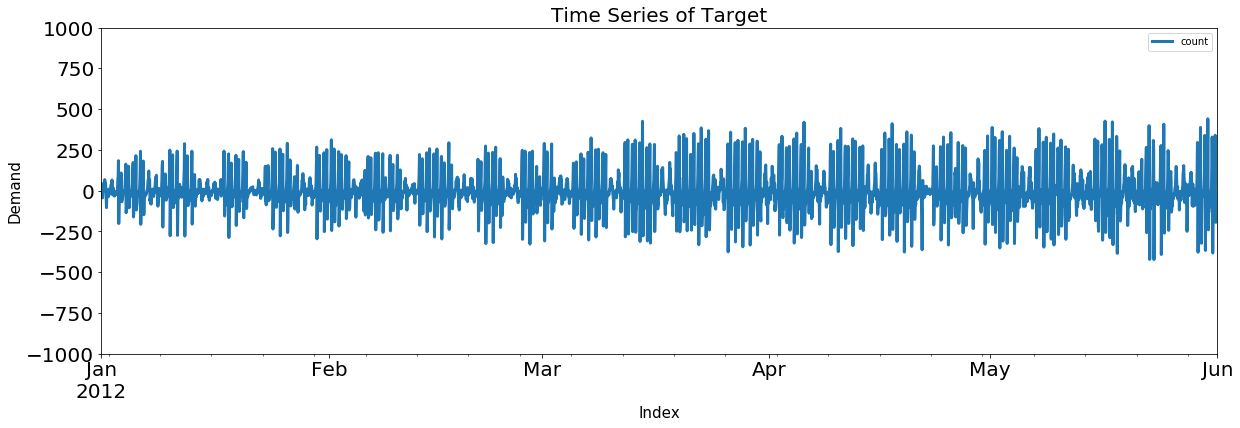

In [186]:
raw_all[['count']].diff().plot(kind='line', figsize=(20,6), linewidth=3, fontsize=20,
                                 xlim=('2012-01-01', '2012-06-01'), ylim=(-1000,1000))
plt.title('Time Series of Target', fontsize=20)
plt.xlabel('Index', fontsize=15)
plt.ylabel('Demand', fontsize=15)
plt.show()

In [187]:
Y_diff = raw_all[['count']].diff()
Y_diff.fillna(method='ffill', inplace=True)
Y_diff.fillna(method='bfill', inplace=True)
Y_diff.columns = ['count_diff']
if 'count_diff' not in raw_all.columns:
    raw_all = pd.concat([raw_all, Y_diff], axis=1)
raw_all

datetime  season  holiday  workingday  weather  \
DateTime                                                                        
2011-01-01 00:00:00 2011-01-01 00:00:00       1        0           0        1   
2011-01-01 01:00:00 2011-01-01 01:00:00       1        0           0        1   
2011-01-01 02:00:00 2011-01-01 02:00:00       1        0           0        1   
2011-01-01 03:00:00 2011-01-01 03:00:00       1        0           0        1   
2011-01-01 04:00:00 2011-01-01 04:00:00       1        0           0        1   
...                                 ...     ...      ...         ...      ...   
2012-12-31 19:00:00 2012-12-31 19:00:00       1        0           1        2   
2012-12-31 20:00:00 2012-12-31 20:00:00       1        0           1        2   
2012-12-31 21:00:00 2012-12-31 21:00:00       1        0           1        1   
2012-12-31 22:00:00 2012-12-31 22:00:00       1        0           1        1   
2012-12-31 23:00:00 2012-12-31 23:00:00       1        0           1        1   

                     temp  atemp  humidity  windspeed  casual  registered  \
DateTime                                                                    
2011-01-01 00:00:00  9.84  14.39        81       0.00       3          13   
2011-01-01 01:00:00  9.02  13.63        80       0.00       8          32   
2011-01-01 02:00:00  9.02  13.63        80       0.00       5          27   
2011-01-01 03:00:00  9.84  14.39        75       0.00       3          10   
2011-01-01 04:00:00  9.84  14.39        75       0.00       0           1   
...                   ...    ...       ...        ...     ...         ...   
2012-12-31 19:00:00 10.66  12.88        60      11.00      11         108   
2012-12-31 20:00:00 10.66  12.88        60      11.00       8          81   
2012-12-31 21:00:00 10.66  12.88        60      11.00       7          83   
2012-12-31 22:00:00 10.66  13.63        56       9.00      13          48   
2012-12-31 23:00:00 10.66  13.63        65       9.00      12          37   

                     count  count_trend  count_seasonal  count_Day  \
DateTime                                                             
2011-01-01 00:00:00     16        41.06         -134.25      41.04   
2011-01-01 01:00:00     40        41.06         -154.75      41.04   
2011-01-01 02:00:00     32        41.06         -165.27      41.04   
2011-01-01 03:00:00     13        41.06         -176.48      41.04   
2011-01-01 04:00:00      1        41.06         -181.67      41.04   
...                    ...          ...             ...        ...   
2012-12-31 19:00:00    119       113.71          122.70     110.17   
2012-12-31 20:00:00     89       113.71           37.48     110.88   
2012-12-31 21:00:00     90       113.71          -16.10     112.67   
2012-12-31 22:00:00     61       113.71          -56.94     113.71   
2012-12-31 23:00:00     49       113.71         -100.31     113.71   

                     count_Week  count_diff  
DateTime                                     
2011-01-01 00:00:00       56.11       24.00  
2011-01-01 01:00:00       56.11       24.00  
2011-01-01 02:00:00       56.11       -8.00  
2011-01-01 03:00:00       56.11      -19.00  
2011-01-01 04:00:00       56.11      -12.00  
...                         ...         ...  
2012-12-31 19:00:00       73.30       -3.00  
2012-12-31 20:00:00       73.70      -30.00  
2012-12-31 21:00:00       74.10        1.00  
2012-12-31 22:00:00       74.39      -29.00  
2012-12-31 23:00:00       74.62      -12.00  

[17544 rows x 17 columns]

In [188]:
# raw_all[['temp']].ndim

In [189]:
raw_all['temp_group'] = pd.cut(raw_all['temp'], 10)
raw_all

datetime  season  holiday  workingday  weather  \
DateTime                                                                        
2011-01-01 00:00:00 2011-01-01 00:00:00       1        0           0        1   
2011-01-01 01:00:00 2011-01-01 01:00:00       1        0           0        1   
2011-01-01 02:00:00 2011-01-01 02:00:00       1        0           0        1   
2011-01-01 03:00:00 2011-01-01 03:00:00       1        0           0        1   
2011-01-01 04:00:00 2011-01-01 04:00:00       1        0           0        1   
...                                 ...     ...      ...         ...      ...   
2012-12-31 19:00:00 2012-12-31 19:00:00       1        0           1        2   
2012-12-31 20:00:00 2012-12-31 20:00:00       1        0           1        2   
2012-12-31 21:00:00 2012-12-31 21:00:00       1        0           1        1   
2012-12-31 22:00:00 2012-12-31 22:00:00       1        0           1        1   
2012-12-31 23:00:00 2012-12-31 23:00:00       1        0           1        1   

                     temp  atemp  humidity  windspeed  casual  registered  \
DateTime                                                                    
2011-01-01 00:00:00  9.84  14.39        81       0.00       3          13   
2011-01-01 01:00:00  9.02  13.63        80       0.00       8          32   
2011-01-01 02:00:00  9.02  13.63        80       0.00       5          27   
2011-01-01 03:00:00  9.84  14.39        75       0.00       3          10   
2011-01-01 04:00:00  9.84  14.39        75       0.00       0           1   
...                   ...    ...       ...        ...     ...         ...   
2012-12-31 19:00:00 10.66  12.88        60      11.00      11         108   
2012-12-31 20:00:00 10.66  12.88        60      11.00       8          81   
2012-12-31 21:00:00 10.66  12.88        60      11.00       7          83   
2012-12-31 22:00:00 10.66  13.63        56       9.00      13          48   
2012-12-31 23:00:00 10.66  13.63        65       9.00      12          37   

                     count  count_trend  count_seasonal  count_Day  \
DateTime                                                             
2011-01-01 00:00:00     16        41.06         -134.25      41.04   
2011-01-01 01:00:00     40        41.06         -154.75      41.04   
2011-01-01 02:00:00     32        41.06         -165.27      41.04   
2011-01-01 03:00:00     13        41.06         -176.48      41.04   
2011-01-01 04:00:00      1        41.06         -181.67      41.04   
...                    ...          ...             ...        ...   
2012-12-31 19:00:00    119       113.71          122.70     110.17   
2012-12-31 20:00:00     89       113.71           37.48     110.88   
2012-12-31 21:00:00     90       113.71          -16.10     112.67   
2012-12-31 22:00:00     61       113.71          -56.94     113.71   
2012-12-31 23:00:00     49       113.71         -100.31     113.71   

                     count_Week  count_diff       temp_group  
DateTime                                                      
2011-01-01 00:00:00       56.11       24.00  (8.856, 12.874]  
2011-01-01 01:00:00       56.11       24.00  (8.856, 12.874]  
2011-01-01 02:00:00       56.11       -8.00  (8.856, 12.874]  
2011-01-01 03:00:00       56.11      -19.00  (8.856, 12.874]  
2011-01-01 04:00:00       56.11      -12.00  (8.856, 12.874]  
...                         ...         ...              ...  
2012-12-31 19:00:00       73.30       -3.00  (8.856, 12.874]  
2012-12-31 20:00:00       73.70      -30.00  (8.856, 12.874]  
2012-12-31 21:00:00       74.10        1.00  (8.856, 12.874]  
2012-12-31 22:00:00       74.39      -29.00  (8.856, 12.874]  
2012-12-31 23:00:00       74.62      -12.00  (8.856, 12.874]  

[17544 rows x 18 columns]

In [190]:
# raw_all.describe().T
# raw_all.describe(include='all').T

In [191]:
# raw_all.isnull()
# raw_all.isnull().sum()

In [192]:
# pd.options.display.max_rows = 100
# raw_all.dtypes
# pd.options.display.max_rows = 10

In [193]:
# raw_all.datetime.dt
# raw_all.datetime.dt.year

In [194]:
raw_all['Year'] = raw_all.datetime.dt.year
raw_all['Quater'] = raw_all.datetime.dt.quarter
raw_all['Quater_ver2'] = raw_all['Quater'] + (raw_all.Year - raw_all.Year.min()) * 4
raw_all

datetime  season  holiday  workingday  weather  \
DateTime                                                                        
2011-01-01 00:00:00 2011-01-01 00:00:00       1        0           0        1   
2011-01-01 01:00:00 2011-01-01 01:00:00       1        0           0        1   
2011-01-01 02:00:00 2011-01-01 02:00:00       1        0           0        1   
2011-01-01 03:00:00 2011-01-01 03:00:00       1        0           0        1   
2011-01-01 04:00:00 2011-01-01 04:00:00       1        0           0        1   
...                                 ...     ...      ...         ...      ...   
2012-12-31 19:00:00 2012-12-31 19:00:00       1        0           1        2   
2012-12-31 20:00:00 2012-12-31 20:00:00       1        0           1        2   
2012-12-31 21:00:00 2012-12-31 21:00:00       1        0           1        1   
2012-12-31 22:00:00 2012-12-31 22:00:00       1        0           1        1   
2012-12-31 23:00:00 2012-12-31 23:00:00       1        0           1        1   

                     temp  atemp  humidity  windspeed  casual     ...       \
DateTime                                                          ...        
2011-01-01 00:00:00  9.84  14.39        81       0.00       3     ...        
2011-01-01 01:00:00  9.02  13.63        80       0.00       8     ...        
2011-01-01 02:00:00  9.02  13.63        80       0.00       5     ...        
2011-01-01 03:00:00  9.84  14.39        75       0.00       3     ...        
2011-01-01 04:00:00  9.84  14.39        75       0.00       0     ...        
...                   ...    ...       ...        ...     ...     ...        
2012-12-31 19:00:00 10.66  12.88        60      11.00      11     ...        
2012-12-31 20:00:00 10.66  12.88        60      11.00       8     ...        
2012-12-31 21:00:00 10.66  12.88        60      11.00       7     ...        
2012-12-31 22:00:00 10.66  13.63        56       9.00      13     ...        
2012-12-31 23:00:00 10.66  13.63        65       9.00      12     ...        

                     count  count_trend  count_seasonal  count_Day  \
DateTime                                                             
2011-01-01 00:00:00     16        41.06         -134.25      41.04   
2011-01-01 01:00:00     40        41.06         -154.75      41.04   
2011-01-01 02:00:00     32        41.06         -165.27      41.04   
2011-01-01 03:00:00     13        41.06         -176.48      41.04   
2011-01-01 04:00:00      1        41.06         -181.67      41.04   
...                    ...          ...             ...        ...   
2012-12-31 19:00:00    119       113.71          122.70     110.17   
2012-12-31 20:00:00     89       113.71           37.48     110.88   
2012-12-31 21:00:00     90       113.71          -16.10     112.67   
2012-12-31 22:00:00     61       113.71          -56.94     113.71   
2012-12-31 23:00:00     49       113.71         -100.31     113.71   

                     count_Week  count_diff       temp_group  Year  Quater  \
DateTime                                                                     
2011-01-01 00:00:00       56.11       24.00  (8.856, 12.874]  2011       1   
2011-01-01 01:00:00       56.11       24.00  (8.856, 12.874]  2011       1   
2011-01-01 02:00:00       56.11       -8.00  (8.856, 12.874]  2011       1   
2011-01-01 03:00:00       56.11      -19.00  (8.856, 12.874]  2011       1   
2011-01-01 04:00:00       56.11      -12.00  (8.856, 12.874]  2011       1   
...                         ...         ...              ...   ...     ...   
2012-12-31 19:00:00       73.30       -3.00  (8.856, 12.874]  2012       4   
2012-12-31 20:00:00       73.70      -30.00  (8.856, 12.874]  2012       4   
2012-12-31 21:00:00       74.10        1.00  (8.856, 12.874]  2012       4   
2012-12-31 22:00:00       74.39      -29.00  (8.856, 12.874]  2012       4   
2012-12-31 23:00:00       74.62      -12.00  (8.856, 12.874]  2012       4   

                     Quater_ver2  
D

In [195]:
raw_all['Month'] = raw_all.datetime.dt.month
raw_all['Day'] = raw_all.datetime.dt.day
raw_all['Hour'] = raw_all.datetime.dt.hour
raw_all['DayofWeek'] = raw_all.datetime.dt.dayofweek
raw_all

datetime  season  holiday  workingday  weather  \
DateTime                                                                        
2011-01-01 00:00:00 2011-01-01 00:00:00       1        0           0        1   
2011-01-01 01:00:00 2011-01-01 01:00:00       1        0           0        1   
2011-01-01 02:00:00 2011-01-01 02:00:00       1        0           0        1   
2011-01-01 03:00:00 2011-01-01 03:00:00       1        0           0        1   
2011-01-01 04:00:00 2011-01-01 04:00:00       1        0           0        1   
...                                 ...     ...      ...         ...      ...   
2012-12-31 19:00:00 2012-12-31 19:00:00       1        0           1        2   
2012-12-31 20:00:00 2012-12-31 20:00:00       1        0           1        2   
2012-12-31 21:00:00 2012-12-31 21:00:00       1        0           1        1   
2012-12-31 22:00:00 2012-12-31 22:00:00       1        0           1        1   
2012-12-31 23:00:00 2012-12-31 23:00:00       1        0           1        1   

                     temp  atemp  humidity  windspeed  casual    ...      \
DateTime                                                         ...       
2011-01-01 00:00:00  9.84  14.39        81       0.00       3    ...       
2011-01-01 01:00:00  9.02  13.63        80       0.00       8    ...       
2011-01-01 02:00:00  9.02  13.63        80       0.00       5    ...       
2011-01-01 03:00:00  9.84  14.39        75       0.00       3    ...       
2011-01-01 04:00:00  9.84  14.39        75       0.00       0    ...       
...                   ...    ...       ...        ...     ...    ...       
2012-12-31 19:00:00 10.66  12.88        60      11.00      11    ...       
2012-12-31 20:00:00 10.66  12.88        60      11.00       8    ...       
2012-12-31 21:00:00 10.66  12.88        60      11.00       7    ...       
2012-12-31 22:00:00 10.66  13.63        56       9.00      13    ...       
2012-12-31 23:00:00 10.66  13.63        65       9.00      12    ...       

                     count_Week  count_diff       temp_group  Year  Quater  \
DateTime                                                                     
2011-01-01 00:00:00       56.11       24.00  (8.856, 12.874]  2011       1   
2011-01-01 01:00:00       56.11       24.00  (8.856, 12.874]  2011       1   
2011-01-01 02:00:00       56.11       -8.00  (8.856, 12.874]  2011       1   
2011-01-01 03:00:00       56.11      -19.00  (8.856, 12.874]  2011       1   
2011-01-01 04:00:00       56.11      -12.00  (8.856, 12.874]  2011       1   
...                         ...         ...              ...   ...     ...   
2012-12-31 19:00:00       73.30       -3.00  (8.856, 12.874]  2012       4   
2012-12-31 20:00:00       73.70      -30.00  (8.856, 12.874]  2012       4   
2012-12-31 21:00:00       74.10        1.00  (8.856, 12.874]  2012       4   
2012-12-31 22:00:00       74.39      -29.00  (8.856, 12.874]  2012       4   
2012-12-31 23:00:00       74.62      -12.00  (8.856, 12.874]  2012       4   

                     Quater_ver2  Month Day  Hour  DayofWeek  
DateTime                                                      
2011-01-01 00:00:00            1      1   1     0          5  
2011-01-01 01:00:00            1      1   1     1          5  
2011-01-01 02:00:00            1      1   1     2          5  
2011-01-01 03:00:00            1      1   1     3          5  
2011-01-01 04:00:00            1      1   1     4          5  
...                          ...    ...  ..   ...        ...  
2012-12-31 19:00:00            8     12  31    19          0  
2012-12-31 20:00:00            8     12  31    20          0  
2012-12-31 21:00:00            8     12  31    21          0  
2012-12-31 22:00:00            8     12  31    22          0  
2012-12-31 23:00:00            8     12  31    23          0  

[17544 rows x 25 columns]

In [196]:
# raw_all.info()
# raw_all.describe(include='all').T

In [197]:
# raw_all['count'].shift(1)
# raw_all['count'].shift(-1)

In [198]:
raw_all['count_lag1'] = raw_all['count'].shift(1)
raw_all['count_lag2'] = raw_all['count'].shift(2)

In [199]:
# raw_all.describe().T
# raw_all

In [200]:
# raw_all['count_lag2'].fillna(method='bfill')
# raw_all['count_lag2'].fillna(method='ffill')
# raw_all['count_lag2'].fillna(0)

In [201]:
raw_all['count_lag1'].fillna(method='bfill', inplace=True)
raw_all['count_lag2'].fillna(method='bfill', inplace=True)
raw_all

datetime  season  holiday  workingday  weather  \
DateTime                                                                        
2011-01-01 00:00:00 2011-01-01 00:00:00       1        0           0        1   
2011-01-01 01:00:00 2011-01-01 01:00:00       1        0           0        1   
2011-01-01 02:00:00 2011-01-01 02:00:00       1        0           0        1   
2011-01-01 03:00:00 2011-01-01 03:00:00       1        0           0        1   
2011-01-01 04:00:00 2011-01-01 04:00:00       1        0           0        1   
...                                 ...     ...      ...         ...      ...   
2012-12-31 19:00:00 2012-12-31 19:00:00       1        0           1        2   
2012-12-31 20:00:00 2012-12-31 20:00:00       1        0           1        2   
2012-12-31 21:00:00 2012-12-31 21:00:00       1        0           1        1   
2012-12-31 22:00:00 2012-12-31 22:00:00       1        0           1        1   
2012-12-31 23:00:00 2012-12-31 23:00:00       1        0           1        1   

                     temp  atemp  humidity  windspeed  casual     ...      \
DateTime                                                          ...       
2011-01-01 00:00:00  9.84  14.39        81       0.00       3     ...       
2011-01-01 01:00:00  9.02  13.63        80       0.00       8     ...       
2011-01-01 02:00:00  9.02  13.63        80       0.00       5     ...       
2011-01-01 03:00:00  9.84  14.39        75       0.00       3     ...       
2011-01-01 04:00:00  9.84  14.39        75       0.00       0     ...       
...                   ...    ...       ...        ...     ...     ...       
2012-12-31 19:00:00 10.66  12.88        60      11.00      11     ...       
2012-12-31 20:00:00 10.66  12.88        60      11.00       8     ...       
2012-12-31 21:00:00 10.66  12.88        60      11.00       7     ...       
2012-12-31 22:00:00 10.66  13.63        56       9.00      13     ...       
2012-12-31 23:00:00 10.66  13.63        65       9.00      12     ...       

                          temp_group  Year  Quater  Quater_ver2  Month  Day  \
DateTime                                                                      
2011-01-01 00:00:00  (8.856, 12.874]  2011       1            1      1    1   
2011-01-01 01:00:00  (8.856, 12.874]  2011       1            1      1    1   
2011-01-01 02:00:00  (8.856, 12.874]  2011       1            1      1    1   
2011-01-01 03:00:00  (8.856, 12.874]  2011       1            1      1    1   
2011-01-01 04:00:00  (8.856, 12.874]  2011       1            1      1    1   
...                              ...   ...     ...          ...    ...  ...   
2012-12-31 19:00:00  (8.856, 12.874]  2012       4            8     12   31   
2012-12-31 20:00:00  (8.856, 12.874]  2012       4            8     12   31   
2012-12-31 21:00:00  (8.856, 12.874]  2012       4            8     12   31   
2012-12-31 22:00:00  (8.856, 12.874]  2012       4            8     12   31   
2012-12-31 23:00:00  (8.856, 12.874]  2012       4            8     12   31   

                     Hour DayofWeek  count_lag1  count_lag2  
DateTime                                                     
2011-01-01 00:00:00     0         5       16.00       16.00  
2011-01-01 01:00:00     1         5       16.00       16.00  
2011-01-01 02:00:00     2         5       40.00       16.00  
2011-01-01 03:00:00     3         5       32.00       40.00  
2011-01-01 04:00:00     4         5       13.00       32.00  
...                   ...       ...         ...         ...  
2012-12-31 19:00:00    19         0      122.00      164.00  
2012-12-31 20:00:00    20         0      119.00      122.00  
2012-12-31 21:00:00    21         0       89.00      119.00  
2012-12-31 22:00:00    22         0       90.00       89.00  
2012-12-31 23:00:00    23         0       61.00       90.00  

[17544 rows x 27 columns]

In [202]:
# pd.get_dummies(raw_all['Quater'])
# pd.get_dummies(raw_all['Quater']).describe().T
# pd.get_dummies(raw_all['Quater'], prefix='Quater_Dummy')
# pd.get_dummies(raw_all['Quater'], prefix='Quater_Dummy', drop_first=True)
# pd.concat([raw_all, pd.get_dummies(raw_all['Quater'], prefix='Quater_Dummy', drop_first=True)
# ], axis=1)

In [203]:
if 'Quater' in raw_all.columns:
    raw_all = pd.concat([raw_all, pd.get_dummies(raw_all['Quater'], prefix='Quater_Dummy', drop_first=True)
], axis=1)
    del raw_all['Quater']
raw_all.describe(include='all').T

count unique                  top freq  \
datetime           17544  17379  2012-10-29 00:00:00   37   
season         17,544.00    NaN                  NaN  NaN   
holiday        17,544.00    NaN                  NaN  NaN   
workingday     17,544.00    NaN                  NaN  NaN   
weather        17,544.00    NaN                  NaN  NaN   
...                  ...    ...                  ...  ...   
count_lag1     17,544.00    NaN                  NaN  NaN   
count_lag2     17,544.00    NaN                  NaN  NaN   
Quater_Dummy_2 17,544.00    NaN                  NaN  NaN   
Quater_Dummy_3 17,544.00    NaN                  NaN  NaN   
Quater_Dummy_4 17,544.00    NaN                  NaN  NaN   

                              first                 last   mean    std  min  \
datetime        2011-01-01 00:00:00  2012-12-31 23:00:00    NaN    NaN  NaN   
season                          NaN                  NaN   2.50   1.11 1.00   
holiday                         NaN                  NaN   0.03   0.17 0.00   
workingday                      NaN                  NaN   0.68   0.47 0.00   
weather                         NaN                  NaN   1.43   0.65 1.00   
...                             ...                  ...    ...    ...  ...   
count_lag1                      NaN                  NaN 187.79 181.35 1.00   
count_lag2                      NaN                  NaN 187.79 181.35 1.00   
Quater_Dummy_2                  NaN                  NaN   0.25   0.43 0.00   
Quater_Dummy_3                  NaN                  NaN   0.25   0.43 0.00   
Quater_Dummy_4                  NaN                  NaN   0.25   0.43 0.00   

                 25%    50%    75%    max  
datetime         NaN    NaN    NaN    NaN  
season          2.00   3.00   3.00   4.00  
holiday         0.00   0.00   0.00   1.00  
workingday      0.00   1.00   1.00   1.00  
weather         1.00   1.00   2.00   4.00  
...              ...    ...    ...    ...  
count_lag1     38.00 140.00 279.00 977.00  
count_lag2     38.00 140.00 279.00 977.00  
Quater_Dummy_2  0.00   0.00   0.00   1.00  
Quater_Dummy_3  0.00   0.00   1.00   1.00  
Quater_Dummy_4  0.00   0.00   1.00   1.00  

[29 rows x 13 columns]

# Data Understanding
**1. Import Library**  
**2. Data Loading**  [(Data Source and Description)](https://www.kaggle.com/c/bike-sharing-demand/data)  
**3. Feature Engineering(Rearrange of Data)**  
**4. Data Understanding(Descriptive Statistics and Getting Insight from Features)**  

In [204]:
# raw_all.describe(include='all').T

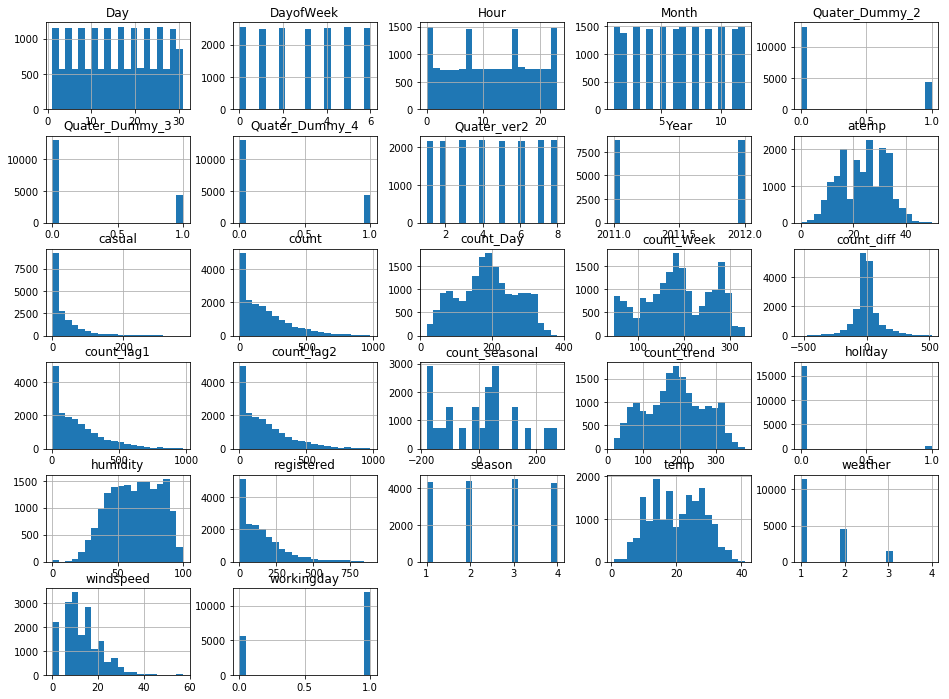

In [205]:
raw_all.hist(bins=20, grid=True, figsize=(16,12))
plt.show()

(0, 1000)

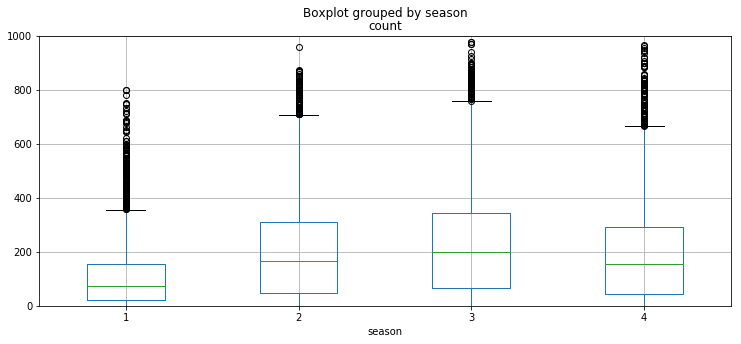

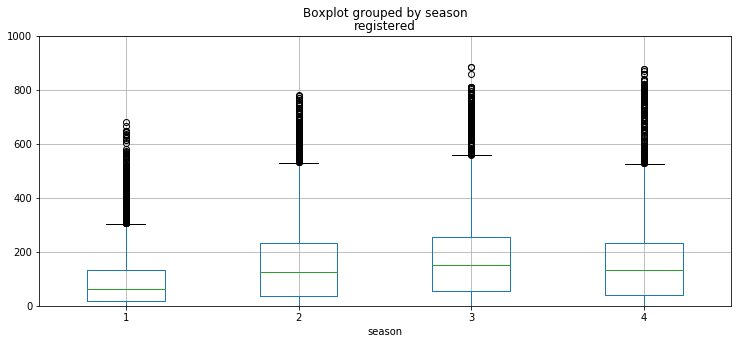

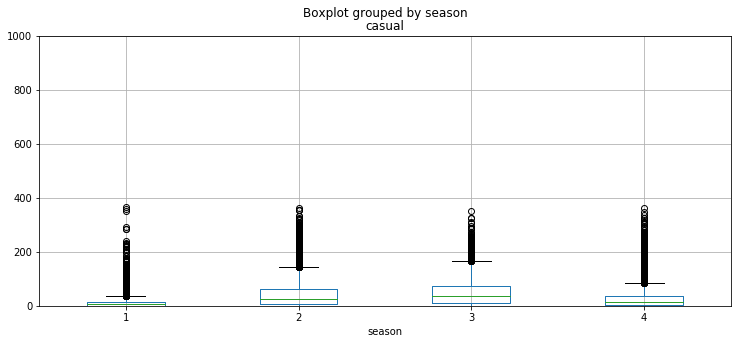

In [206]:
raw_all.boxplot(column='count', by='season', grid=True, figsize=(12,5))
plt.ylim(0,1000)
raw_all.boxplot(column='registered', by='season', grid=True, figsize=(12,5))
plt.ylim(0,1000)
raw_all.boxplot(column='casual', by='season', grid=True, figsize=(12,5))
plt.ylim(0,1000)

(0, 1000)

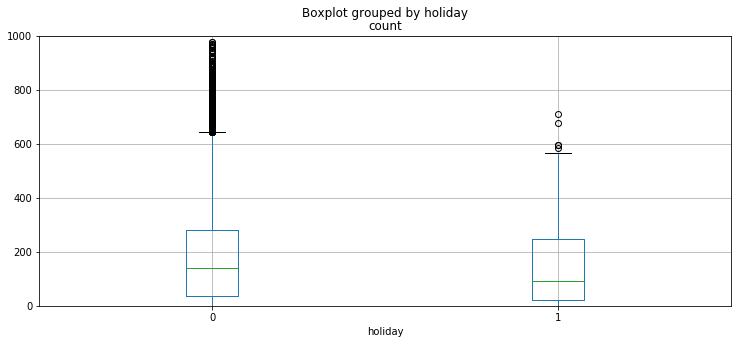

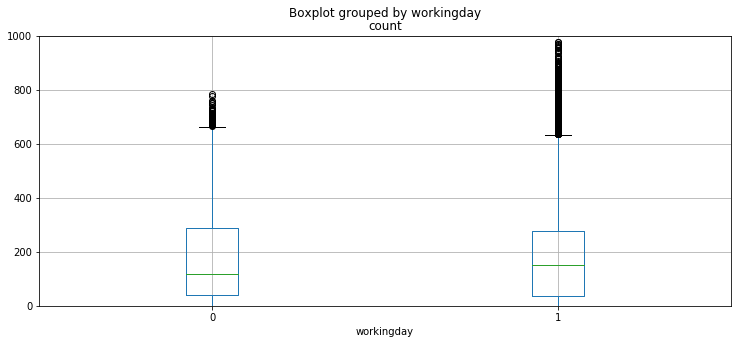

In [207]:
raw_all.boxplot(column='count', by='holiday', grid=True, figsize=(12,5))
plt.ylim(0,1000)
raw_all.boxplot(column='count', by='workingday', grid=True, figsize=(12,5))
plt.ylim(0,1000)

In [208]:
# raw_all[raw_all.holiday == 0]

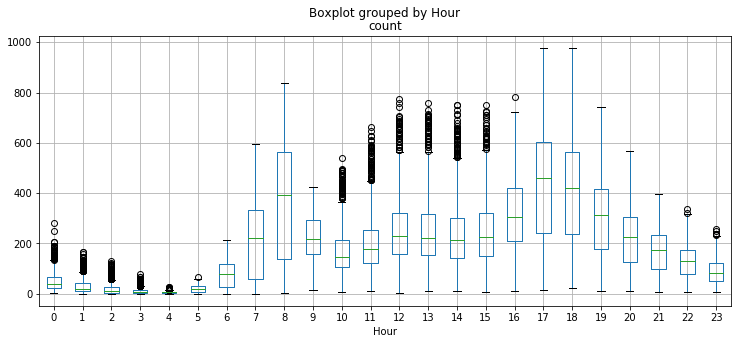

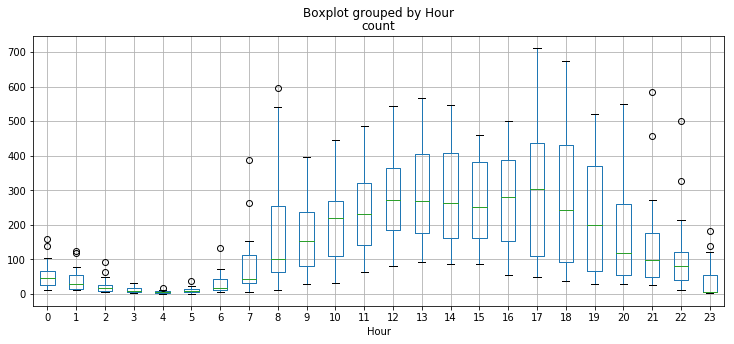

In [209]:
raw_all[raw_all.holiday == 0].boxplot(column='count', by='Hour', grid=True, figsize=(12,5))
plt.show()
raw_all[raw_all.holiday == 1].boxplot(column='count', by='Hour', grid=True, figsize=(12,5))
plt.show()

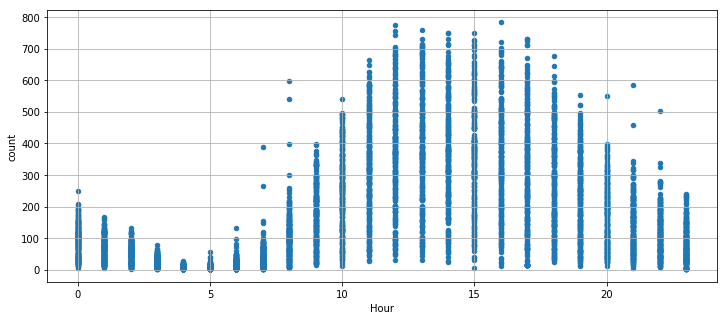

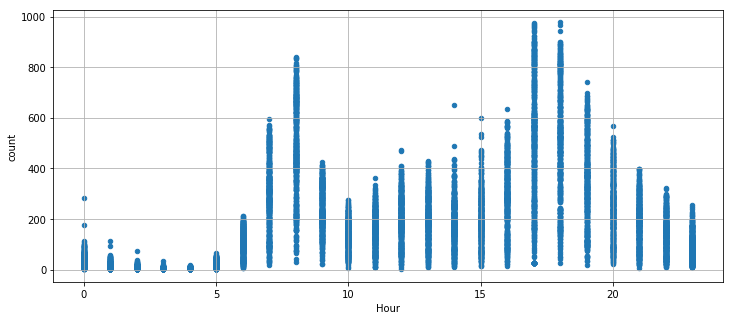

In [210]:
raw_all[raw_all.workingday == 0].plot.scatter(y='count', x='Hour', grid=True, figsize=(12,5))
plt.show()
raw_all[raw_all.workingday == 1].plot.scatter(y='count', x='Hour', grid=True, figsize=(12,5))
plt.show()

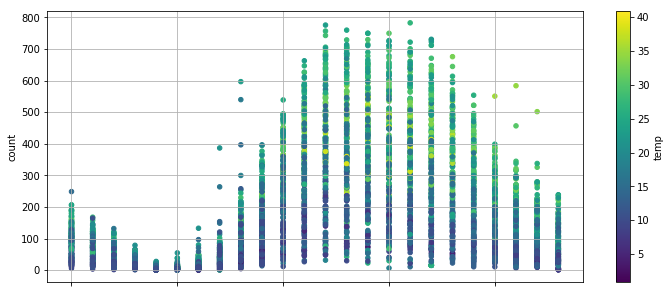

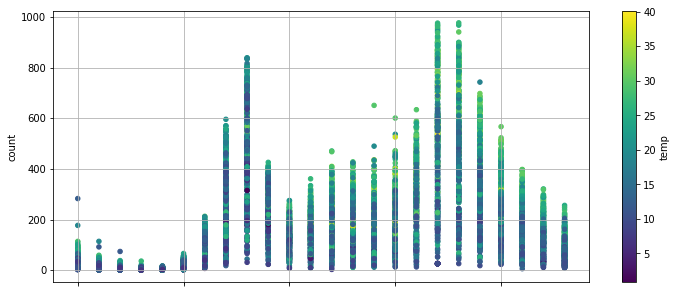

In [211]:
raw_all[raw_all.workingday == 0].plot.scatter(y='count', x='Hour', c='temp', grid=True, figsize=(12,5), colormap='viridis')
plt.show()
raw_all[raw_all.workingday == 1].plot.scatter(y='count', x='Hour', c='temp', grid=True, figsize=(12,5), colormap='viridis')
plt.show()

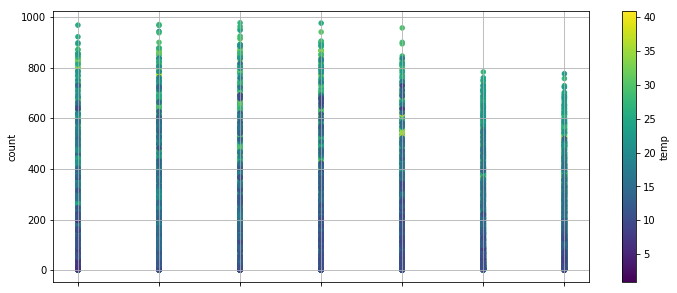

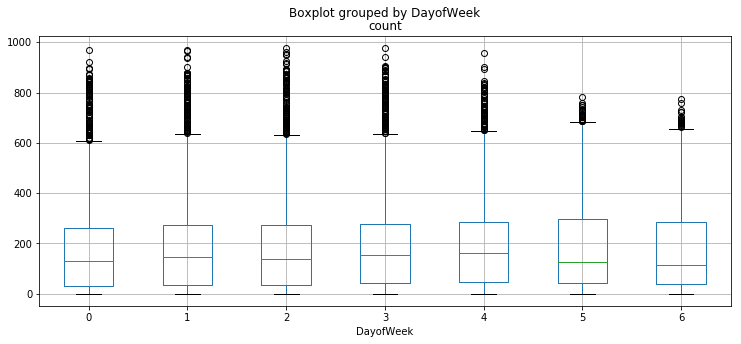

In [212]:
raw_all.plot.scatter(y='count', x='DayofWeek', c='temp', grid=True, figsize=(12,5), colormap='viridis')
plt.show()
raw_all.boxplot(column='count', by='DayofWeek', grid=True, figsize=(12,5))
plt.show()

(0, 1000)

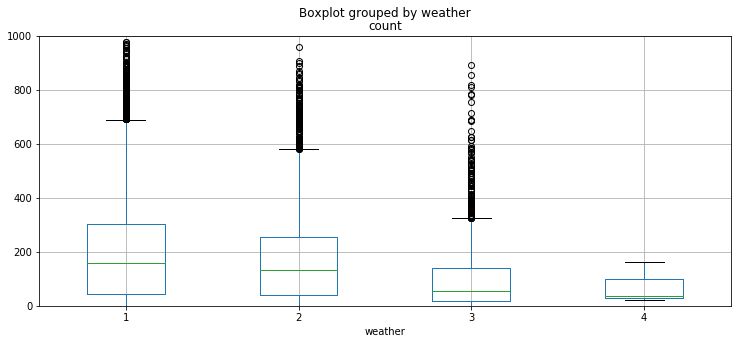

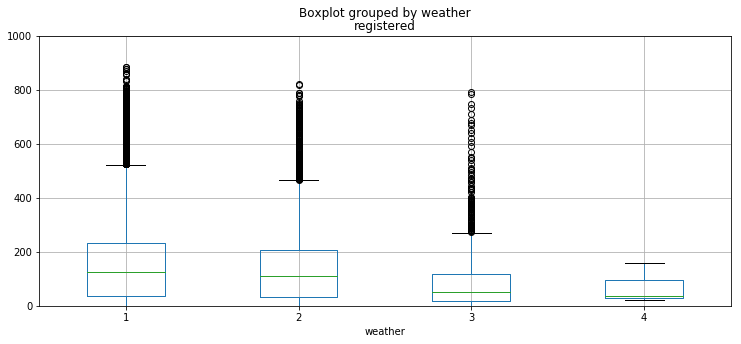

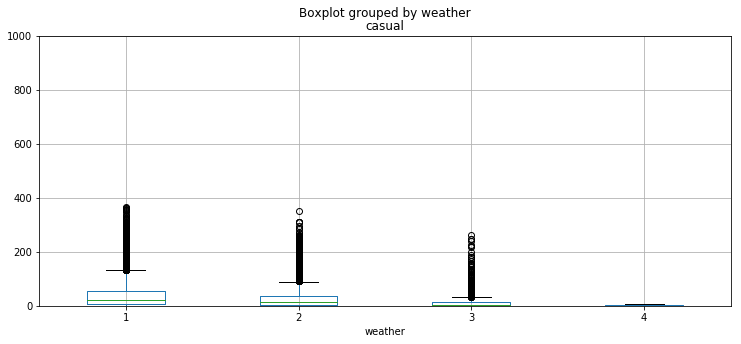

In [213]:
raw_all.boxplot(column='count', by='weather', grid=True, figsize=(12,5))
plt.ylim(0,1000)
raw_all.boxplot(column='registered', by='weather', grid=True, figsize=(12,5))
plt.ylim(0,1000)
raw_all.boxplot(column='casual', by='weather', grid=True, figsize=(12,5))
plt.ylim(0,1000)

In [214]:
# pd.concat([raw_all.dtypes, raw_all.describe(include='all').T], axis=1)

In [215]:
# raw_all['weather'].value_counts()

In [216]:
pd.DataFrame(raw_all['weather'].value_counts()/raw_all['weather'].value_counts().sum()*100).T

1     2    3    4
weather 65.29 26.01 8.68 0.02

In [217]:
# pd.crosstab(index=raw_all['count'], columns=raw_all['weather'], margins=True)

In [218]:
sub_table = pd.crosstab(index=raw_all['count'], columns=raw_all['weather'], margins=True)
sub_table/sub_table.loc['All']*100

weather      1      2      3      4    All
count                                     
1         0.87   0.99   1.77   0.00   0.98
2         1.19   1.29   2.43   0.00   1.32
3         1.19   1.45   2.69   0.00   1.39
4         1.30   1.36   2.36   0.00   1.41
5         1.43   1.38   2.36   0.00   1.50
...        ...    ...    ...    ...    ...
968       0.01   0.00   0.00   0.00   0.01
970       0.01   0.00   0.00   0.00   0.01
976       0.01   0.00   0.00   0.00   0.01
977       0.01   0.00   0.00   0.00   0.01
All     100.00 100.00 100.00 100.00 100.00

[870 rows x 5 columns]

In [219]:
# raw_all.groupby('weather').describe().T

In [220]:
# raw_all.groupby(['weather', 'DayofWeek']).count()
# raw_all.groupby(['weather', 'DayofWeek']).mean()

In [221]:
raw_all.groupby(['weather', 'DayofWeek']).describe()

Day                                              Hour  \
                     count  mean  std   min   25%   50%   75%   max    count   
weather DayofWeek                                                              
1       0         1,594.00 15.64 8.96  1.00  8.00 15.00 24.00 31.00 1,594.00   
        1         1,527.00 16.16 9.11  1.00  8.00 16.00 24.50 31.00 1,527.00   
        2         1,577.00 15.86 8.83  1.00  8.00 16.00 24.00 31.00 1,577.00   
        3         1,660.00 15.01 8.97  1.00  7.00 14.00 23.00 31.00 1,660.00   
        4         1,649.00 15.41 8.70  1.00  8.00 15.00 23.00 31.00 1,649.00   
...                    ...   ...  ...   ...   ...   ...   ...   ...      ...   
3       5           201.00 16.32 9.61  1.00  8.00 16.00 25.00 31.00   201.00   
        6           170.00 14.36 9.42  1.00  6.00 14.00 22.00 30.00   170.00   
4       0             1.00  9.00  nan  9.00  9.00  9.00  9.00  9.00     1.00   
        2             1.00 26.00  nan 26.00 26.00 26.00 26.00 26.00     1.00   
        5             1.00 21.00  nan 21.00 21.00 21.00 21.00 21.00     1.00   

                        ...  windspeed       workingday                      \
                   mean ...        75%   max      count mean  std  min  25%   
weather DayofWeek       ...                                                   
1       0         11.39 ...      19.00 48.00   1,594.00 0.86 0.35 0.00 1.00   
        1         12.17 ...      19.00 52.00   1,527.00 1.00 0.06 0.00 1.00   
        2         11.60 ...      17.00 39.00   1,577.00 0.99 0.12 0.00 1.00   
        3         11.90 ...      19.00 46.00   1,660.00 0.97 0.17 0.00 1.00   
        4         11.57 ...      17.00 54.00   1,649.00 0.97 0.16 0.00 1.00   
...                 ... ...        ...   ...        ...  ...  ...  ...  ...   
3       5         12.18 ...      24.00 56.00     201.00 0.00 0.00 0.00 0.00   
        6         13.77 ...      22.00 57.00     170.00 0.00 0.00 0.00 0.00   
4       0         18.00 ...       6.00  6.00       1.00 1.00  nan 1.00 1.00   
        2         16.00 ...      22.00 22.00       1.00 1.00  nan 1.00 1.00   
        5          1.00 ...      13.00 13.00       1.00 0.00  nan 0.00 0.00   

                                  
                   50%  75%  max  
weather DayofWeek                 
1       0         1.00 1.00 1.00  
        1         1.00 1.00 1.00  
        2         1.00 1.00 1.00  
        3         1.00 1.00 1.00  
        4         1.00 1.00 1.00  
...                ...  ...  ...  
3       5         0.00 0.00 0.00  
        6         0.00 0.00 0.00  
4       0         1.00 1.00 1.00  
        2         1.00 1.00 1.00  
        5         0.00 0.00 0.00  

[24 rows x 200 columns]

In [222]:
# raw_all.groupby(['weather', 'DayofWeek']).agg({'count':'mean'})
# raw_all.groupby(['weather', 'DayofWeek']).agg({'count':[sum, min, max]})

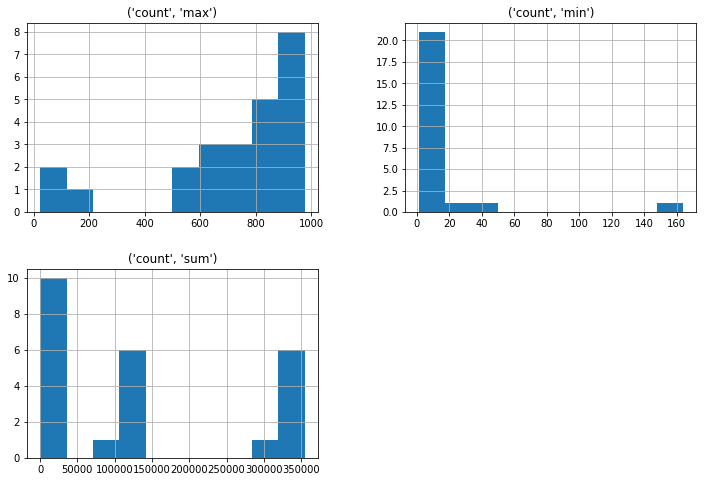

In [223]:
raw_all.groupby(['weather', 'DayofWeek']).agg({'count':[sum, min, max]}).hist(grid=True, figsize=(12,8))
plt.show()

In [224]:
# raw_all.groupby('weather').groups.keys()
# raw_all.groupby('weather').groups.items()

In [225]:
for key, item in raw_all.groupby('weather'):
    display(key, item)
    display(raw_all.groupby('weather').get_group(key).head())

1

datetime  season  holiday  workingday  weather  \
DateTime                                                                        
2011-01-01 00:00:00 2011-01-01 00:00:00       1        0           0        1   
2011-01-01 01:00:00 2011-01-01 01:00:00       1        0           0        1   
2011-01-01 02:00:00 2011-01-01 02:00:00       1        0           0        1   
2011-01-01 03:00:00 2011-01-01 03:00:00       1        0           0        1   
2011-01-01 04:00:00 2011-01-01 04:00:00       1        0           0        1   
...                                 ...     ...      ...         ...      ...   
2012-12-31 07:00:00 2012-12-31 07:00:00       1        0           1        1   
2012-12-31 08:00:00 2012-12-31 08:00:00       1        0           1        1   
2012-12-31 21:00:00 2012-12-31 21:00:00       1        0           1        1   
2012-12-31 22:00:00 2012-12-31 22:00:00       1        0           1        1   
2012-12-31 23:00:00 2012-12-31 23:00:00       1        0           1        1   

                     temp  atemp  humidity  windspeed  casual       ...        \
DateTime                                                            ...         
2011-01-01 00:00:00  9.84  14.39        81       0.00       3       ...         
2011-01-01 01:00:00  9.02  13.63        80       0.00       8       ...         
2011-01-01 02:00:00  9.02  13.63        80       0.00       5       ...         
2011-01-01 03:00:00  9.84  14.39        75       0.00       3       ...         
2011-01-01 04:00:00  9.84  14.39        75       0.00       0       ...         
...                   ...    ...       ...        ...     ...       ...         
2012-12-31 07:00:00  6.56   9.09        64       9.00       2       ...         
2012-12-31 08:00:00  5.74   7.58        69       9.00       9       ...         
2012-12-31 21:00:00 10.66  12.88        60      11.00       7       ...         
2012-12-31 22:00:00 10.66  13.63        56       9.00      13       ...         
2012-12-31 23:00:00 10.66  13.63        65       9.00      12       ...         

                     Quater_ver2  Month  Day  Hour  DayofWeek  count_lag1  \
DateTime                                                                    
2011-01-01 00:00:00            1      1    1     0          5       16.00   
2011-01-01 01:00:00            1      1    1     1          5       16.00   
2011-01-01 02:00:00            1      1    1     2          5       40.00   
2011-01-01 03:00:00            1      1    1     3          5       32.00   
2011-01-01 04:00:00            1      1    1     4          5       13.00   
...                          ...    ...  ...   ...        ...         ...   
2012-12-31 07:00:00            8     12   31     7          0       40.00   
2012-12-31 08:00:00            8     12   31     8          0       85.00   
2012-12-31 21:00:00            8     12   31    21          0       89.00   
2012-12-31 22:00:00            8     12   31    22          0       90.00   
2012-12-31 23:00:00            8     12   31    23          0       61.00   

                     count_lag2 Quater_Dummy_2  Quater_Dummy_3  Quater_Dummy_4  
DateTime                                                                        
2011-01-01 00:00:00       16.00              0               0               0  
2011-01-01 01:00:00       16.00              0               0               0  
2011-01-01 02:00:00       16.00              0               0               0  
2011-01-01 03:00:00       40.00              0               0               0  
2011-01-01 04:00:00       32.00              0               0               0  
...                         ...            ...             ...             ...  
2012-12-31 07:00:00        9.00              0               0               1  
2012-12-31 08:00:00       40.00              0               0               1  
2012-12-31 21:00:00      119.00              0               0               1  
2012-12-31 22:00:00       89.0

datetime  season  holiday  workingday  weather  \
DateTime                                                                        
2011-01-01 00:00:00 2011-01-01 00:00:00       1        0           0        1   
2011-01-01 01:00:00 2011-01-01 01:00:00       1        0           0        1   
2011-01-01 02:00:00 2011-01-01 02:00:00       1        0           0        1   
2011-01-01 03:00:00 2011-01-01 03:00:00       1        0           0        1   
2011-01-01 04:00:00 2011-01-01 04:00:00       1        0           0        1   

                     temp  atemp  humidity  windspeed  casual       ...        \
DateTime                                                            ...         
2011-01-01 00:00:00  9.84  14.39        81       0.00       3       ...         
2011-01-01 01:00:00  9.02  13.63        80       0.00       8       ...         
2011-01-01 02:00:00  9.02  13.63        80       0.00       5       ...         
2011-01-01 03:00:00  9.84  14.39        75       0.00       3       ...         
2011-01-01 04:00:00  9.84  14.39        75       0.00       0       ...         

                     Quater_ver2  Month  Day  Hour  DayofWeek  count_lag1  \
DateTime                                                                    
2011-01-01 00:00:00            1      1    1     0          5       16.00   
2011-01-01 01:00:00            1      1    1     1          5       16.00   
2011-01-01 02:00:00            1      1    1     2          5       40.00   
2011-01-01 03:00:00            1      1    1     3          5       32.00   
2011-01-01 04:00:00            1      1    1     4          5       13.00   

                     count_lag2 Quater_Dummy_2  Quater_Dummy_3  Quater_Dummy_4  
DateTime                                                                        
2011-01-01 00:00:00       16.00              0               0               0  
2011-01-01 01:00:00       16.00              0               0               0  
2011-01-01 02:00:00       16.00              0               0               0  
2011-01-01 03:00:00       40.00              0               0               0  
2011-01-01 04:00:00       32.00              0               0               0  

[5 rows x 29 columns]

2

datetime  season  holiday  workingday  weather  \
DateTime                                                                        
2011-01-01 05:00:00 2011-01-01 05:00:00       1        0           0        2   
2011-01-01 13:00:00 2011-01-01 13:00:00       1        0           0        2   
2011-01-01 14:00:00 2011-01-01 14:00:00       1        0           0        2   
2011-01-01 15:00:00 2011-01-01 15:00:00       1        0           0        2   
2011-01-01 16:00:00 2011-01-01 16:00:00       1        0           0        2   
...                                 ...     ...      ...         ...      ...   
2012-12-31 16:00:00 2012-12-31 16:00:00       1        0           1        2   
2012-12-31 17:00:00 2012-12-31 17:00:00       1        0           1        2   
2012-12-31 18:00:00 2012-12-31 18:00:00       1        0           1        2   
2012-12-31 19:00:00 2012-12-31 19:00:00       1        0           1        2   
2012-12-31 20:00:00 2012-12-31 20:00:00       1        0           1        2   

                     temp  atemp  humidity  windspeed  casual       ...        \
DateTime                                                            ...         
2011-01-01 05:00:00  9.84  12.88        75       6.00       0       ...         
2011-01-01 13:00:00 18.86  22.73        72      20.00      47       ...         
2011-01-01 14:00:00 18.86  22.73        72      19.00      35       ...         
2011-01-01 15:00:00 18.04  21.97        77      20.00      40       ...         
2011-01-01 16:00:00 17.22  21.21        82      20.00      41       ...         
...                   ...    ...       ...        ...     ...       ...         
2012-12-31 16:00:00 10.66  12.88        48      13.00      30       ...         
2012-12-31 17:00:00 10.66  14.39        48       6.00      14       ...         
2012-12-31 18:00:00 10.66  13.63        48       9.00      10       ...         
2012-12-31 19:00:00 10.66  12.88        60      11.00      11       ...         
2012-12-31 20:00:00 10.66  12.88        60      11.00       8       ...         

                     Quater_ver2  Month  Day  Hour  DayofWeek  count_lag1  \
DateTime                                                                    
2011-01-01 05:00:00            1      1    1     5          5        1.00   
2011-01-01 13:00:00            1      1    1    13          5       84.00   
2011-01-01 14:00:00            1      1    1    14          5       94.00   
2011-01-01 15:00:00            1      1    1    15          5      106.00   
2011-01-01 16:00:00            1      1    1    16          5      110.00   
...                          ...    ...  ...   ...        ...         ...   
2012-12-31 16:00:00            8     12   31    16          0      315.00   
2012-12-31 17:00:00            8     12   31    17          0      214.00   
2012-12-31 18:00:00            8     12   31    18          0      164.00   
2012-12-31 19:00:00            8     12   31    19          0      122.00   
2012-12-31 20:00:00            8     12   31    20          0      119.00   

                     count_lag2 Quater_Dummy_2  Quater_Dummy_3  Quater_Dummy_4  
DateTime                                                                        
2011-01-01 05:00:00       13.00              0               0               0  
2011-01-01 13:00:00       56.00              0               0               0  
2011-01-01 14:00:00       84.00              0               0               0  
2011-01-01 15:00:00       94.00              0               0               0  
2011-01-01 16:00:00      106.00              0               0               0  
...                         ...            ...             ...             ...  
2012-12-31 16:00:00      247.00              0               0               1  
2012-12-31 17:00:00      315.00              0               0               1  
2012-12-31 18:00:00      214.00              0               0               1  
2012-12-31 19:00:00      164.0

datetime  season  holiday  workingday  weather  \
DateTime                                                                        
2011-01-01 05:00:00 2011-01-01 05:00:00       1        0           0        2   
2011-01-01 13:00:00 2011-01-01 13:00:00       1        0           0        2   
2011-01-01 14:00:00 2011-01-01 14:00:00       1        0           0        2   
2011-01-01 15:00:00 2011-01-01 15:00:00       1        0           0        2   
2011-01-01 16:00:00 2011-01-01 16:00:00       1        0           0        2   

                     temp  atemp  humidity  windspeed  casual       ...        \
DateTime                                                            ...         
2011-01-01 05:00:00  9.84  12.88        75       6.00       0       ...         
2011-01-01 13:00:00 18.86  22.73        72      20.00      47       ...         
2011-01-01 14:00:00 18.86  22.73        72      19.00      35       ...         
2011-01-01 15:00:00 18.04  21.97        77      20.00      40       ...         
2011-01-01 16:00:00 17.22  21.21        82      20.00      41       ...         

                     Quater_ver2  Month  Day  Hour  DayofWeek  count_lag1  \
DateTime                                                                    
2011-01-01 05:00:00            1      1    1     5          5        1.00   
2011-01-01 13:00:00            1      1    1    13          5       84.00   
2011-01-01 14:00:00            1      1    1    14          5       94.00   
2011-01-01 15:00:00            1      1    1    15          5      106.00   
2011-01-01 16:00:00            1      1    1    16          5      110.00   

                     count_lag2 Quater_Dummy_2  Quater_Dummy_3  Quater_Dummy_4  
DateTime                                                                        
2011-01-01 05:00:00       13.00              0               0               0  
2011-01-01 13:00:00       56.00              0               0               0  
2011-01-01 14:00:00       84.00              0               0               0  
2011-01-01 15:00:00       94.00              0               0               0  
2011-01-01 16:00:00      106.00              0               0               0  

[5 rows x 29 columns]

3

datetime  season  holiday  workingday  weather  \
DateTime                                                                        
2011-01-01 18:00:00 2011-01-01 18:00:00       1        0           0        3   
2011-01-01 19:00:00 2011-01-01 19:00:00       1        0           0        3   
2011-01-02 06:00:00 2011-01-02 06:00:00       1        0           0        3   
2011-01-02 08:00:00 2011-01-02 08:00:00       1        0           0        3   
2011-01-02 14:00:00 2011-01-02 14:00:00       1        0           0        3   
...                                 ...     ...      ...         ...      ...   
2012-12-27 01:00:00 2012-12-27 01:00:00       1        0           1        3   
2012-12-29 10:00:00 2012-12-29 10:00:00       1        0           0        3   
2012-12-29 11:00:00 2012-12-29 11:00:00       1        0           0        3   
2012-12-29 12:00:00 2012-12-29 12:00:00       1        0           0        3   
2012-12-29 13:00:00 2012-12-29 13:00:00       1        0           0        3   

                     temp  atemp  humidity  windspeed  casual       ...        \
DateTime                                                            ...         
2011-01-01 18:00:00 17.22  21.21        88      17.00       9       ...         
2011-01-01 19:00:00 17.22  21.21        88      17.00       6       ...         
2011-01-02 06:00:00 17.22  21.21        77      20.00       0       ...         
2011-01-02 08:00:00 16.40  20.45        71      15.00       0       ...         
2011-01-02 14:00:00 14.76  17.43        76      13.00       4       ...         
...                   ...    ...       ...        ...     ...       ...         
2012-12-27 01:00:00  9.84   9.85        93      30.00       0       ...         
2012-12-29 10:00:00 10.66  12.12        81       9.00       6       ...         
2012-12-29 11:00:00  8.20  12.12        93       6.00       7       ...         
2012-12-29 12:00:00  8.20  12.12       100       0.00       5       ...         
2012-12-29 13:00:00  8.20  12.12       100       0.00      13       ...         

                     Quater_ver2  Month  Day  Hour  DayofWeek  count_lag1  \
DateTime                                                                    
2011-01-01 18:00:00            1      1    1    18          5       67.00   
2011-01-01 19:00:00            1      1    1    19          5       35.00   
2011-01-02 06:00:00            1      1    2     6          6        3.00   
2011-01-02 08:00:00            1      1    2     8          6        1.00   
2011-01-02 14:00:00            1      1    2    14          6       75.00   
...                          ...    ...  ...   ...        ...         ...   
2012-12-27 01:00:00            8     12   27     1          3        3.00   
2012-12-29 10:00:00            8     12   29    10          5       49.00   
2012-12-29 11:00:00            8     12   29    11          5       41.00   
2012-12-29 12:00:00            8     12   29    12          5       45.00   
2012-12-29 13:00:00            8     12   29    13          5       48.00   

                     count_lag2 Quater_Dummy_2  Quater_Dummy_3  Quater_Dummy_4  
DateTime                                                                        
2011-01-01 18:00:00       93.00              0               0               0  
2011-01-01 19:00:00       67.00              0               0               0  
2011-01-02 06:00:00        3.00              0               0               0  
2011-01-02 08:00:00        2.00              0               0               0  
2011-01-02 14:00:00       93.00              0               0               0  
...                         ...            ...             ...             ...  
2012-12-27 01:00:00       10.00              0               0               1  
2012-12-29 10:00:00       44.00              0               0               1  
2012-12-29 11:00:00       49.00              0               0               1  
2012-12-29 12:00:00       41.0

datetime  season  holiday  workingday  weather  \
DateTime                                                                        
2011-01-01 18:00:00 2011-01-01 18:00:00       1        0           0        3   
2011-01-01 19:00:00 2011-01-01 19:00:00       1        0           0        3   
2011-01-02 06:00:00 2011-01-02 06:00:00       1        0           0        3   
2011-01-02 08:00:00 2011-01-02 08:00:00       1        0           0        3   
2011-01-02 14:00:00 2011-01-02 14:00:00       1        0           0        3   

                     temp  atemp  humidity  windspeed  casual       ...        \
DateTime                                                            ...         
2011-01-01 18:00:00 17.22  21.21        88      17.00       9       ...         
2011-01-01 19:00:00 17.22  21.21        88      17.00       6       ...         
2011-01-02 06:00:00 17.22  21.21        77      20.00       0       ...         
2011-01-02 08:00:00 16.40  20.45        71      15.00       0       ...         
2011-01-02 14:00:00 14.76  17.43        76      13.00       4       ...         

                     Quater_ver2  Month  Day  Hour  DayofWeek  count_lag1  \
DateTime                                                                    
2011-01-01 18:00:00            1      1    1    18          5       67.00   
2011-01-01 19:00:00            1      1    1    19          5       35.00   
2011-01-02 06:00:00            1      1    2     6          6        3.00   
2011-01-02 08:00:00            1      1    2     8          6        1.00   
2011-01-02 14:00:00            1      1    2    14          6       75.00   

                     count_lag2 Quater_Dummy_2  Quater_Dummy_3  Quater_Dummy_4  
DateTime                                                                        
2011-01-01 18:00:00       93.00              0               0               0  
2011-01-01 19:00:00       67.00              0               0               0  
2011-01-02 06:00:00        3.00              0               0               0  
2011-01-02 08:00:00        2.00              0               0               0  
2011-01-02 14:00:00       93.00              0               0               0  

[5 rows x 29 columns]

4

datetime  season  holiday  workingday  weather  \
DateTime                                                                        
2011-01-26 16:00:00 2011-01-26 16:00:00       1        0           1        4   
2012-01-09 18:00:00 2012-01-09 18:00:00       1        0           1        4   
2012-01-21 01:00:00 2012-01-21 01:00:00       1        0           0        4   

                     temp  atemp  humidity  windspeed  casual       ...        \
DateTime                                                            ...         
2011-01-26 16:00:00  9.02   9.85        93      22.00       1       ...         
2012-01-09 18:00:00  8.20  11.37        86       6.00       6       ...         
2012-01-21 01:00:00  5.74   6.82        86      13.00       1       ...         

                     Quater_ver2  Month  Day  Hour  DayofWeek  count_lag1  \
DateTime                                                                    
2011-01-26 16:00:00            1      1   26    16          2       43.00   
2012-01-09 18:00:00            5      1    9    18          0      152.00   
2012-01-21 01:00:00            5      1   21     1          5       24.00   

                     count_lag2 Quater_Dummy_2  Quater_Dummy_3  Quater_Dummy_4  
DateTime                                                                        
2011-01-26 16:00:00       36.00              0               0               0  
2012-01-09 18:00:00       49.00              0               0               0  
2012-01-21 01:00:00       38.00              0               0               0  

[3 rows x 29 columns]

datetime  season  holiday  workingday  weather  \
DateTime                                                                        
2011-01-26 16:00:00 2011-01-26 16:00:00       1        0           1        4   
2012-01-09 18:00:00 2012-01-09 18:00:00       1        0           1        4   
2012-01-21 01:00:00 2012-01-21 01:00:00       1        0           0        4   

                     temp  atemp  humidity  windspeed  casual       ...        \
DateTime                                                            ...         
2011-01-26 16:00:00  9.02   9.85        93      22.00       1       ...         
2012-01-09 18:00:00  8.20  11.37        86       6.00       6       ...         
2012-01-21 01:00:00  5.74   6.82        86      13.00       1       ...         

                     Quater_ver2  Month  Day  Hour  DayofWeek  count_lag1  \
DateTime                                                                    
2011-01-26 16:00:00            1      1   26    16          2       43.00   
2012-01-09 18:00:00            5      1    9    18          0      152.00   
2012-01-21 01:00:00            5      1   21     1          5       24.00   

                     count_lag2 Quater_Dummy_2  Quater_Dummy_3  Quater_Dummy_4  
DateTime                                                                        
2011-01-26 16:00:00       36.00              0               0               0  
2012-01-09 18:00:00       49.00              0               0               0  
2012-01-21 01:00:00       38.00              0               0               0  

[3 rows x 29 columns]

In [226]:
# pd.cut(raw_all['temp'], 10)
# pd.cut(raw_all['temp'], 10).value_counts()

In [227]:
raw_all.groupby(pd.cut(raw_all['temp'], 10)).describe().T

temp                  (0.78, 4.838]  (4.838, 8.856]  (8.856, 12.874]  \
season         count         124.00        1,018.00         2,466.00   
               mean            1.00            1.22             2.02   
               std             0.00            0.75             1.36   
               min             1.00            1.00             1.00   
               25%             1.00            1.00             1.00   
...                             ...             ...              ...   
Quater_Dummy_4 min             0.00            0.00             0.00   
               25%             0.00            0.00             0.00   
               50%             0.00            0.00             0.00   
               75%             0.00            0.00             1.00   
               max             0.00            1.00             1.00   

temp                  (12.874, 16.892]  (16.892, 20.91]  (20.91, 24.928]  \
season         count          2,926.00         2,474.00         2,687.00   
               mean               2.51             2.66             2.71   
               std                1.36             1.21             0.96   
               min                1.00             1.00             1.00   
               25%                1.00             2.00             2.00   
...                                ...              ...              ...   
Quater_Dummy_4 min                0.00             0.00             0.00   
               25%                0.00             0.00             0.00   
               50%                0.00             0.00             0.00   
               75%                1.00             1.00             0.00   
               max                1.00             1.00             1.00   

temp                  (24.928, 28.946]  (28.946, 32.964]  (32.964, 36.982]  \
season         count          3,164.00          1,976.00            625.00   
               mean               2.73              2.80              2.86   
               std                0.65              0.44              0.35   
               min                1.00              1.00              2.00   
               25%                2.00              3.00              3.00   
...                                ...               ...               ...   
Quater_Dummy_4 min                0.00              0.00              0.00   
               25%                0.00              0.00              0.00   
               50%                0.00              0.00              0.00   
               75%                0.00              0.00              0.00   
               max                1.00              1.00              0.00   

temp                  (36.982, 41.0]  
season         count           84.00  
               mean             2.90  
               std              0.30  
               min              2.00  
               25%              3.00  
...                              ...  
Quater_Dummy_4 min              0.00  
               25%              0.00  
               50%              0.00  
               75%              0.00  
               max              0.00  

[216 rows x 10 columns]

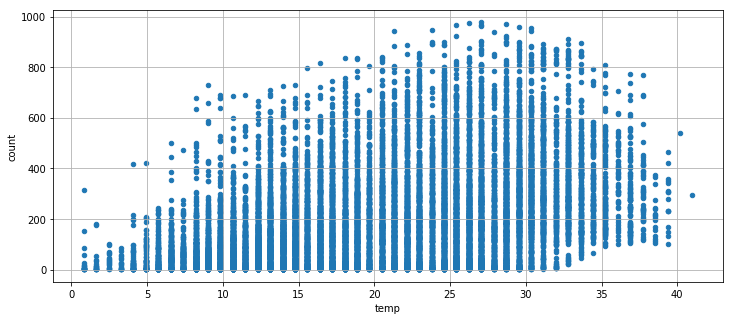

In [228]:
raw_all.plot.scatter(y='count', x='temp', grid=True, figsize=(12,5))
plt.show()

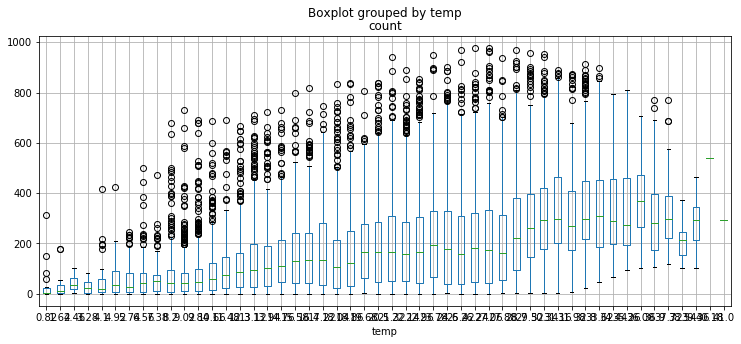

In [229]:
raw_all.boxplot(column='count', by='temp', grid=True, figsize=(12,5))
plt.show()

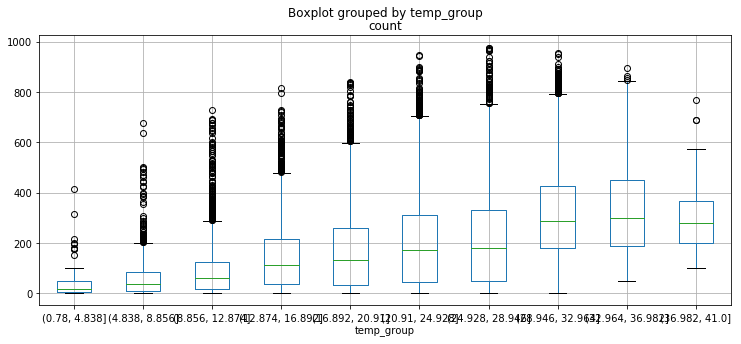

In [230]:
raw_all.boxplot(column='count', by='temp_group', grid=True, figsize=(12,5))
plt.show()

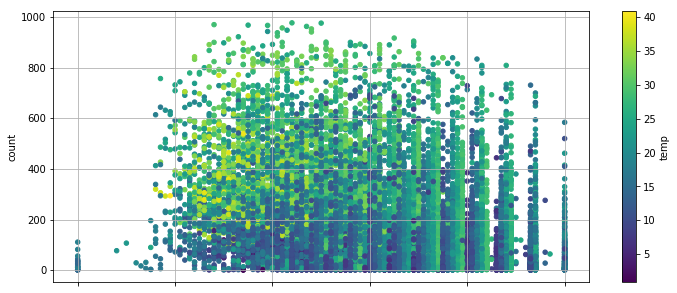

In [231]:
raw_all.plot.scatter(y='count', x='humidity', c='temp', grid=True, figsize=(12,5), colormap='viridis')
plt.show()

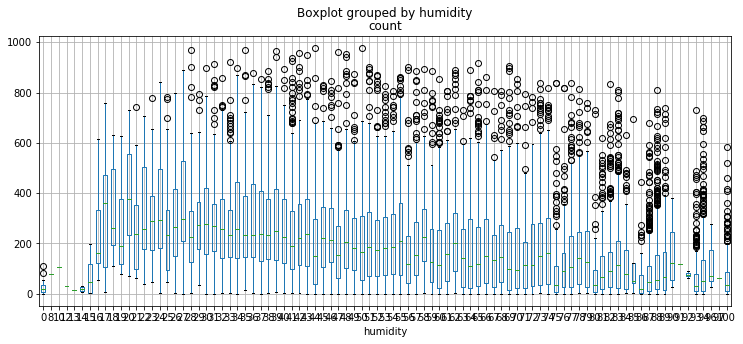

In [232]:
raw_all.boxplot(column='count', by='humidity', grid=True, figsize=(12,5))
plt.show()

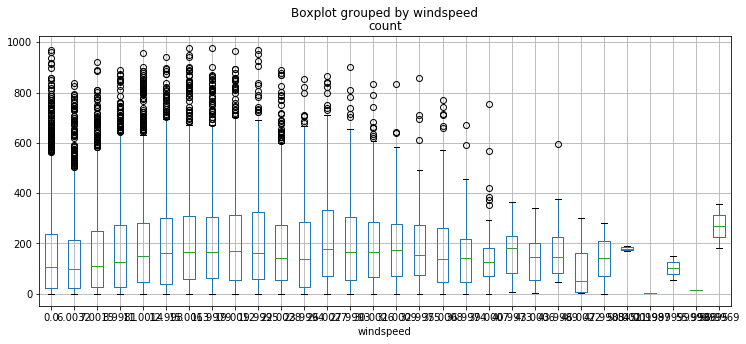

In [233]:
raw_all.boxplot(column='count', by='windspeed', grid=True, figsize=(12,5))
plt.show()

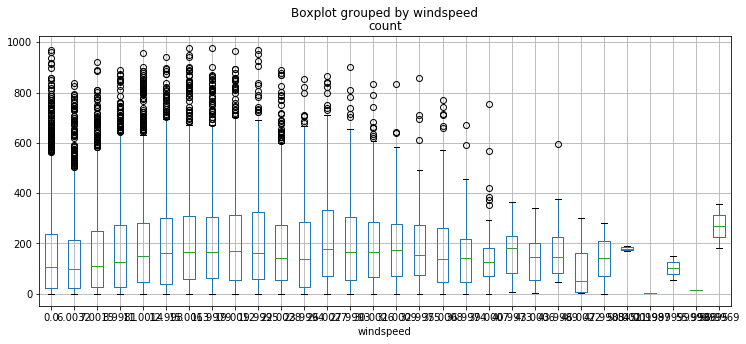

In [234]:
raw_all.boxplot(column='count', by='windspeed', grid=True, figsize=(12,5))
plt.show()

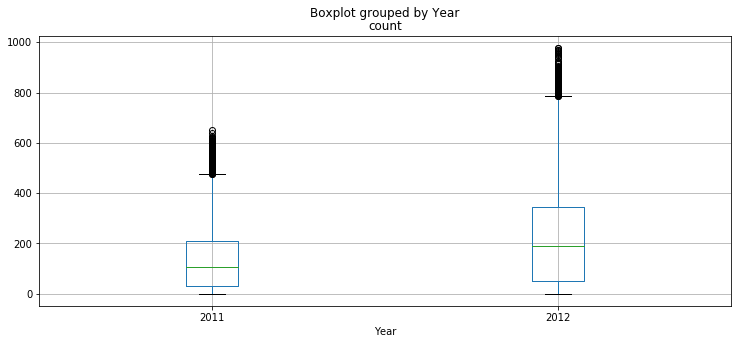

In [235]:
raw_all.boxplot(column='count', by='Year', grid=True, figsize=(12,5))
plt.show()

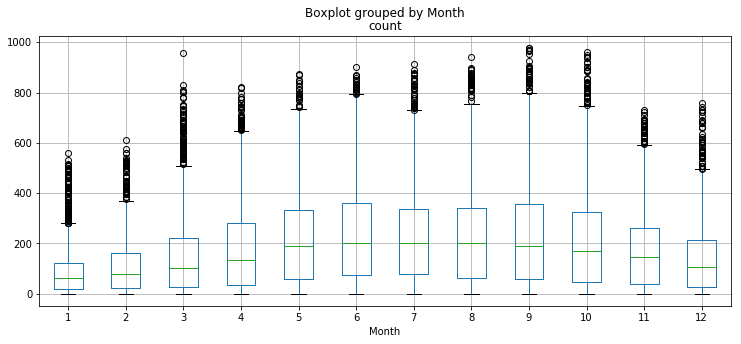

In [236]:
raw_all.boxplot(column='count', by='Month', grid=True, figsize=(12,5))
plt.show()

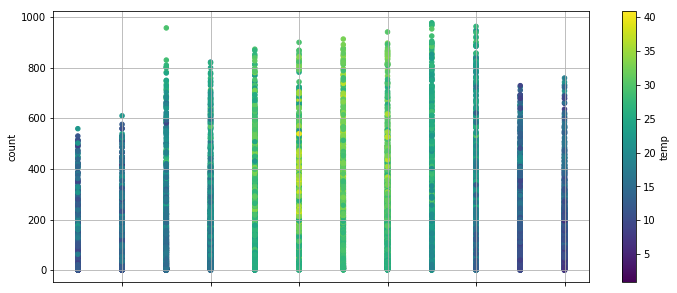

In [237]:
raw_all.plot.scatter(y='count', x='Month', c='temp', grid=True, figsize=(12,5), colormap='viridis')
plt.show()

In [238]:
# pd.plotting.scatter_matrix(raw_all, figsize=(18,18), diagonal='kde')
# plt.show()

<img src='https://github.com/cheonbi/DataScience/blob/master/Image/Scatter_Matrix.png?raw=true' width='700'>

In [239]:
# raw_all.corr()
# raw_all.corr().style.background_gradient()
# raw_all.corr().style.background_gradient().set_precision(2)

In [240]:
raw_all.corr().style.background_gradient().set_precision(2).set_properties(**{'font-size': '15pt'})

In [241]:
raw_all.corr().iloc[:,8:11]

casual  registered  count
season            0.12        0.18   0.18
holiday           0.03       -0.05  -0.04
workingday       -0.30        0.13   0.03
weather          -0.16       -0.13  -0.15
temp              0.46        0.34   0.41
...                ...         ...    ...
count_lag1        0.65        0.80   0.85
count_lag2        0.58        0.53   0.60
Quater_Dummy_2    0.15        0.06   0.09
Quater_Dummy_3    0.17        0.13   0.15
Quater_Dummy_4   -0.10       -0.00  -0.03

[27 rows x 3 columns]

In [242]:
raw_all.corr().loc[:, ['casual', 'registered', 'count']]

casual  registered  count
season            0.12        0.18   0.18
holiday           0.03       -0.05  -0.04
workingday       -0.30        0.13   0.03
weather          -0.16       -0.13  -0.15
temp              0.46        0.34   0.41
...                ...         ...    ...
count_lag1        0.65        0.80   0.85
count_lag2        0.58        0.53   0.60
Quater_Dummy_2    0.15        0.06   0.09
Quater_Dummy_3    0.17        0.13   0.15
Quater_Dummy_4   -0.10       -0.00  -0.03

[27 rows x 3 columns]

In [243]:
raw_all.corr().loc[:, ['casual', 'registered', 'count']].style.background_gradient().set_precision(2).set_properties(**{'font-size': '15pt'})

In [244]:
raw_all.corr().iloc[0:8,8:11].style.background_gradient().set_precision(2).set_properties(**{'font-size': '15pt'})

# Data Split
**1. Import Library**  
**2. Data Loading**  [(Data Source and Description)](https://www.kaggle.com/c/bike-sharing-demand/data)  
**3. Feature Engineering(Rearrange of Data)**  
**4. Data Understanding(Descriptive Statistics and Getting Insight from Features)**  
**5. Data Split: Train/Validate/Test Sets**  

In [332]:
# raw_all.isnull().sum().unique()

In [333]:
# for x in raw_all.columns:
#     if x not in Y_colname+X_remove:
#         print(x)

In [334]:
# Confirm of input and output
Y_colname = ['count']
X_remove = ['datetime', 'temp_group', 'casual', 'registered']
X_colname = [x for x in raw_all.columns if x not in Y_colname+X_remove]
X_colname

['season',
 'holiday',
 'workingday',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'windspeed',
 'count_trend',
 'count_seasonal',
 'count_Day',
 'count_Week',
 'count_diff',
 'Year',
 'Quater_ver2',
 'Month',
 'Day',
 'Hour',
 'DayofWeek',
 'count_lag1',
 'count_lag2',
 'Quater_Dummy_2',
 'Quater_Dummy_3',
 'Quater_Dummy_4']

In [335]:
# for a non time-series
# raw_train, raw_test = train_test_split(raw_all, test_size=0.2, random_state=123)
# print(raw_train.shape, raw_test.shape)
# raw_train
X_train, X_test, Y_train, Y_test = train_test_split(raw_all[X_colname], raw_all[Y_colname], test_size=0.2, random_state=123)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)
X_train

(14035, 24) (14035, 1)
(3509, 24) (3509, 1)


season  holiday  workingday  weather  temp  atemp  \
DateTime                                                                 
2011-10-13 06:00:00       4        0           1        3 22.14  25.76   
2011-01-16 00:00:00       1        0           0        1 10.66  15.15   
2012-08-19 13:00:00       3        0           0        3 26.24  28.79   
2012-07-10 18:00:00       3        0           1        3 28.70  33.34   
2011-05-18 09:00:00       2        0           1        3 22.96  26.52   
...                     ...      ...         ...      ...   ...    ...   
2011-01-05 00:00:00       1        0           1        1  8.20  12.88   
2012-07-13 19:00:00       3        0           1        1 30.34  33.34   
2011-11-20 11:00:00       4        0           0        2 20.50  24.24   
2012-10-02 17:00:00       4        0           1        3 25.42  28.03   
2012-10-17 05:00:00       4        0           1        2 14.76  18.94   

                     humidity  windspeed  count_trend  count_seasonal  \
DateTime                                                                
2011-10-13 06:00:00       100       6.00       107.25         -112.33   
2011-01-16 00:00:00        56       0.00        54.31         -134.25   
2012-08-19 13:00:00        83       9.00       180.31           65.21   
2012-07-10 18:00:00        74      15.00       260.67          236.38   
2011-05-18 09:00:00        83      17.00       161.56           30.51   
...                       ...        ...          ...             ...   
2011-01-05 00:00:00        64       0.00        66.48         -134.25   
2012-07-13 19:00:00        51      11.00       311.67          122.70   
2011-11-20 11:00:00        63       7.00       148.02           19.32   
2012-10-02 17:00:00        88       7.00       194.73          273.37   
2012-10-17 05:00:00        81       0.00       308.65         -168.28   

                          ...        Quater_ver2  Month  Day  Hour  DayofWeek  \
DateTime                  ...                                                   
2011-10-13 06:00:00       ...                  4     10   13     6          3   
2011-01-16 00:00:00       ...                  1      1   16     0          6   
2012-08-19 13:00:00       ...                  7      8   19    13          6   
2012-07-10 18:00:00       ...                  7      7   10    18          1   
2011-05-18 09:00:00       ...                  2      5   18     9          2   
...                       ...                ...    ...  ...   ...        ...   
2011-01-05 00:00:00       ...                  1      1    5     0          2   
2012-07-13 19:00:00       ...                  7      7   13    19          4   
2011-11-20 11:00:00       ...                  4     11   20    11          6   
2012-10-02 17:00:00       ...                  8     10    2    17          1   
2012-10-17 05:00:00       ...                  8     10   17     5          2   

                     count_lag1  count_lag2  Quater_Dummy_2  Quater_Dummy_3  \
DateTime                                                                      
2011-10-13 06:00:00       17.00        7.00               0               0   
2011-01-16 00:00:00       44.00       26.00               0               0   
2012-08-19 13:00:00      298.00      272.00               0               1   
2012-07-10 18:00:00      872.00      435.00               0               1   
2011-05-18 09:00:00      453.00      274.00               1               0   
...                         ...         ...             ...             ...   
2011-01-05 00:00:00       11.00       35.00               0               0   
2012-07-13 19:00:00      631.00      835.00               0               1   
2011-11-20 11:00:00      229.00      138.00               0               0   
2012-10-02 17:00:00      374.00      209.00               0               0   
2012-10-17 05:00:00        4.00        7.00               0               0   

                     Quate

In [336]:
# for a time-series
raw_train = raw_all.loc[raw_all.index < '2012-07-01',:]
raw_test = raw_all.loc[raw_all.index >= '2012-07-01',:]
print(raw_train.shape, raw_test.shape)

(13128, 29) (4416, 29)


In [337]:
Y_train = raw_train[Y_colname]
X_train = raw_train[X_colname]
Y_test = raw_test[Y_colname]
X_test = raw_test[X_colname]
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(13128, 24) (13128, 1)
(4416, 24) (4416, 1)


In [338]:
# # Functionalize
# def datasplit_cs(raw, Y_colname, X_colname, test_size, random_seed=123):
#     X_train, X_test, Y_train, Y_test = train_test_split(raw[X_colname], raw[Y_colname], test_size=test_size, random_state=random_seed)
#     print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
#     print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)
#     return X_train, X_test, Y_train, Y_test
# X_train, X_test, Y_train, Y_test = datasplit_cs(raw_all, Y_colname, X_colname, 0.2)

# def datasplit_ts(raw, Y_colname, X_colname, criteria):
#     raw_train = raw.loc[raw_all.index < criteria,:]
#     raw_test = raw.loc[raw_all.index >= criteria,:]
#     Y_train = raw_train[Y_colname]
#     X_train = raw_train[X_colname]
#     Y_test = raw_test[Y_colname]
#     X_test = raw_test[X_colname]
#     print('Train_size:', raw_train.shape, 'Test_size:', raw_test.shape)
#     print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
#     print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)
#     return X_train, X_test, Y_train, Y_test
# X_train, X_test, Y_train, Y_test = datasplit_ts(raw_all, Y_colname, X_colname, '2012-07-01')

# Applying Base Model
**1. Import Library**  
**2. Data Loading**  [(Data Source and Description)](https://www.kaggle.com/c/bike-sharing-demand/data)  
**3. Feature Engineering(Rearrange of Data)**  
**4. Data Understanding(Descriptive Statistics and Getting Insight from Features)**  
**5. Data Split: Train/Validate/Test Sets**  
**6. Applying Base Model**  

In [339]:
# LinearRegression (using statsmodels)
model_fit_reg1 = sm.OLS(Y_train, X_train).fit()
model_fit_reg1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.362e+08
Date:                Wed, 27 Feb 2019   Prob (F-statistic):               0.00
Time:                        15:08:34   Log-Likelihood:                 1906.2
No. Observations:               13128   AIC:                            -3764.
Df Residuals:                   13104   BIC:                            -3585.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
season            -0.0005      0.004     -0.129      0.897      -0.009       0.008
holiday            0.0083      0.014      0.612      0.540      -0.018       0.035
workingday         0.0079      0.007      1.184      0.236      -0.005       0.021
weather            0.0042      0.003      1.232      0.218      -0.003       0.011
temp               0.0022      0.002      1.075      0.282      -0.002       0.006
atemp             -0.0025      0.002     -1.347      0.178      -0.006       0.001
humidity          -0.0001      0.000     -0.845      0.398      -0.000       0.000
windspeed          0.0003      0.000      1.062      0.288      -0.000       0.001
count_trend     9.161e-05   8.57e-05      1.069      0.285   -7.64e-05       0.000
count_seasonal  1.984e-05   2.56e-05      0.775      0.438   -3.03e-05       7e-05
count_Day       4.177e-05   8.36e-05      0.500      0.617      -0.000       0.000
count_Week     -4.345e-05   9.61e-05     -0.452      0.651      -0.000       0.000
count_diff         1.0000    2.9e-05   3.45e+04      0.000       1.000       1.000
Year           -1.547e-05   7.97e-06     -1.939      0.052   -3.11e-05    1.66e-07
Quater_ver2        0.0004      0.002      0.180      0.857      -0.004       0.005
Month              0.0026      0.002      1.051      0.293      -0.002       0.007
Day                0.0004      0.000      1.728      0.084   -4.91e-05       0.001
Hour               0.0006      0.000      1.538      0.124      -0.000       0.001
DayofWeek          0.0003      0.002      0.224      0.823      -0.003       0.003
count_lag1         1.0000    2.7e-05    3.7e+04      0.000       1.000       1.000
count_lag2     -1.926e-05   2.59e-05     -0.744      0.457      -7e-05    3.15e-05
Quater_Dummy_2    -0.0010      0.009     -0.115      0.909      -0.019       0.017
Quater_Dummy_3    -0.0037      0.017     -0.220      0.826      -0.037       0.030
Quater_Dummy_4    -0.0132      0.026     -0.512      0.609      -0.064       0.037
==============================================================================
Omnibus:                    54426.083   Durbin-Watson:                   1.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      93552024983.782
Skew:                        -114.255   Prob(JB):                         0.00
Kurtosis:                   13078.751   Cond. No.                     3.49e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.49e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [361]:
# display(model_fit_reg1.predict(X_train))
# display(model_fit_reg1.predict(X_test))
model_pred_tr_reg1 = model_fit_reg1.predict(X_train).values
model_pred_te_reg1 = model_fit_reg1.predict(X_test).values

# Evaluation
**1. Import Library**  
**2. Data Loading**  [(Data Source and Description)](https://www.kaggle.com/c/bike-sharing-demand/data)  
**3. Feature Engineering(Rearrange of Data)**  
**4. Data Understanding(Descriptive Statistics and Getting Insight from Features)**  
**5. Data Split: Train/Validate/Test Sets**  
**6. Applying Base Model**  
**7. Evaluation**  

In [360]:
# pd.concat([Y_train, pd.DataFrame(model_pred_tr_reg1, index=Y_train.index, columns=['prediction'])], axis=1)

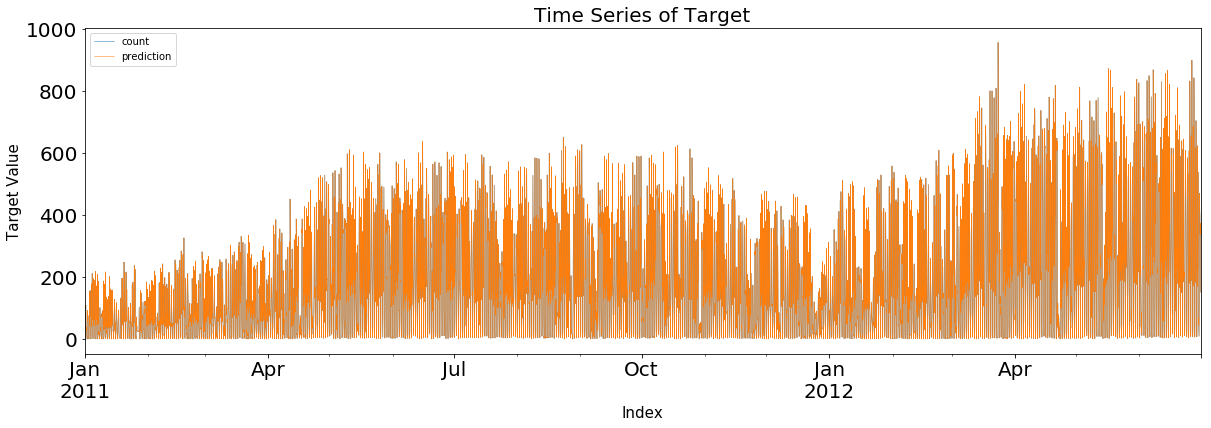

MAD  MSE  MAPE
Score 0.01 0.04  0.06

In [365]:
pd.concat([Y_train, pd.DataFrame(model_pred_tr_reg1, index=Y_train.index, columns=['prediction'])], axis=1).plot(kind='line', figsize=(20,6),
                                                                                                               xlim=(Y_train.index.min(),Y_train.index.max()),
                                                                                                               linewidth=0.5, fontsize=20)
plt.title('Time Series of Target', fontsize=20)
plt.xlabel('Index', fontsize=15)
plt.ylabel('Target Value', fontsize=15)
plt.show()

MAD = abs(Y_train.values.flatten() - model_pred_tr_reg1).mean()
MSE = ((Y_train.values.flatten() - model_pred_tr_reg1)**2).mean()
MAPE = (abs(Y_train.values.flatten() - model_pred_tr_reg1)/Y_train.values.flatten()*100).mean()

display(pd.DataFrame([MAD, MSE, MAPE], index=['MAD', 'MSE', 'MAPE'], columns=['Score']).T)

In [391]:
# # Functionalize
# def evaluation(Y_real, Y_pred, graph_on=False):
#     loss_length = len(Y_real.values.flatten()) - len(Y_pred)
#     if loss_length != 0:
#         Y_real = Y_real[loss_length:]
#     if graph_on == True:
#         pd.concat([Y_real, pd.DataFrame(Y_pred, index=Y_real.index, columns=['prediction'])], axis=1).plot(kind='line', figsize=(20,6),
#                                                                                                            xlim=(Y_real.index.min(),Y_real.index.max()),
#                                                                                                            linewidth=3, fontsize=20)
#         plt.title('Time Series of Target', fontsize=20)
#         plt.xlabel('Index', fontsize=15)
#         plt.ylabel('Target Value', fontsize=15)
#     MAD = abs(Y_real.values.flatten() - Y_pred).mean()
#     MSE = ((Y_real.values.flatten() - Y_pred)**2).mean()
#     MAPE = (abs(Y_real.values.flatten() - Y_pred)/Y_real.values.flatten()*100).mean()
#     Score = pd.DataFrame([MAD, MSE, MAPE], index=['MAD', 'MSE', 'MAPE'], columns=['Score']).T
#     Residual = pd.DataFrame(Y_real.values.flatten() - Y_pred, index=Y_real.index, columns=['Error'])
#     return Score, Residual
# # Score_tr, Residual_tr = evaluation(Y_train, model_pred_tr_reg1, graph_on=True)
# # Score_tr

# def evaluation_trte(Y_real_tr, Y_pred_tr, Y_real_te, Y_pred_te, graph_on=False):
#     Score_tr, Residual_tr = evaluation(Y_real_tr, Y_pred_tr, graph_on=graph_on)
#     Score_te, Residual_te = evaluation(Y_real_te, Y_pred_te, graph_on=graph_on)
#     Score_trte = pd.concat([Score_tr, Score_te], axis=0)
#     Score_trte.index = ['Train', 'Test']
#     return Score_trte, Residual_tr, Residual_te
# Score1, Resid_tr_reg1, Resid_te_reg1 = evaluation_trte(Y_train, model_pred_tr_reg1, Y_test, model_pred_te_reg1, graph_on=True)
# Score1

# Error Analysis
**1. Import Library**  
**2. Data Loading**  [(Data Source and Description)](https://www.kaggle.com/c/bike-sharing-demand/data)  
**3. Feature Engineering(Rearrange of Data)**  
**4. Data Understanding(Descriptive Statistics and Getting Insight from Features)**  
**5. Data Split: Train/Validate/Test Sets**  
**6. Applying Base Model**  
**7. Evaluation**  
**8. Error Analysis**  

In [420]:
# pd.Series(sm.tsa.stattools.adfuller(Resid_tr_reg1['Error'])
# sm.tsa.stattools.adfuller(Resid_tr_reg1['Error'])
# pd.Series(sm.tsa.stattools.adfuller(Resid_tr_reg1['Error'])[0:4], index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])

Stationarity  Normality  Autocorr(lag1)  \
Test Statistics                      -9.98       0.01            0.00   
p-value                               0.00       0.00            0.98   
Alternative                            nan        nan             nan   
Used Lag                             41.00        nan             nan   
Used Observations                13,086.00        nan             nan   
Critical Value(1%)                   -3.43        nan             nan   
Critical Value(5%)                   -2.86        nan             nan   
Critical Value(10%)                  -2.57        nan             nan   
Maximum Information Criteria   -106,845.57        nan             nan   

                              Autocorr(lag5)  Autocorr(lag10)  \
Test Statistics                         0.01             0.03   
p-value                                 1.00             1.00   
Alternative                              nan              nan   
Used Lag                                 nan              nan   
Used Observations                        nan              nan   
Critical Value(1%)                       nan              nan   
Critical Value(5%)                       nan              nan   
Critical Value(10%)                      nan              nan   
Maximum Information Criteria             nan              nan   

                              Autocorr(lag50) Heteroscedasticity  
Test Statistics                          0.10               0.00  
p-value                                  1.00               0.00  
Alternative                               nan          two-sided  
Used Lag                                  nan                NaN  
Used Observations                         nan                NaN  
Critical Value(1%)                        nan                NaN  
Critical Value(5%)                        nan                NaN  
Critical Value(10%)                       nan                NaN  
Maximum Information Criteria              nan                NaN

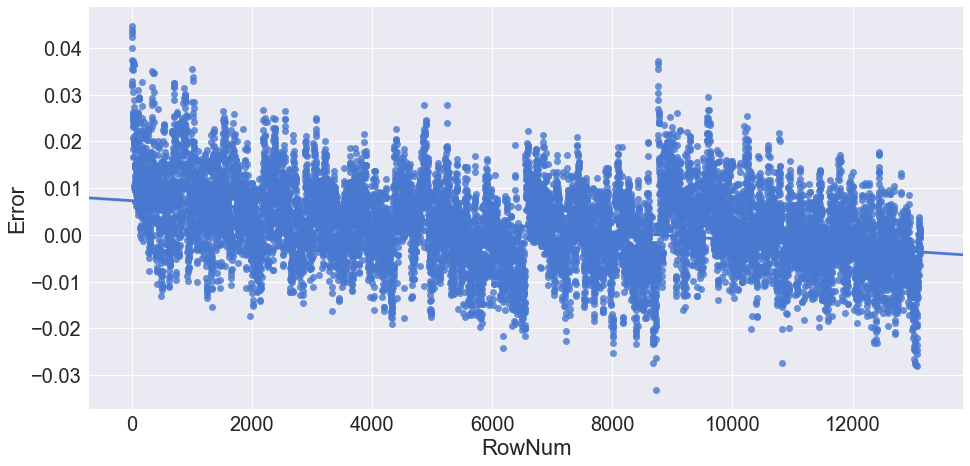

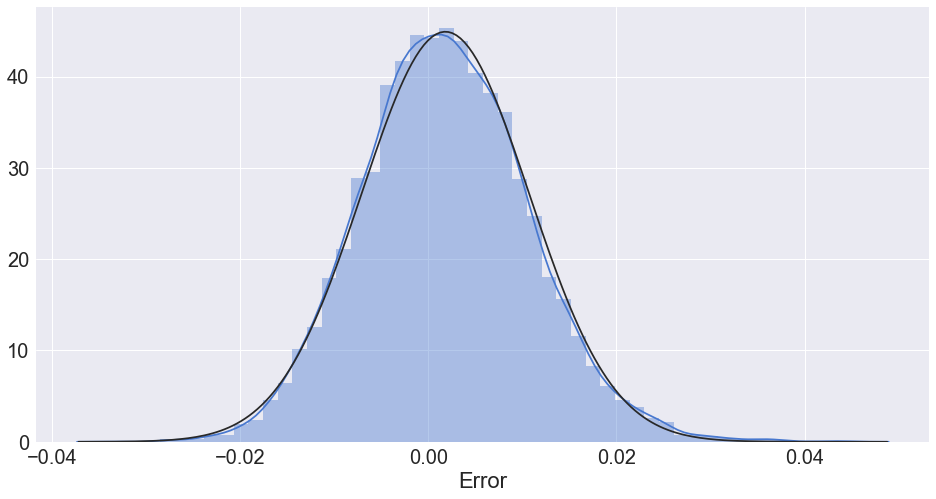

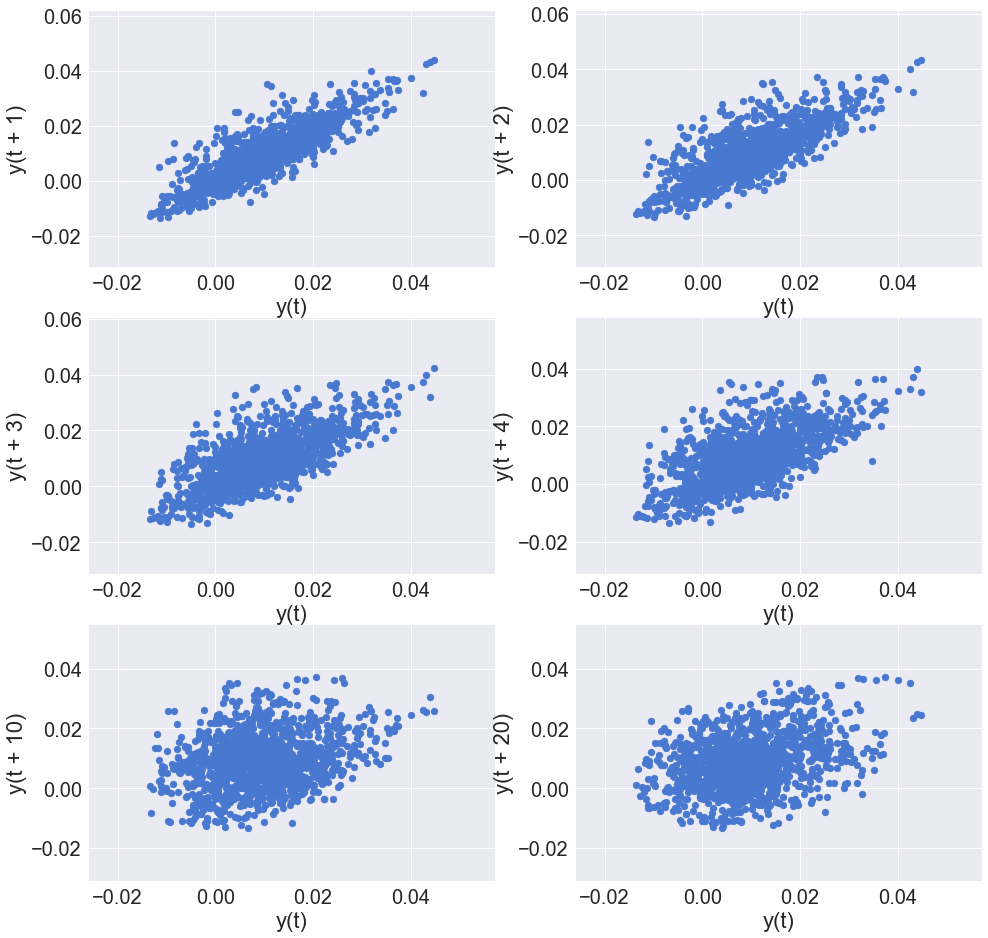

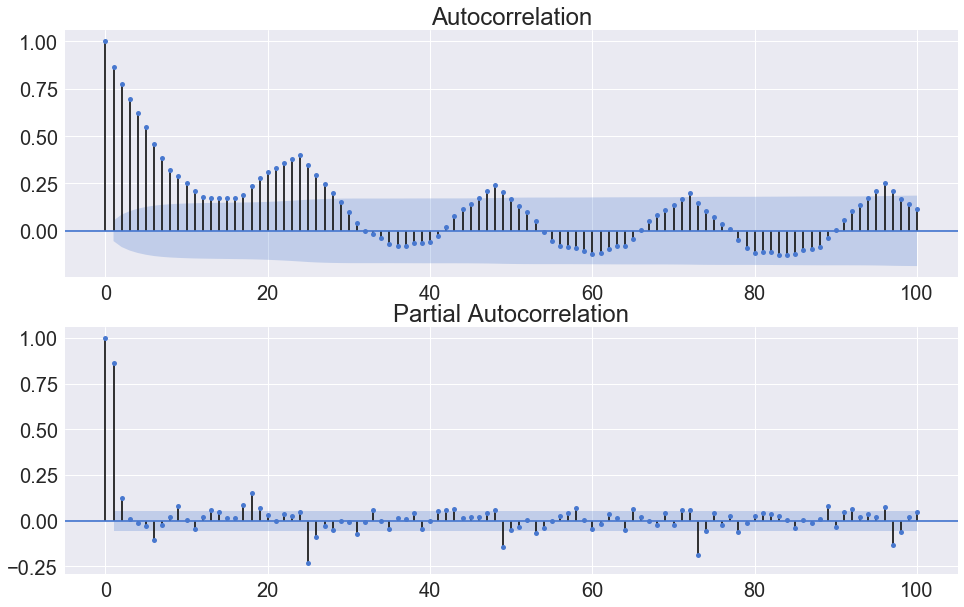

In [422]:
# Error Analysis(Plot)
Resid_tr_reg1['RowNum'] = Resid_tr_reg1.reset_index().index

# Stationarity(Trend) Analysis
sns.set(palette="muted", color_codes=True, font_scale=2)
sns.lmplot(x='RowNum', y='Error', data=Resid_tr_reg1.iloc[1:],
           fit_reg='True', size=7, aspect=2, ci=99, sharey=True)

# Normal Distribution Analysis
figure, axes = plt.subplots(figsize=(16,8))
sns.distplot(Resid_tr_reg1['Error'].iloc[1:], norm_hist='True', fit=stats.norm)

# Lag Analysis
length = int(len(Resid_tr_reg1['Error'])/10)
figure, axes = plt.subplots(3, 2, figsize=(16,16))
pd.plotting.lag_plot(Resid_tr_reg1['Error'].iloc[1:length], lag=1, ax=axes[0,0])
pd.plotting.lag_plot(Resid_tr_reg1['Error'].iloc[1:length], lag=2, ax=axes[0,1])
pd.plotting.lag_plot(Resid_tr_reg1['Error'].iloc[1:length], lag=3, ax=axes[1,0])
pd.plotting.lag_plot(Resid_tr_reg1['Error'].iloc[1:length], lag=4, ax=axes[1,1])
pd.plotting.lag_plot(Resid_tr_reg1['Error'].iloc[1:length], lag=10, ax=axes[2,0])
pd.plotting.lag_plot(Resid_tr_reg1['Error'].iloc[1:length], lag=20, ax=axes[2,1])

# Autocorrelation Analysis
figure, axes = plt.subplots(2,1,figsize=(16,10))
figure = sm.graphics.tsa.plot_acf(Resid_tr_reg1['Error'].iloc[1:length], lags=100, use_vlines=True, ax=axes[0])
figure = sm.graphics.tsa.plot_pacf(Resid_tr_reg1['Error'].iloc[1:length], lags=100, use_vlines=True, ax=axes[1])

# Error Analysis(Statistics)
# Checking Stationarity
# Null Hypothesis: The Time-series is non-stationalry
Stationarity = pd.Series(sm.tsa.stattools.adfuller(Resid_tr_reg1['Error'])[0:4], index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
for key, value in sm.tsa.stattools.adfuller(Resid_tr_reg1['Error'])[4].items():
    Stationarity['Critical Value(%s)'%key] = value
Stationarity['Maximum Information Criteria'] = sm.tsa.stattools.adfuller(Resid_tr_reg1['Error'])[5]
Stationarity = pd.DataFrame(Stationarity, columns=['Stationarity'])

# Checking of Normality
# Null Hypothesis: The residuals are normally distributed
Normality = pd.DataFrame([stats.shapiro(Resid_tr_reg1['Error'])], index=['Normality'], columns=['Test Statistics', 'p-value']).T

# Checking for Autocorrelation
# Null Hypothesis: Autocorrelation is absent
Autocorrelation = pd.concat([pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Resid_tr_reg1['Error'], lags=[1,5,10,50])[0], columns=['Test Statistics']),
                             pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Resid_tr_reg1['Error'], lags=[1,5,10,50])[1], columns=['p-value'])], axis=1).T
Autocorrelation.columns = ['Autocorr(lag1)', 'Autocorr(lag5)', 'Autocorr(lag10)', 'Autocorr(lag50)']

# Checking Heteroscedasticity
# Null Hypothesis: Error terms are homoscedastic
Heteroscedasticity = pd.DataFrame([sm.stats.diagnostic.het_goldfeldquandt(Resid_tr_reg1['Error'], X_train.values, alternative='two-sided')],
                                  index=['Heteroscedasticity'], columns=['Test Statistics', 'p-value', 'Alternative']).T
Error_Analysis = pd.concat([Stationarity, Normality, Autocorrelation, Heteroscedasticity], join='outer', axis=1)
Error_Analysis = Error_Analysis.loc[['Test Statistics', 'p-value', 'Alternative', 'Used Lag', 'Used Observations',
                                     'Critical Value(1%)', 'Critical Value(5%)', 'Critical Value(10%)',
                                     'Maximum Information Criteria'],:]
Error_Analysis

Stationarity  Normality  Autocorr(lag1)  \
Test Statistics                      -9.82       1.00        9,615.96   
p-value                               0.00       0.00            0.00   
Alternative                            nan        nan             nan   
Used Lag                             41.00        nan             nan   
Used Observations                13,085.00        nan             nan   
Critical Value(1%)                   -3.43        nan             nan   
Critical Value(5%)                     nan        nan             nan   
Critical Value(10%)                    nan        nan             nan   
Maximum Information Criteria   -106,838.93        nan             nan   

                              Autocorr(lag5)  Autocorr(lag10)  \
Test Statistics                    32,903.39        47,262.88   
p-value                                 0.00             0.00   
Alternative                              nan              nan   
Used Lag                                 nan              nan   
Used Observations                        nan              nan   
Critical Value(1%)                       nan              nan   
Critical Value(5%)                       nan              nan   
Critical Value(10%)                      nan              nan   
Maximum Information Criteria             nan              nan   

                              Autocorr(lag50) Heteroscedasticity  
Test Statistics                    116,653.97               1.42  
p-value                                  0.00               0.00  
Alternative                               nan          two-sided  
Used Lag                                  nan                NaN  
Used Observations                         nan                NaN  
Critical Value(1%)                        nan                NaN  
Critical Value(5%)                        nan                NaN  
Critical Value(10%)                       nan                NaN  
Maximum Information Criteria              nan                NaN

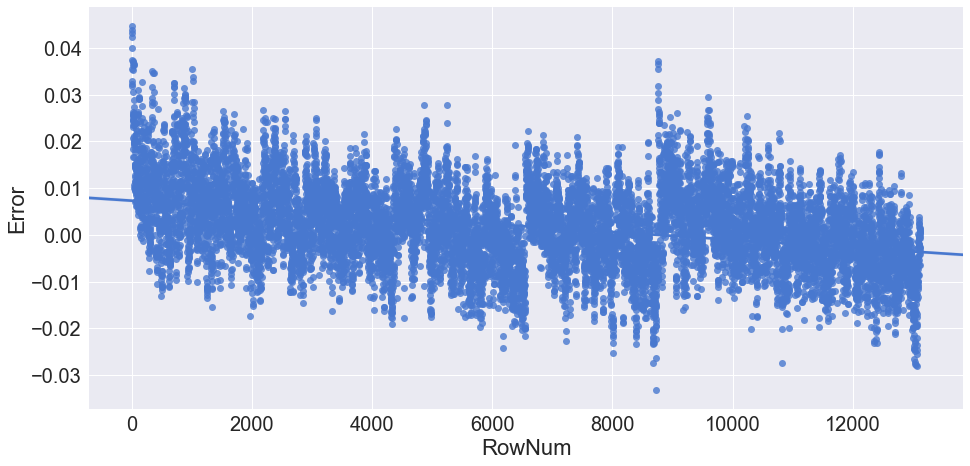

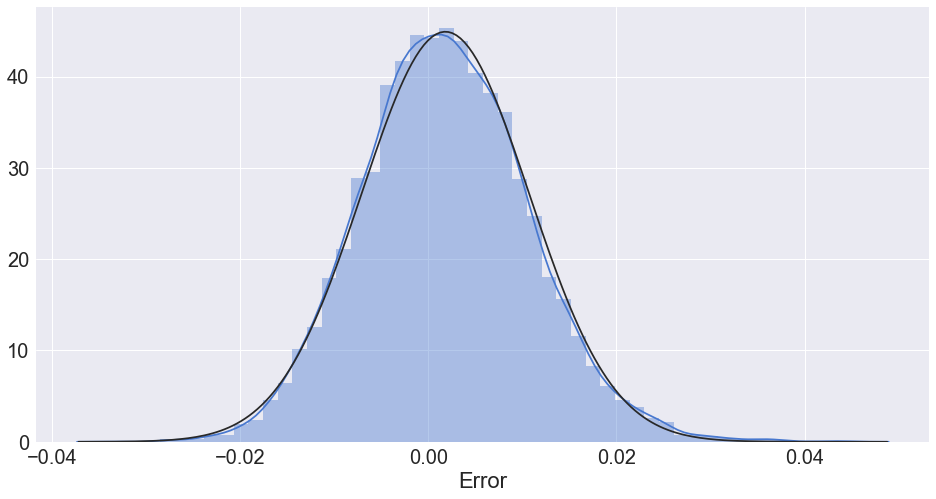

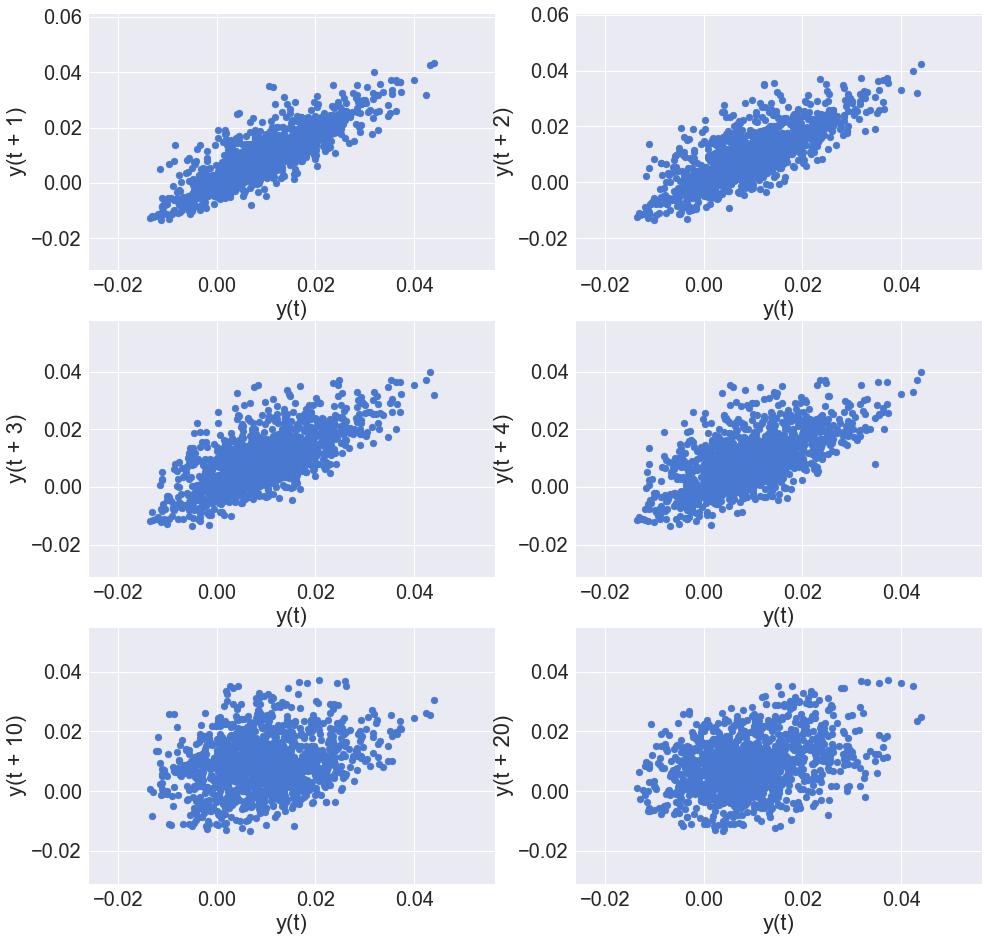

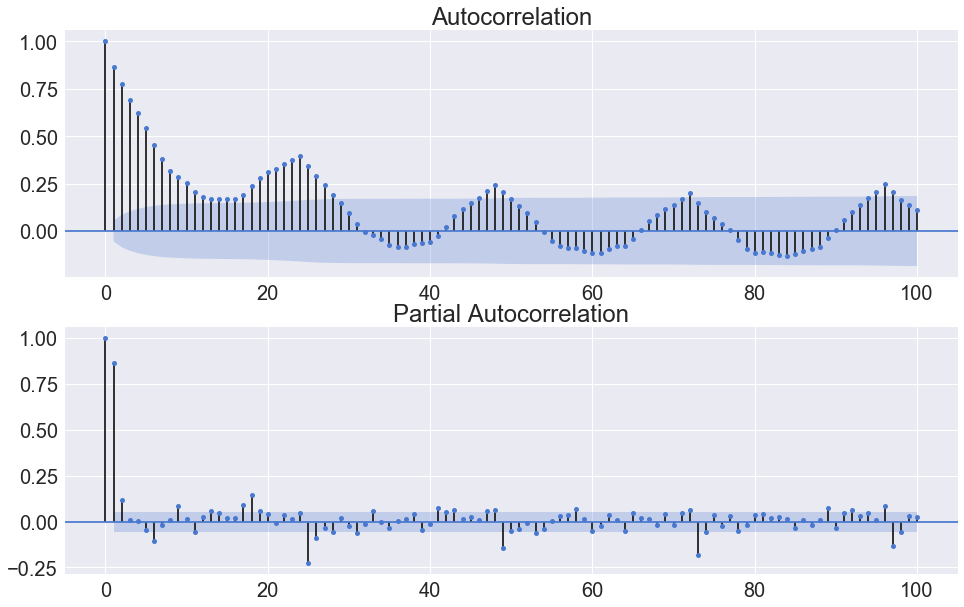

In [425]:
# # Functionalize
# def error_analysis(Y_Data, Target_name, X_Data, graph_on=False):
#     for x in Target_name:
#         Target_name = x
#     X_Data = X_Data.loc[Y_Data.index]

#     if graph_on == True:
#         ##### Error Analysis(Plot)
#         Y_Data['RowNum'] = Y_Data.reset_index().index

#         # Stationarity(Trend) Analysis
#         sns.set(palette="muted", color_codes=True, font_scale=2)
#         sns.lmplot(x='RowNum', y=Target_name, data=Y_Data, fit_reg='True', size=7, aspect=2, ci=99, sharey=True)
#         del Y_Data['RowNum']

#         # Normal Distribution Analysis
#         figure, axes = plt.subplots(figsize=(16,8))
#         sns.distplot(Y_Data[Target_name], norm_hist='True', fit=stats.norm)

#         # Lag Analysis
#         length = int(len(Y_Data[Target_name])/10)
#         figure, axes = plt.subplots(3, 2, figsize=(16,16))
#         pd.plotting.lag_plot(Y_Data[Target_name].iloc[1:length], lag=1, ax=axes[0,0])
#         pd.plotting.lag_plot(Y_Data[Target_name].iloc[1:length], lag=2, ax=axes[0,1])
#         pd.plotting.lag_plot(Y_Data[Target_name].iloc[1:length], lag=3, ax=axes[1,0])
#         pd.plotting.lag_plot(Y_Data[Target_name].iloc[1:length], lag=4, ax=axes[1,1])
#         pd.plotting.lag_plot(Y_Data[Target_name].iloc[1:length], lag=10, ax=axes[2,0])
#         pd.plotting.lag_plot(Y_Data[Target_name].iloc[1:length], lag=20, ax=axes[2,1])

#         # Autocorrelation Analysis
#         figure, axes = plt.subplots(2,1,figsize=(16,10))
#         sm.graphics.tsa.plot_acf(Y_Data[Target_name].iloc[1:length], lags=100, use_vlines=True, ax=axes[0])
#         sm.graphics.tsa.plot_pacf(Y_Data[Target_name].iloc[1:length], lags=100, use_vlines=True, ax=axes[1])      

#     ##### Error Analysis(Statistics)
#     # Checking Stationarity
#     # Null Hypothesis: The Time-series is non-stationalry
#     Stationarity = pd.Series(sm.tsa.stattools.adfuller(Y_Data[Target_name])[0:4],
#                              index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
#     for key, value in sm.tsa.stattools.adfuller(Y_Data[Target_name])[4].items():
#         Stationarity['Critical Value(%s)'%key] = value
#         Stationarity['Maximum Information Criteria'] = sm.tsa.stattools.adfuller(Y_Data[Target_name])[5]
#         Stationarity = pd.DataFrame(Stationarity, columns=['Stationarity'])

#     # Checking of Normality
#     # Null Hypothesis: The residuals are normally distributed
#     Normality = pd.DataFrame([stats.shapiro(Y_Data[Target_name])],
#                              index=['Normality'], columns=['Test Statistics', 'p-value']).T

#     # Checking for Autocorrelation
#     # Null Hypothesis: Autocorrelation is absent
#     Autocorrelation = pd.concat([pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Y_Data[Target_name], lags=[1,5,10,50])[0], columns=['Test Statistics']),
#                                  pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Y_Data[Target_name], lags=[1,5,10,50])[1], columns=['p-value'])], axis=1).T
#     Autocorrelation.columns = ['Autocorr(lag1)', 'Autocorr(lag5)', 'Autocorr(lag10)', 'Autocorr(lag50)']

#     # Checking Heteroscedasticity
#     # Null Hypothesis: Error terms are homoscedastic
#     Heteroscedasticity = pd.DataFrame([sm.stats.diagnostic.het_goldfeldquandt(Y_Data[Target_name], X_Data.values, alternative='two-sided')],
#                                       index=['Heteroscedasticity'], columns=['Test Statistics', 'p-value', 'Alternative']).T
#     Score = pd.concat([Stationarity, Normality, Autocorrelation, Heteroscedasticity], join='outer', axis=1)
#     Score = Score.loc[['Test Statistics', 'p-value', 'Alternative', 'Used Lag', 'Used Observations',
#                        'Critical Value(1%)', 'Critical Value(5%)', 'Critical Value(10%)', 'Maximum Information Criteria'],:]
#     return Score
# error_analysis(Resid_tr_reg1[1:], ['Error'], X_train, graph_on=True)

# [Comparison]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 13 columns):
datetime      17379 non-null datetime64[ns]
season        17379 non-null int64
holiday       17379 non-null int64
workingday    17379 non-null int64
weather       17379 non-null int64
temp          17379 non-null float64
atemp         17379 non-null float64
humidity      17379 non-null int64
windspeed     17379 non-null float64
casual        17379 non-null int64
registered    17379 non-null int64
count         17379 non-null int64
DateTime      17379 non-null datetime64[ns]
dtypes: datetime64[ns](2), float64(3), int64(8)
memory usage: 1.7 MB
Train_size: (13128, 12) Test_size: (4416, 12)
X_train: (13128, 8) Y_train: (13128, 1)
X_test: (4416, 8) Y_test: (4416, 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.638
Model:                            OLS   Adj. R-squared:                  0.638
Method:                 Least Squares   F-statistic:                     2889.
Date:                Wed, 27 Feb 2019   Prob (F-statistic):               0.00
Time:                        17:32:08   Log-Likelihood:                -83421.
No. Observations:               13128   AIC:                         1.669e+05
Df Residuals:                   13120   BIC:                         1.669e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
season         3.3659      1.286      2.618      0.009       0.846       5.886
holiday       -6.2896      7.466     -0.842      0.400     -20.924       8.345
workingday    10.3553      2.641      3.921      0.000       5.178      15.533
weather        7.1906      2.093      3.436      0.001       3.089      11.292
temp          -7.8544      1.222     -6.429      0.000     -10.249      -5.460
atemp         16.0695      1.095     14.676      0.000      13.923      18.216
humidity      -1.7353      0.063    -27.356      0.000      -1.860      -1.611
windspeed      2.2749      0.136     16.745      0.000       2.009       2.541
==============================================================================
Omnibus:                     2168.771   Durbin-Watson:                   0.419
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3942.747
Skew:                           1.050   Prob(JB):                         0.00
Kurtosis:                       4.672   Cond. No.                         450.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

MAD       MSE   MAPE
Train 103.09 19,360.42 458.48
Test  150.03 43,410.27 316.61

Stationarity  Normality  Autocorr(lag1)  \
Test Statistics                      -9.25       0.94        8,204.84   
p-value                               0.00       0.00            0.00   
Alternative                            nan        nan             nan   
Used Lag                             40.00        nan             nan   
Used Observations                13,087.00        nan             nan   
Critical Value(1%)                   -3.43        nan             nan   
Critical Value(5%)                     nan        nan             nan   
Critical Value(10%)                    nan        nan             nan   
Maximum Information Criteria    143,252.82        nan             nan   

                              Autocorr(lag5)  Autocorr(lag10)  \
Test Statistics                    12,494.43        13,138.03   
p-value                                 0.00             0.00   
Alternative                              nan              nan   
Used Lag                                 nan              nan   
Used Observations                        nan              nan   
Critical Value(1%)                       nan              nan   
Critical Value(5%)                       nan              nan   
Critical Value(10%)                      nan              nan   
Maximum Information Criteria             nan              nan   

                              Autocorr(lag50) Heteroscedasticity  
Test Statistics                     48,485.56               0.00  
p-value                                  0.00               0.00  
Alternative                               nan          two-sided  
Used Lag                                  nan                NaN  
Used Observations                         nan                NaN  
Critical Value(1%)                        nan                NaN  
Critical Value(5%)                        nan                NaN  
Critical Value(10%)                       nan                NaN  
Maximum Information Criteria              nan                NaN

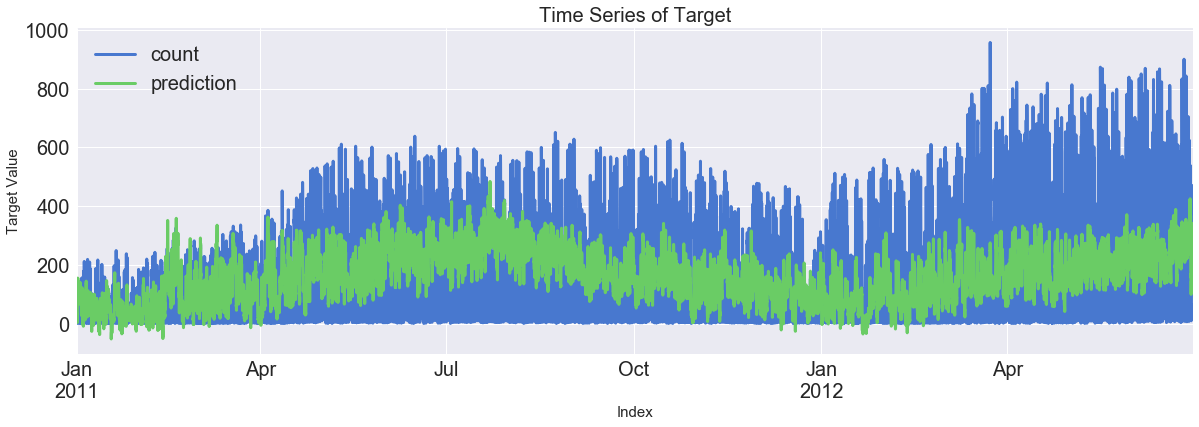

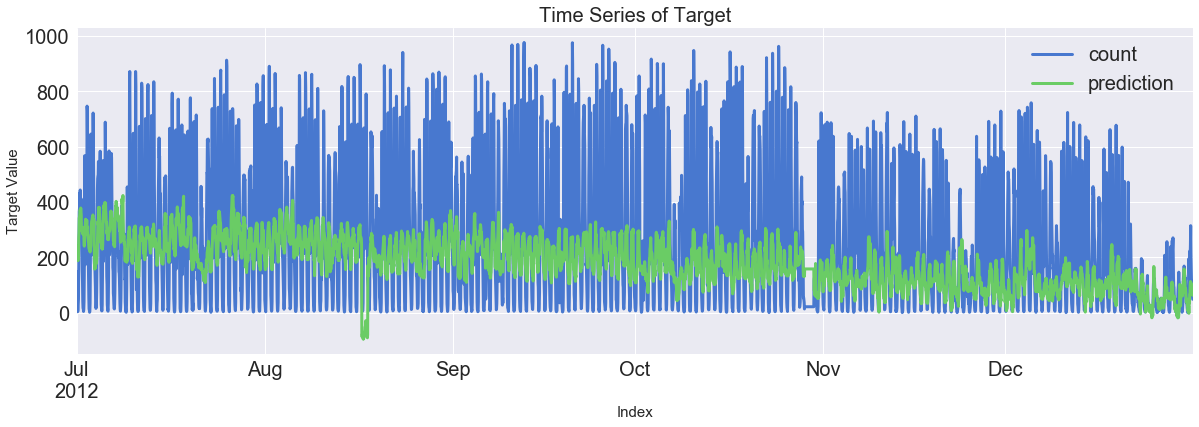

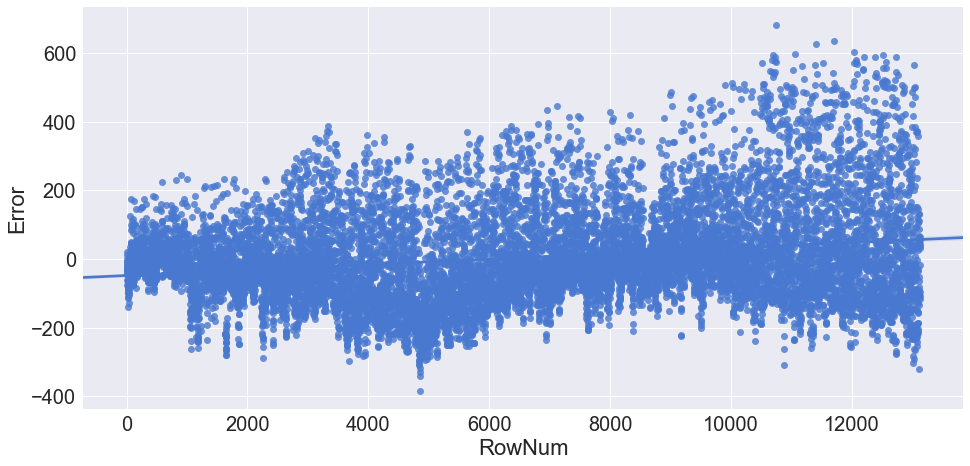

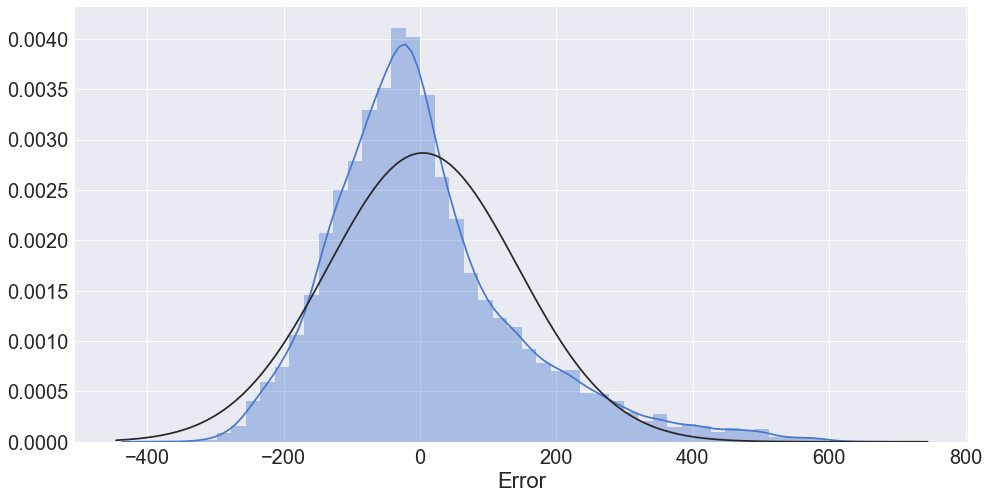

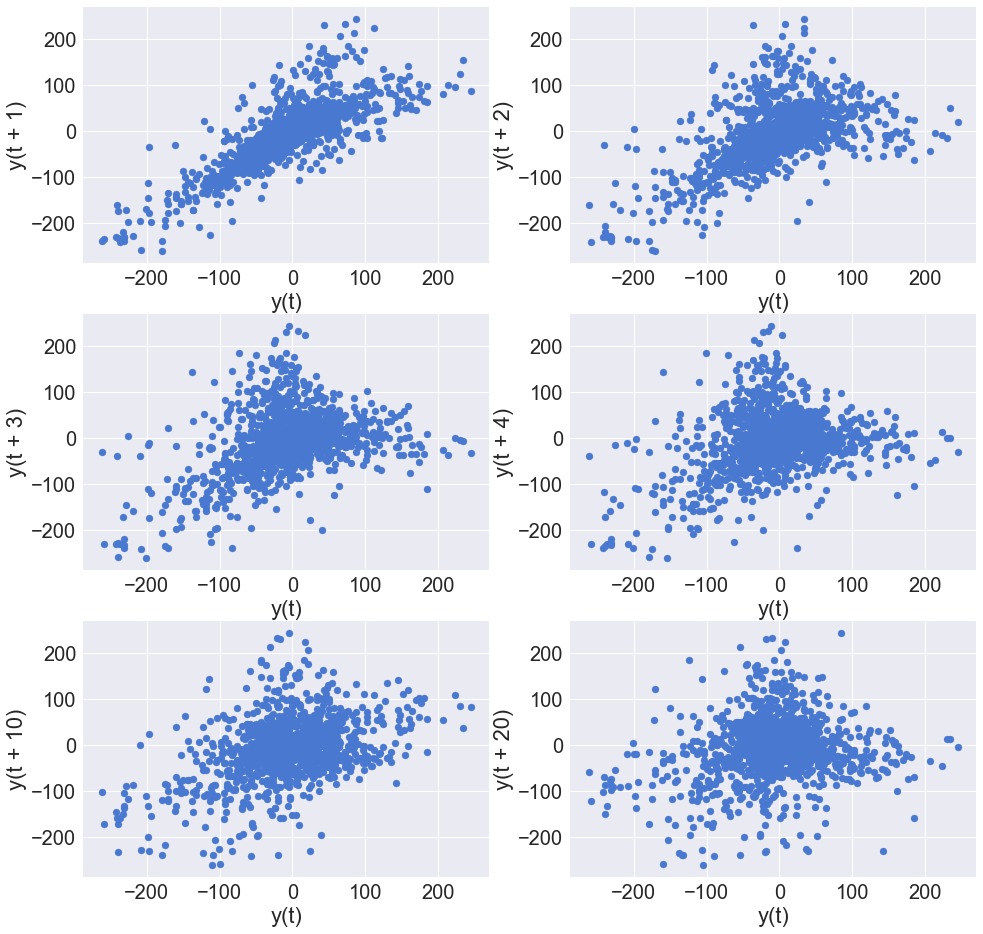

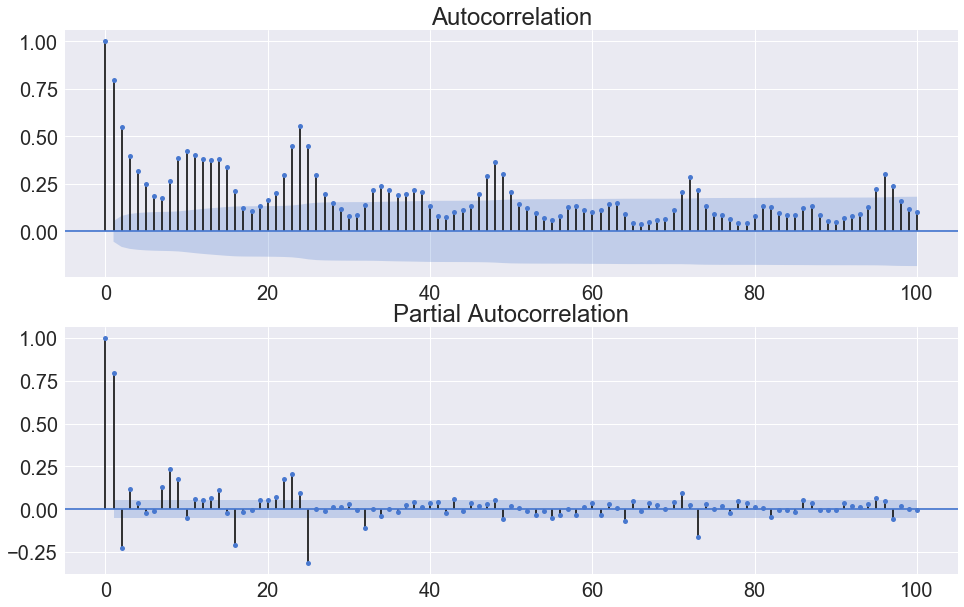

In [439]:
# Data Loading
location_url = 'https://raw.githubusercontent.com/cheonbi/DataScience/master/Data/Bike_Sharing_Demand_Full.csv'
raw_copy = pd.read_csv(location_url)

# Feature Engineering
if 'datetime' in raw_copy.columns:
    raw_copy['datetime'] = pd.to_datetime(raw_copy['datetime'])
    raw_copy['DateTime'] = pd.to_datetime(raw_copy['datetime'])
raw_copy.info()
if raw_copy.index.dtype == 'int64':
    raw_copy.set_index('DateTime', inplace=True)
raw_copy
# bring back
# if raw_copy.index.dtype != 'int64':
#     raw_copy.reset_index(drop=False, inplace=True)
# raw_copy
raw_copy = raw_copy.asfreq('H', method='ffill')

# Data Split
# Confirm of input and output
Y_colname_cp = ['count']
X_remove_cp = ['datetime', 'temp_group', 'casual', 'registered']
X_colname_cp = [x for x in raw_copy.columns if x not in Y_colname+X_remove]
X_colname_cp
X_train_cp, X_test_cp, Y_train_cp, Y_test_cp = datasplit_ts(raw_copy, Y_colname_cp, X_colname_cp, '2012-07-01')

# Applying Base Model
model_fit_reg1_cp = sm.OLS(Y_train_cp, X_train_cp).fit()
display(model_fit_reg1_cp.summary())
model_pred_tr_reg1_cp = model_fit_reg1_cp.predict(X_train_cp).values
model_pred_te_reg1_cp = model_fit_reg1_cp.predict(X_test_cp).values

# Evaluation
Score1_cp, Resid_tr_reg1_cp, Resid_te_reg1_cp = evaluation_trte(Y_train_cp, model_pred_tr_reg1_cp, 
                                                                Y_test_cp, model_pred_te_reg1_cp, graph_on=True)
display(Score1_cp)

# Error Analysis
error_analysis(Resid_tr_reg1_cp, ['Error'], X_train, graph_on=True)